# `DataDynamos`

**Table of Contents:**
1. [Data Collection and Preparation](#1-data-collection-and-preparation)  
2. [Descriptive Analytics](#2-descriptive-analytics)
    - [Temporal Patterns and Seasonality](#Temporal-patterns-and-Seasonality)
    - [Key Performance Indicators (KPIs)](#key-performance-indicators-kpis)
    - [Site Characteristics](#site-characteristics-identifying-the-public-charging-hub)
3. [Cluster Analysis](#3-cluster-analysis)
4. [Utilization Prediction](#4-utilization-prediction)
    - [Random Forest](#1-random-forest-model)
    - [Polynmial Regression](#2-polynomial-regression-model)
    - [Neural Network](#3-neural-network-model)
5. [Model Evaluation and Revision](#model-evaluation-and-revision)

------------------------------------------------

## `1. Data Collection and Preparation`

First, we import important libraries needed for the following tasks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

#### Preprocessing Charging Sessions Dataset

We import the necessary dataset (charging sessions of EVs) with the data of charging garages in Los Angeles.

In [2]:
data_raw = pd.read_csv("data/charging_sessions.csv")

Getting a first sight of the data by displaying the first 5 observations.

In [3]:
data_raw.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [4]:
num_rows, num_columns = data_raw.shape
print(f"rows: {num_rows}, columns: {num_columns}")

rows: 66450, columns: 13


The data in the dataset contains 66.450 observation over 13 different variables. Next, we drop duplicates and have closer look at the different datatypes.

In [5]:
columns = [
    'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered',
    'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs'
]
data_unique = data_raw.drop_duplicates(subset=columns)

In [6]:
dtypes_data = data_unique.dtypes.reset_index()
dtypes_data.columns = ['Row', 'Datetype']
print(dtypes_data)

                 Row Datetype
0         Unnamed: 0    int64
1                 id   object
2     connectionTime   object
3     disconnectTime   object
4   doneChargingTime   object
5       kWhDelivered  float64
6          sessionID   object
7             siteID    int64
8            spaceID   object
9          stationID   object
10          timezone   object
11            userID  float64
12        userInputs   object


We convert all the data into corresponding data types so that we can use them in the further analysis. 
The time-related data is given in the UTC time zone, but the garages are in Los Angeles. In order to obtain accurate information about the timestamps, the data must therefore be converted to the corresponding time zone (LosAngeles).  

In [7]:
data_unique['id'] = data_unique['id'].astype("string")
data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['disconnectTime'] = pd.to_datetime(data_unique['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['doneChargingTime'] = pd.to_datetime(data_unique['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['siteID'] = data_unique['siteID'].astype("int")
data_unique['spaceID'] = data_unique['spaceID'].astype("string")
data_unique['stationID'] = data_unique['stationID'].astype("string")
data_unique['timezone'] = data_unique['timezone'].astype("string")
data_unique['userID'] = data_unique['userID'].astype("string")
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['userInputs'] = data_unique['userInputs'].apply(lambda x: list(x) if isinstance(x, list) else [x])

The `unnamed` column is presumably an index from the riginal DataFrame and gets transferred into a column when reading the CSV-file. Since our data contains a unique ID for each entry, the unnamed-numbering is not needed and can be deleted.

In [8]:
data_unique = data_unique.drop('Unnamed: 0', axis=1)

print(data_unique.dtypes)

id                  string[python]
connectionTime      datetime64[ns]
disconnectTime      datetime64[ns]
doneChargingTime    datetime64[ns]
kWhDelivered               float64
sessionID           string[python]
siteID                       int64
spaceID             string[python]
stationID           string[python]
timezone            string[python]
userID              string[python]
userInputs                  object
dtype: object


In [9]:
print(data_unique.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 65036
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                65037 non-null  string        
 1   connectionTime    65037 non-null  datetime64[ns]
 2   disconnectTime    65037 non-null  datetime64[ns]
 3   doneChargingTime  60950 non-null  datetime64[ns]
 4   kWhDelivered      65037 non-null  float64       
 5   sessionID         65037 non-null  string        
 6   siteID            65037 non-null  int64         
 7   spaceID           65037 non-null  string        
 8   stationID         65037 non-null  string        
 9   timezone          65037 non-null  string        
 10  userID            47822 non-null  string        
 11  userInputs        65037 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(1), string(6)
memory usage: 6.5+ MB
None


In [10]:
missing_values_count = data_unique.isnull().sum()
print(missing_values_count)

id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs              0
dtype: int64


By looking at the dataframe, you can see that `doneChargingTime` and `userID` have missing values.  

The missing values in userID can be explained by the fact that not every garage user is registered; therefore, some accounts are naturally absent. However, the missing entries in `doneChargingTime` appear unusual.

In [11]:
# create Table with missing values in doneChargingTimeb
miss_doneChargingTime = data_unique[data_unique['doneChargingTime'].isna()]
miss_doneChargingTime.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
3756,5ea3848df9af8b428bf97225,2020-04-08 09:36:53,2020-04-08 20:43:29,NaT,25.183,1_1_194_822_2020-04-08 16:36:53.316264,1,AG-1F12,1-1-194-822,America/Los_Angeles,507.0,"[[{'WhPerMile': 250, 'kWhRequested': 75.0, 'mi..."
3757,5ea4d60df9af8b46573f1ee7,2020-04-09 06:23:52,2020-04-09 10:59:02,NaT,14.136,1_1_193_827_2020-04-09 13:23:51.689520,1,AG-1F02,1-1-193-827,America/Los_Angeles,419.0,"[[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mi..."
3758,5ea4d60df9af8b46573f1ee8,2020-04-09 06:40:03,2020-04-09 14:43:22,NaT,14.203,1_1_178_823_2020-04-09 13:39:55.115497,1,AG-1F08,1-1-178-823,America/Los_Angeles,5065.0,"[[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mi..."
3759,5ea4d60df9af8b46573f1ee9,2020-04-09 07:01:53,2020-04-09 09:33:40,NaT,13.041,1_1_178_828_2020-04-09 14:01:53.467693,1,AG-1F10,1-1-178-828,America/Los_Angeles,651.0,"[[{'WhPerMile': 400, 'kWhRequested': 20.0, 'mi..."
3760,5ea4d60df9af8b46573f1eea,2020-04-09 08:01:06,2020-04-09 16:38:08,NaT,5.797,1_1_193_820_2020-04-09 15:01:06.343454,1,AG-1F04,1-1-193-820,America/Los_Angeles,466.0,"[[{'WhPerMile': 300, 'kWhRequested': 6.0, 'mil..."


Upon closer analysis of the missing entries for the charging time (`miss_doneChargingTime`), we found that all of them have normal values for the attribute `kWhDelivered`, indicating that current flow was indeed present.

(Removing this data from the dataframe would imply that the charging stations were free at those times, which is inaccurate and would skew predictions. Therefore, we decided to retain this data for now and, if necessary, exclude it during model training and predictions about parking space utilization after charging is complete.)

We calculate the the percentage of missing (NaN) values for each column.

In [12]:
data_unique.isnull().mean() * 100

id                   0.000000
connectionTime       0.000000
disconnectTime       0.000000
doneChargingTime     6.284115
kWhDelivered         0.000000
sessionID            0.000000
siteID               0.000000
spaceID              0.000000
stationID            0.000000
timezone             0.000000
userID              26.469548
userInputs           0.000000
dtype: float64

Let's calculate the percentage of data left after removing the missing values.

In [13]:
len(data_unique['doneChargingTime'].dropna())/len(data_unique['doneChargingTime']) * 100

93.71588480403462

After removing the columns with missing values, around 94% of the data is still intact which seems to be sufficient. So we first create a copy of the data set in order to then remove the missing values from ‘doneChargingTime’.

In [14]:
# Create a copy of the data before dropping NA values from doneChaargingTime
data_with_NA = data_unique.copy()

# Drop NA from doneChargingTime
data_unique.dropna(subset=['doneChargingTime'], inplace=True)

print(data_unique['doneChargingTime'].isnull().sum())

0


We can explore how the data is distributed in each column before and after removing null values by plotting histograms. This approach will enable us to compare the distribution trends in both scenarios.

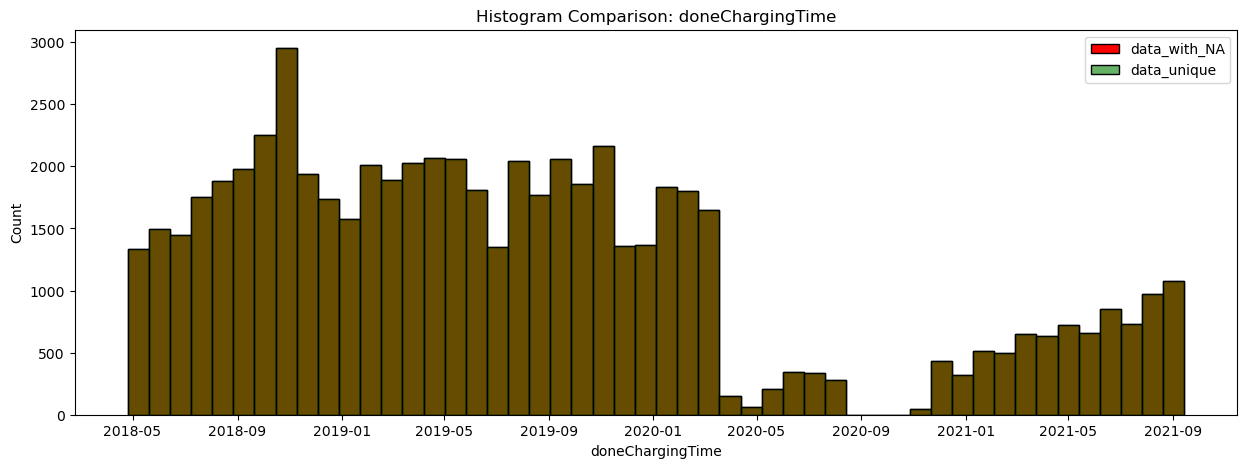

In [15]:
plt.figure(figsize=(15, 5))

# Histogram: Data with doneChargingTime NaT values
sns.histplot(data=data_with_NA, x='doneChargingTime', bins=50, color='red', alpha=1, kde=False, label='data_with_NA')

# Histogram: Data with removed doneChargingTime NaT values
sns.histplot(data=data_unique, x='doneChargingTime', bins=50, color='green', alpha=0.6, kde=False, label='data_unique')

plt.legend()

plt.title('Histogram Comparison: doneChargingTime')
plt.xlabel('doneChargingTime')
plt.ylabel('Count')

plt.show()


By comparing the histograms of the 'doneChargingTime' column before and after removing the null values, it is clear that the data distribution stays consistent. The overlapping histograms show that there is no major change in the distribution pattern after null values were removed.

In [16]:
filtered_data = data_unique[data_unique['doneChargingTime'] > data_unique['disconnectTime']]

filtered_data['time_difference'] = (filtered_data['doneChargingTime'] - filtered_data['disconnectTime']).dt.total_seconds()

average_difference = filtered_data['time_difference'].mean()

average_kwh_delivered = filtered_data['kWhDelivered'].mean()

other_cases = data_unique[data_unique['doneChargingTime'] <= data_unique['disconnectTime']]

average_kwh_delivered_other = other_cases['kWhDelivered'].mean()

print(f"Average Difference: {average_difference:.2f} seconds")
print(f"Average kWh (doneChargingTime > disconnectTime): {average_kwh_delivered:.2f} kWh")
print(f"Average kWh (doneChargingTime <= disconnectTime): {average_kwh_delivered_other:.2f} kWh")

Average Difference: 56.02 seconds
Average kWh (doneChargingTime > disconnectTime): 14.24 kWh
Average kWh (doneChargingTime <= disconnectTime): 11.38 kWh


In [17]:
filtered_data.head(10)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,time_difference
12,5e23b149f9af8b5fe4b973db,2020-01-02 07:04:38,2020-01-02 14:08:39,2020-01-02 14:09:36,25.567,1_1_178_824_2020-01-02 15:04:38.051735,1,AG-1F07,1-1-178-824,America/Los_Angeles,528.0,"[[{'WhPerMile': 250, 'kWhRequested': 50.0, 'mi...",57.0
20,5e23b149f9af8b5fe4b973e3,2020-01-02 07:28:47,2020-01-02 11:01:54,2020-01-02 11:02:51,7.417,1_1_193_827_2020-01-02 15:28:46.685366,1,AG-1F02,1-1-193-827,America/Los_Angeles,1283.0,"[[{'WhPerMile': 350, 'kWhRequested': 42.0, 'mi...",57.0
25,5e23b149f9af8b5fe4b973e8,2020-01-02 07:42:05,2020-01-02 13:58:45,2020-01-02 13:59:42,36.701,1_1_179_797_2020-01-02 15:42:05.217965,1,AG-3F23,1-1-179-797,America/Los_Angeles,474.0,"[[{'WhPerMile': 400, 'kWhRequested': 32.0, 'mi...",57.0
26,5e23b149f9af8b5fe4b973e9,2020-01-02 07:57:24,2020-01-02 08:35:37,2020-01-02 08:36:34,3.689,1_1_179_781_2020-01-02 15:57:23.951170,1,AG-3F31,1-1-179-781,America/Los_Angeles,724.0,"[[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mil...",57.0
33,5e23b149f9af8b5fe4b973f0,2020-01-02 08:34:35,2020-01-02 10:49:41,2020-01-02 10:50:38,7.120,1_1_179_790_2020-01-02 16:34:34.999200,1,AG-3F19,1-1-179-790,America/Los_Angeles,2276.0,"[[{'WhPerMile': 600, 'kWhRequested': 18.0, 'mi...",57.0
45,5e23b149f9af8b5fe4b973fc,2020-01-02 10:41:22,2020-01-02 11:38:24,2020-01-02 11:39:23,5.430,1_1_191_812_2020-01-02 18:41:22.082480,1,AG-4F46,1-1-191-812,America/Los_Angeles,741.0,"[[{'WhPerMile': 400, 'kWhRequested': 32.0, 'mi...",59.0
49,5e23b149f9af8b5fe4b97400,2020-01-02 11:08:34,2020-01-02 14:52:36,2020-01-02 14:53:36,22.839,1_1_191_811_2020-01-02 19:08:34.209436,1,AG-4F42,1-1-191-811,America/Los_Angeles,1283.0,"[[{'WhPerMile': 350, 'kWhRequested': 42.0, 'mi...",60.0
51,5e23b149f9af8b5fe4b97402,2020-01-02 11:30:53,2020-01-02 15:18:39,2020-01-02 15:19:36,4.405,1_1_179_810_2020-01-02 19:30:53.010234,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[[{'WhPerMile': 250, 'kWhRequested': 10.0, 'mi...",57.0
53,5e23b149f9af8b5fe4b97404,2020-01-02 12:31:37,2020-01-02 18:21:37,2020-01-02 18:22:34,33.645,1_1_178_823_2020-01-02 20:31:37.206013,1,AG-1F08,1-1-178-823,America/Los_Angeles,337.0,"[[{'WhPerMile': 250, 'kWhRequested': 35.0, 'mi...",57.0
57,5e23b149f9af8b5fe4b97408,2020-01-02 14:46:56,2020-01-02 16:49:34,2020-01-02 16:50:34,13.005,1_1_179_809_2020-01-02 22:46:56.495691,1,AG-3F27,1-1-179-809,America/Los_Angeles,2276.0,"[[{'WhPerMile': 600, 'kWhRequested': 18.0, 'mi...",60.0


In the dataset, entries were identified where doneChargingTime exceeds disconnectTime. As the time difference in most cases is less than one minute, we assume a delayed timestamp for doneChargingTime. Therefore, we set doneChargingTime equal to disconnectTime wherever it exceeds the latter.

In [18]:
# Set doneChargingTime to disconnectTime if doneChargingTime is greater than disconnectTime
data_unique.loc[data_unique['doneChargingTime'] > data_unique['disconnectTime'], 'doneChargingTime'] = data_unique['disconnectTime']

#### Outlier Detection

This analysis focuses on detecting outliers in the kWhDelivered column. We start by examining the statistical summary to understand the data distribution.

In [19]:
data_unique.describe()[['kWhDelivered']]

,kWhDelivered
count,60950.000000
mean,11.583268
min,0.501000
25%,5.013000
50%,8.991000
75%,13.984000
max,108.797242
std,10.153601


Although the mean is relatively sensitive to outliers, the mean of kWhDelivered is 11.58 while the maximum is 108.8. This shows that the maximum is an outlier. We make use of a boxplot and a histogram to visually summarize the distribution and identify potential outliers.

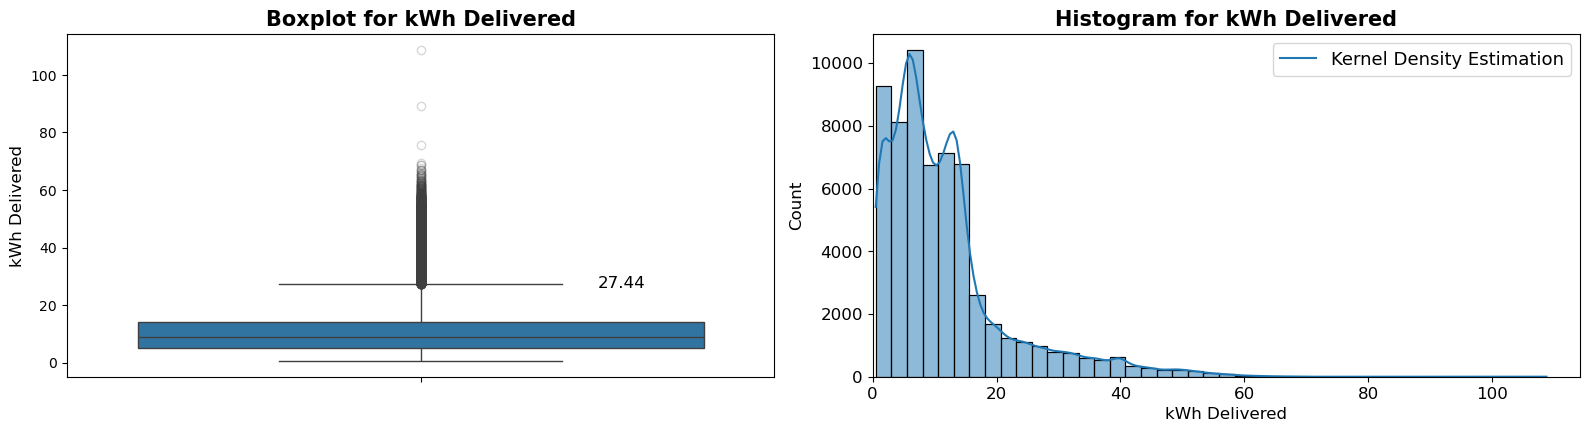

In [20]:
plt.figure(figsize=(16, 8))

q1 = data_unique['kWhDelivered'].quantile(0.25)
q3 = data_unique['kWhDelivered'].quantile(0.75)
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.2})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("")
plt.text(0.25, upper_whisker, f"{upper_whisker:.2f}", 
         ha='left', va='center', fontsize=12, color='black')

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_unique['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12) 
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Based on the two visualizations, it is evident that the majority of the values are quite low. The upper whisker of the boxplot is at 27.44, meaning it represents the largest value in the dataset that is less than or equal to Q3 + 1.5 * IQR. Values above this threshold are considered outliers. These become more frequent up to approximately 60. Only three observations fall between 75 and 110. The distribution is highly positively right skewed.

The following function calculates the IQR to detect outliers above the upper whisker.

In [21]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   iqr=q3-q1

   outliers = df[((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr)))]

   return outliers

In [22]:
outliers = find_outliers_IQR(data_unique['kWhDelivered'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 5168
max outlier value: 108.79724166666666
min outlier value: 27.442


1        33.097
6        43.477
7        32.441
13       39.806
21       49.874
          ...  
65003    32.334
65005    30.030
65008    35.007
65024    30.198
65029    41.047
Name: kWhDelivered, Length: 5168, dtype: float64

The summary indicates that there are 5,168 outliers. The lowest outlier value is 27.44, as previously mentioned, while the maximum is 108.8.

In [23]:
data_unique[data_unique['kWhDelivered'] > 70]

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
18641,610c829df9af8b0580e98730,2021-07-20 15:16:54,2021-07-21 08:18:03,2021-07-21 08:18:03,108.797242,1_1_193_829_2021-07-20 18:27:33.500144,1,AG-1F03,1-1-193-829,America/Los_Angeles,378.0,"[[{'WhPerMile': 258, 'kWhRequested': 35.088, '..."
18643,610c829df9af8b0580e98732,2021-07-20 15:16:56,2021-07-21 08:18:16,2021-07-21 08:18:16,89.362732,1_1_194_818_2021-07-20 13:54:47.875453,1,AG-1F14,1-1-194-818,America/Los_Angeles,481.0,"[[{'WhPerMile': 360, 'kWhRequested': 86.4, 'mi..."
20986,5c60d02df9af8b149d7da395,2019-01-25 19:40:20,2019-01-26 14:36:03,2019-01-26 06:45:12,75.528000,2_39_91_437_2019-01-26 03:40:20.383123,2,CA-317,2-39-91-437,America/Los_Angeles,1225.0,"[[{'WhPerMile': 600, 'kWhRequested': 180.0, 'm..."


The high kWhDelivered values are rare but appear to be realistic given the long charging durations.

The following function replaces the outlier values that exceed the given upper limit with the median value of 'kWhDelivered'.

In [24]:
def cap_outliers(df, column, upper_limit):

    median = df[column].median()
    print(f"Median: {median}")

    upper_limit = upper_limit
    print(f"Upper limit: {upper_limit}")

    df[column] = np.where(
        df[column] > upper_limit,
        median,
        df[column]
    )
    return df


In [25]:
data_unique = cap_outliers(data_unique, 'kWhDelivered', 27)

Median: 8.991
Upper limit: 27


Replotting the resulting distribution after capping the outliers at 27.

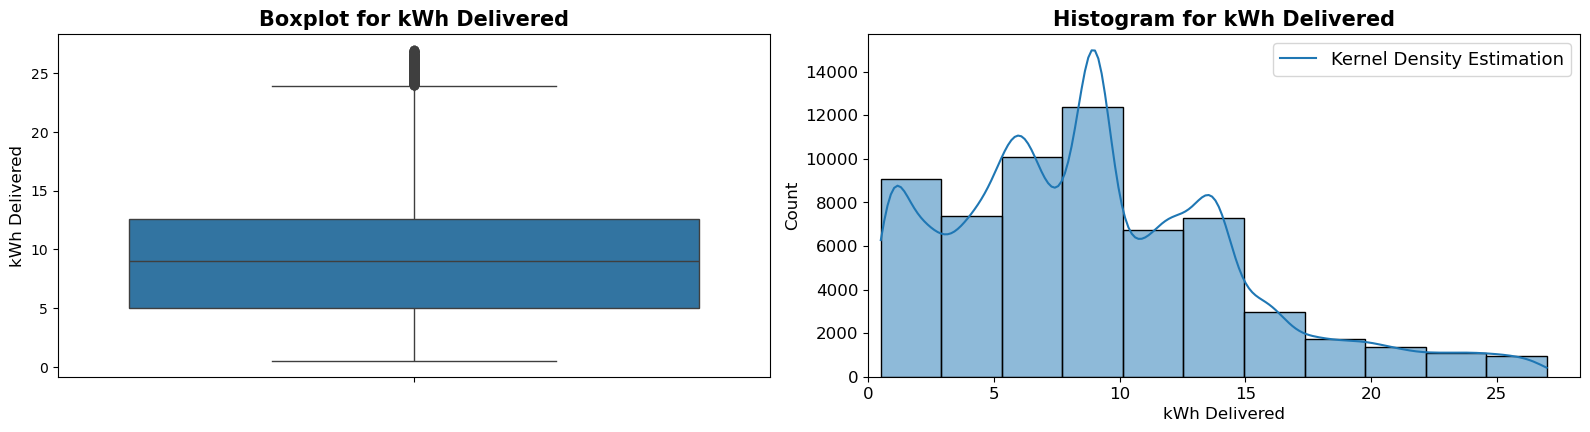

In [26]:
plt.figure(figsize=(16, 8))

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.1})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("") 

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_unique['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

By capping the outliers at the upper whisker to the median, the distribution becomes more stable and less influenced by extreme values. The values concentrate more closely around the median, making the distribution more compact.

#### Extracting "userInputs" into a Separate Table

Process the column userInputs to ensure each entry is JSON-formatted and interpretable as a Python dictionary.

In [27]:
import json

data_unique['userInputs'] = data_unique['userInputs'].astype("string")

def format_user_input(entry):
    try:
        entry = entry[2:-2]
        entry = entry.replace("'", "\"").replace("True", "true").replace("False", "false")  
        return json.loads(entry)  
    except json.JSONDecodeError:
        return None  


data_unique['userInputs']= data_unique['userInputs'].apply(format_user_input)

This code extracts the contents of the userInputs column into a separate table for better clarity and organization of data. By splitting out userInputs, each nested entry can be analyzed individually, providing a more detailed view of the information stored within. This approach makes it easier to work with and understand the data structure, especially when userInputs contains multiple key-value pairs or complex JSON objects. By creating a dedicated table, each entry can be accessed, processed, and filtered independently, enhancing data readability and simplifying further analysis.

In [28]:
# Split nested lists in 'userInputs' into separate rows, resetting index for a clean DataFrame.
data_unique_splitted = data_unique.explode('userInputs', ignore_index=True)

# Select only specific columns 'id', 'userID', and 'userInputs' from the exploded DataFrame.
userInputs_data = data_unique_splitted[['id', 'userID', 'userInputs']]

# Rename the 'id' column to 'data_unique_id' for clarity.
userInputs_data = userInputs_data.rename(columns={'id': 'data_unique_id'})

# Add a new column 'id' with a unique sequential identifier for each row.
userInputs_data['id'] = range(1, len(userInputs_data) + 1)

# Expand the JSON data in 'userInputs' column to separate columns for each key-value pair.
userInputs_expanded = pd.json_normalize(userInputs_data['userInputs'])

# Concatenate the expanded data with the original DataFrame along columns (side by side).
userInputs_data = pd.concat([userInputs_data, userInputs_expanded], axis=1)

# Drop the original 'userInputs' column as it's no longer needed after expanding.
userInputs_data = userInputs_data.drop('userInputs', axis=1)

# Remove rows with missing values in critical columns 'userID', 'WhPerMile', and 'kWhRequested'.
userInputs_data = userInputs_data.dropna(subset=['userID', 'WhPerMile', 'kWhRequested'])

# Convert 'paymentRequired' column to a boolean type for correct data interpretation.
userInputs_data['paymentRequired'] = userInputs_data['paymentRequired'].astype(bool)

# Modify 'modifiedAt' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['modifiedAt'] = pd.to_datetime(userInputs_data['modifiedAt'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

# Modify 'requestedDeparture' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['requestedDeparture'] = pd.to_datetime(userInputs_data['requestedDeparture'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

#  drop userInputs in data_unique table since its not needed anymore
data_unique = data_unique.drop('userInputs', axis=1)


In [29]:
# split the dataset in two different. One for the station with siteID 1 and one for the station with the siteID 2 for further analysis
data_1 = data_unique[data_unique['siteID']==1]
data_2 = data_unique[data_unique['siteID']==2]

#### Preprocessing Weather Burbank Dataset

The weather dataset is also imported and duplicates are removed. Although there are none, we have carried out this step to be on the safe side.  
The data was converted to the corresponding data types and the time was adjusted to the los-angeles time zone again.  
There is some missing data in this data set for the `temperature` and the `cloud_cover`. However, these are difficult to reproduce and are therefore deleted from the data set.

In [30]:
weather_raw=pd.read_csv("data/weather_burbank_airport.csv")

# delete duplicates
columns = [
    'city', 'timestamp', 'temperature', 'cloud_cover',
    'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'
]
weather_unique = weather_raw.drop_duplicates(subset=columns)

#Transform to correct Data Types
weather_unique['city']=weather_raw['city'].astype('string')
weather_unique['timestamp'] = pd.to_datetime(weather_raw['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
weather_unique['cloud_cover_description']=weather_raw['cloud_cover_description'].astype('string')

print(weather_unique.dtypes)

# Fill missing (NaN) values in the columns with the previous valid value using forward fill method
weather_unique['temperature'] = weather_unique['temperature'].fillna(method='ffill')
weather_unique['cloud_cover'] = weather_unique['cloud_cover'].fillna(method='ffill')
weather_unique['pressure'] = weather_unique['pressure'].fillna(method='ffill')
weather_unique['windspeed'] = weather_unique['windspeed'].fillna(method='ffill')
weather_unique['felt_temperature'] = weather_unique['felt_temperature'].fillna(method='ffill')

# Drop column cloud_cover_description as it is not useful anway
weather_unique = weather_unique.drop(columns=['cloud_cover_description'])

# Check whether there are columns with missing values
missing_summary = weather_unique.isnull().sum()

# List columns with NaN values
missing_columns = missing_summary[missing_summary > 0]
print("\Columns with missing values:")
print(missing_columns)

# List rows with NaN values
rows_with_missing = weather_unique[weather_unique.isnull().any(axis=1)]
print("\nRows with missing values:")
print(rows_with_missing)

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object
\Columns with missing values:
Series([], dtype: int64)

Rows with missing values:
Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, pressure, windspeed, precipitation, felt_temperature]
Index: []


------------------------------------------------

#  `2. Descriptive Analytics`

### **Temporal patterns and Seasonality**

We will begin by analyzing the temporal patterns and seasonality of charging events. This analysis will focus on understanding how charging behavior evolves over time and identifying any recurring seasonal trends. Our goal is to uncover initial patterns and propose possible hypotheses to explain these phenomena.

It is important to note that a charging event is primarily considered as the duration from the connection time to the disconnection time. However, we will also examine the perspective where the event is measured from the connection time to the "done charging" time.

#### Daily patterns

Histogram of charging sessions throughout the day, broken down by each hour of the day. The calculation spans from the connection time to the disconnection time.

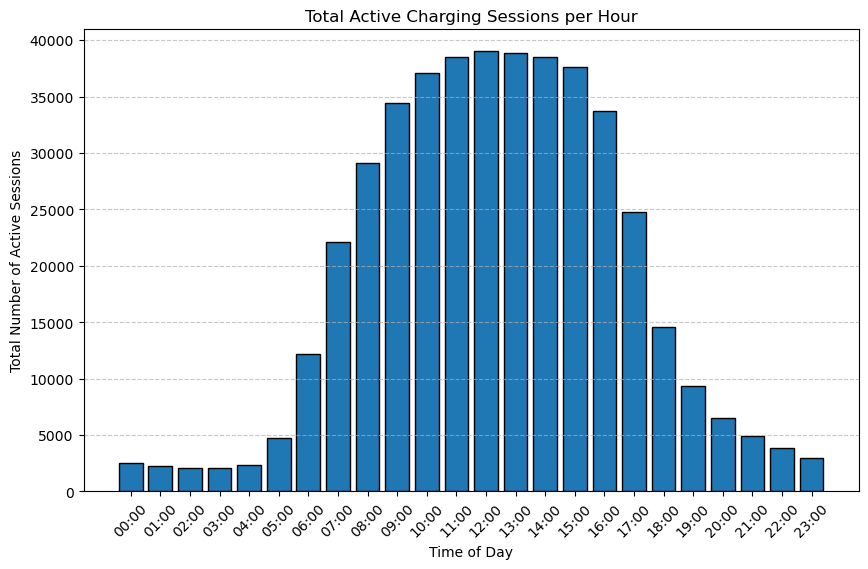

In [31]:
# Initialize an array to store the number of active charging sessions for each hour
active_sessions_by_hour = np.zeros(24)

# Loop through each row to calculate active sessions for each hour
for index, row in data_unique.iterrows():
    # Extract the start and end hours of the charging session
    start_hour = row['connectionTime'].hour
    end_hour = row['disconnectTime'].hour

    # Handle sessions that span across midnight
    if row['disconnectTime'].date() > row['connectionTime'].date():
        end_hour += 24  # Extend the end hour beyond midnight

    # Increment the active sessions for each hour within the session's range
    for hour in range(start_hour, end_hour + 1):
        active_sessions_by_hour[hour % 24] += 1  # %24 to wrap around to 0–23 hours

# Create time labels for the x-axis in "HH:00" format
time_labels = [f"{hour:02d}:00" for hour in range(24)]

# Visualization: Histogram of total active charging sessions per hour
plt.figure(figsize=(10, 6))
plt.bar(range(24), active_sessions_by_hour, tick_label=time_labels, width=0.8, edgecolor="black")
plt.title('Total Active Charging Sessions per Hour')
plt.xlabel('Time of Day')
plt.ylabel('Total Number of Active Sessions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis
plt.ticklabel_format(style='plain', axis='y')  # Ensure plain format for y-axis
plt.show()

Histogram of the actual charging process required to fully charge a vehicle throughout the day, broken down by each hour of the day. The calculation spans from the connection time to the done charging time.

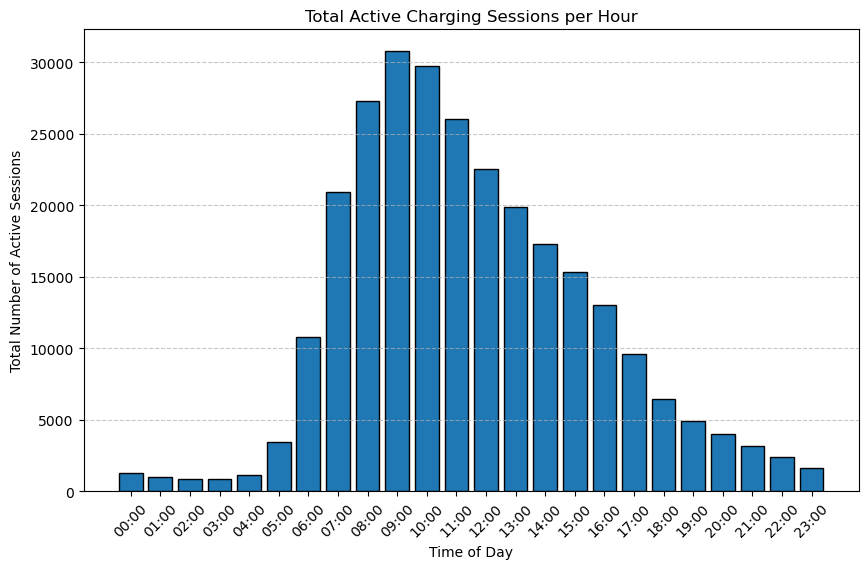

In [32]:
# Initialize an array to store the number of active charging sessions for each hour
active_sessions_by_hour = np.zeros(24)

# Loop through each row to calculate active sessions for each hour
for index, row in data_unique.iterrows():
    # Extract the start and end hours of the charging session
    start_hour = row['connectionTime'].hour
    end_hour = row['doneChargingTime'].hour

    # Handle sessions that span across midnight
    if row['doneChargingTime'].date() > row['connectionTime'].date():
        end_hour += 24  # Extend the end hour beyond midnight

    # Increment the active sessions for each hour within the session's range
    for hour in range(start_hour, end_hour + 1):
        active_sessions_by_hour[hour % 24] += 1  # %24 to wrap around to 0–23 hours

# Create time labels for the x-axis in "HH:00" format
time_labels = [f"{hour:02d}:00" for hour in range(24)]

# Visualization: Histogram of total active charging sessions per hour
plt.figure(figsize=(10, 6))
plt.bar(range(24), active_sessions_by_hour, tick_label=time_labels, width=0.8, edgecolor="black")
plt.title('Total Active Charging Sessions per Hour')
plt.xlabel('Time of Day')
plt.ylabel('Total Number of Active Sessions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis
plt.ticklabel_format(style='plain', axis='y')  # Ensure plain format for y-axis
plt.show()

Histogram of connection times throughout the day, categorized by each hour of the day.

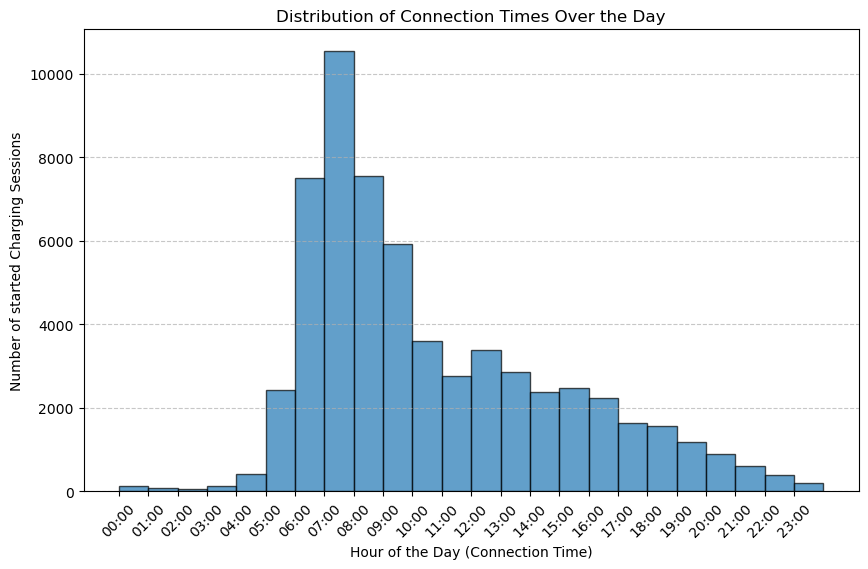

In [33]:
# Plot a histogram to show the distribution of connection times over the day
data_unique['connectionHour'] = data_unique['connectionTime'].dt.hour

plt.figure(figsize=(10, 6))
plt.hist(data_unique['connectionHour'], bins=24, range=(0, 24), edgecolor='black', alpha=0.7)
plt.title('Distribution of Connection Times Over the Day')
plt.xlabel('Hour of the Day (Connection Time)')
plt.ylabel('Number of started Charging Sessions')
plt.xticks(range(24), [f"{hour:02d}:00" for hour in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Histogram of the disconnection times and done charging times throughout the day, categorized by each hour of the day.

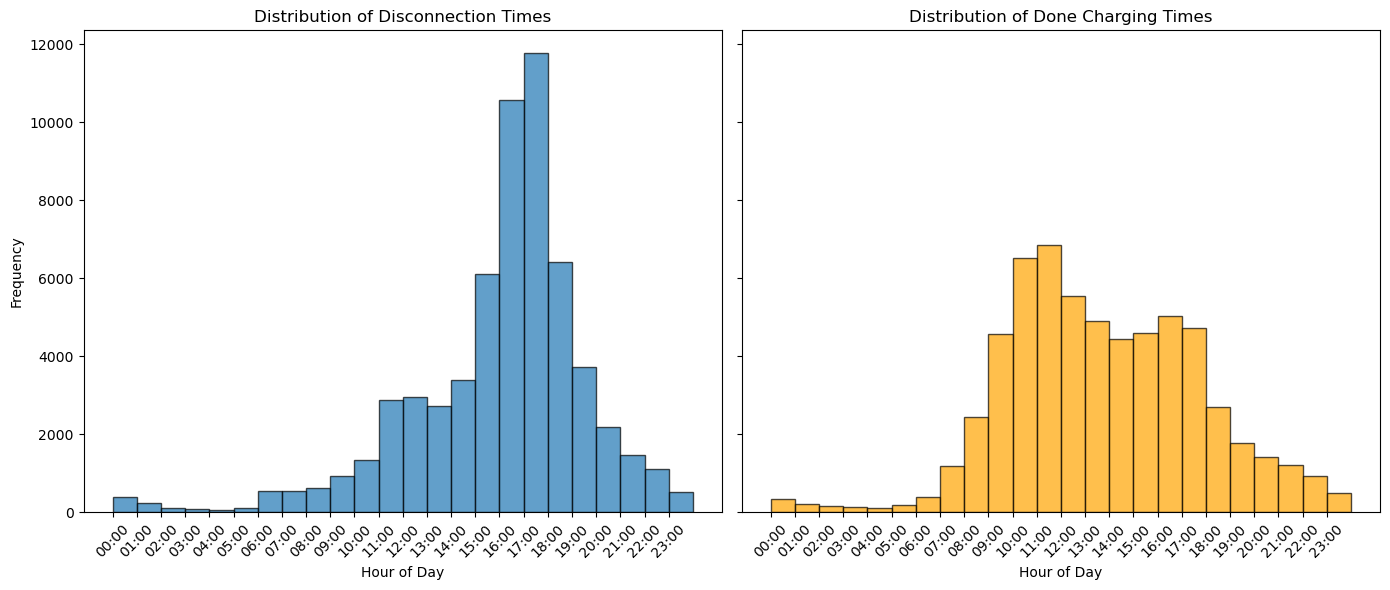

In [34]:
# Extract hours from 'disconnectTime' and 'doneChargingTime' for distribution analysis
disconnect_hours = data_unique['disconnectTime'].dt.hour
done_charging_hours = data_unique['doneChargingTime'].dt.hour

# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot histogram for disconnection times
axes[0].hist(disconnect_hours, bins=24, range=(0, 24), edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Disconnection Times')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, 24))
axes[0].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)

# Plot histogram for done charging times
axes[1].hist(done_charging_hours, bins=24, range=(0, 24), edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of Done Charging Times')
axes[1].set_xlabel('Hour of Day')
axes[1].set_xticks(range(0, 24))
axes[1].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The analysis of daily patterns reveals that most charging sessions occur between 7:00 AM and 5:00 PM. Within the context of the data, this suggests that these times correspond to when most individuals are either at the university or at work. This observation is further supported by the detailed examination of connection times and disconnection times for each hour.

Additionally, it is noteworthy that the charging sessions, measured from the connection time to the disconnection time, are generally longer than the actual charging process required to fully charge a vehicle (measured from the connection time to the done charging time). This indicates that vehicles often remain connected to the charging station well after they are fully charged.

#### Weekly patterns

Bar chart of charging events distributed across the weekdays.

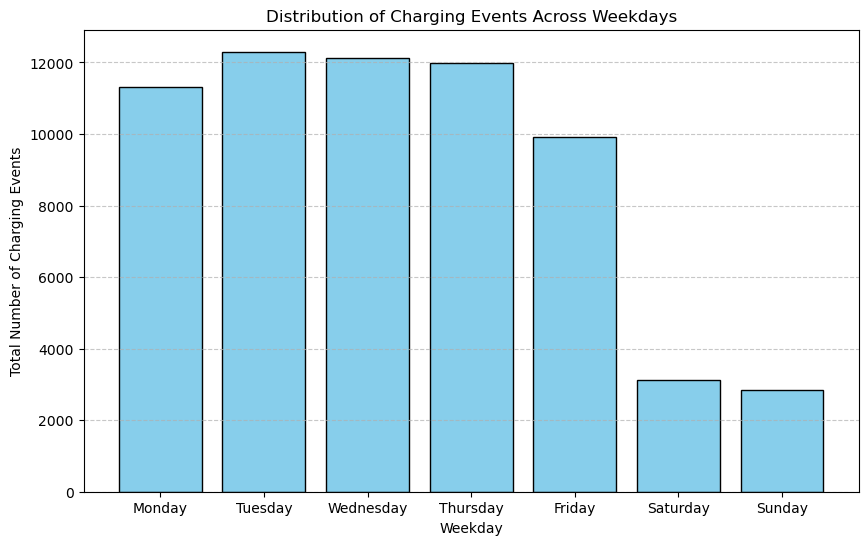

In [35]:
# Extract weekdays (0=Monday, 6=Sunday) from 'connectionTime'
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek  # Add a weekday column

# Create a list of weekday names for labeling
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Initialize an array to count active sessions for each weekday
active_sessions_by_weekday = np.zeros(7)

# Calculate active charging sessions for each weekday
for index, row in data_unique.iterrows():
    # Get the range of days spanned by the charging event
    start_date = row['connectionTime'].date()
    end_date = row['disconnectTime'].date()
    
    # If the session spans multiple days
    if start_date != end_date:
        days_spanned = pd.date_range(start=start_date, end=end_date, freq='D')
        for day in days_spanned:
            active_sessions_by_weekday[day.weekday()] += 1
    else:
        # Single-day session
        active_sessions_by_weekday[start_date.weekday()] += 1

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(7), active_sessions_by_weekday, tick_label=weekday_labels, color='skyblue', edgecolor='black')
plt.title('Distribution of Charging Events Across Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Total Number of Charging Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Nominal analysis of total charging sessions differentiated between weekdays and weekends.

In [36]:
# Extract weekday (0 = Monday, 6 = Sunday) from 'connectionTime'
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek

# Filter sessions for weekdays (0-4) and weekends (5-6)
weekday_sessions = data_unique[data_unique['weekday'] < 5]  # Monday to Friday
weekend_sessions = data_unique[data_unique['weekday'] >= 5]  # Saturday and Sunday

# Count sessions for weekdays and weekends
weekday_count = len(weekday_sessions)
weekend_count = len(weekend_sessions)
total_count = weekday_count + weekend_count

# Calculate the percentage of sessions on the weekend
weekend_percentage = (weekend_count / total_count) * 100

# Print results
print(f"Charging sessions during the week (Monday to Friday): {weekday_count}")
print(f"Charging sessions during the weekend (Saturday and Sunday): {weekend_count}")
print(f"Total charging sessions: {total_count}")
print(f"The percentage of charging sessions on the weekend is {weekend_percentage:.2f}%.")

Charging sessions during the week (Monday to Friday): 55748
Charging sessions during the weekend (Saturday and Sunday): 5202
Total charging sessions: 60950
The percentage of charging sessions on the weekend is 8.53%.


Heatmap for analyzing weekdays categorized by hours and the distribution of connection times.

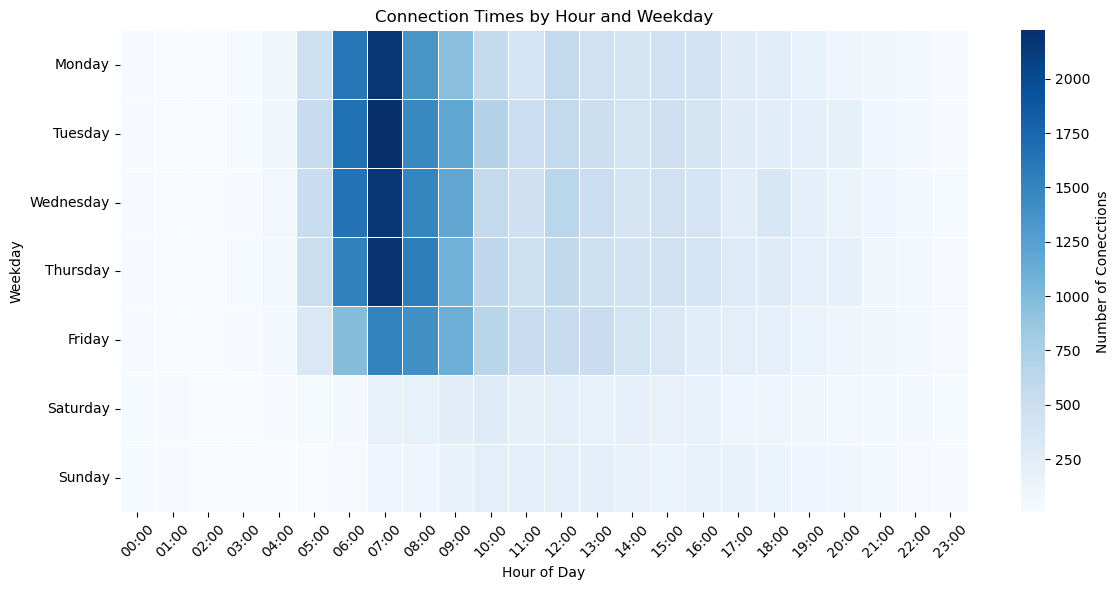

In [37]:
# Extract weekday and hour from connectionTime
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek  # 0=Monday, 6=Sunday
data_unique['hour'] = data_unique['connectionTime'].dt.hour

# Create a pivot table to count charging events for each combination of weekday and hour
heatmap_data = data_unique.pivot_table(
    index='weekday', 
    columns='hour', 
    values='connectionTime', 
    aggfunc='count', 
    fill_value=0
)

# Define weekday labels for the heatmap
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt="d", linewidths=0.5, cbar_kws={'label': 'Number of Conecctions'})
plt.title('Connection Times by Hour and Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')
plt.yticks(ticks=np.arange(7) + 0.5, labels=weekday_labels, rotation=0)
plt.xticks(ticks=np.arange(24) + 0.5, labels=[f"{h:02d}:00" for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

The analysis of weekly patterns in charging events reveals a clear trend: there are significantly more charging sessions on weekdays compared to weekends (only 8.53% of the total charging sessions are on Weekends). Starting from Friday, the number of sessions gradually declines, with a sharp drop on Saturday and Sunday. In the context of the data, this suggests that most individuals charge their vehicles during weekdays, while they are at work or university. This behavior aligns with the analysis of the daily patterns.


#### Seasonal patterns

Bar chart showing the distribution of charging sessions throughout the year, categorized by seasons.

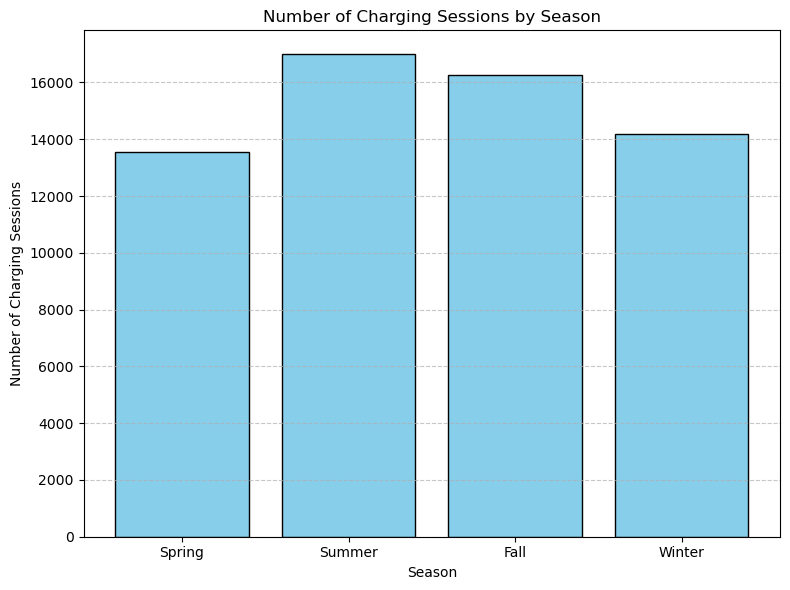

In [38]:
# Define a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Use groupby to count sessions by season
sessions_by_season = (
    data_unique['connectionTime']
    .dt.month
    .map(get_season)  # Map months to seasons
    .value_counts()
    .reindex(['Spring', 'Summer', 'Fall', 'Winter'])  # Sort seasons
)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(sessions_by_season.index, sessions_by_season.values, color='skyblue', edgecolor='black')
plt.title('Number of Charging Sessions by Season')
plt.xlabel('Season')
plt.ylabel('Number of Charging Sessions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Calculation of correlations between charging events and individual weather factors.

In [39]:
# Extract month for grouping
data_unique['month'] = data_unique['connectionTime'].dt.month
weather_unique['month'] = weather_unique['timestamp'].dt.month

# Aggregate monthly charging sessions
monthly_sessions = data_unique.groupby('month').size().rename('charging_sessions')

# Select only numeric columns for weather and aggregate monthly means
numeric_weather_cols = weather_unique.select_dtypes(include=['float64', 'int64']).columns
monthly_weather = weather_unique.groupby('month')[numeric_weather_cols].mean()

# Merge weather data with charging sessions
monthly_data = pd.merge(monthly_sessions, monthly_weather, left_index=True, right_index=True)

# Calculate correlations
correlations = monthly_data.corr()

# Display the correlations for charging sessions
charging_correlations = correlations['charging_sessions'].sort_values(ascending=False)
print("Correlations with Charging Sessions:\n", charging_correlations)


Correlations with Charging Sessions:
 charging_sessions    1.000000
cloud_cover          0.693941
temperature          0.669516
felt_temperature     0.666857
windspeed           -0.018960
pressure            -0.552563
precipitation       -0.593631
Name: charging_sessions, dtype: float64


Diagrams for analyzing the correlation between weather factors, seasons, and charging sessions, divided into positively correlated and negatively correlated weather factors.

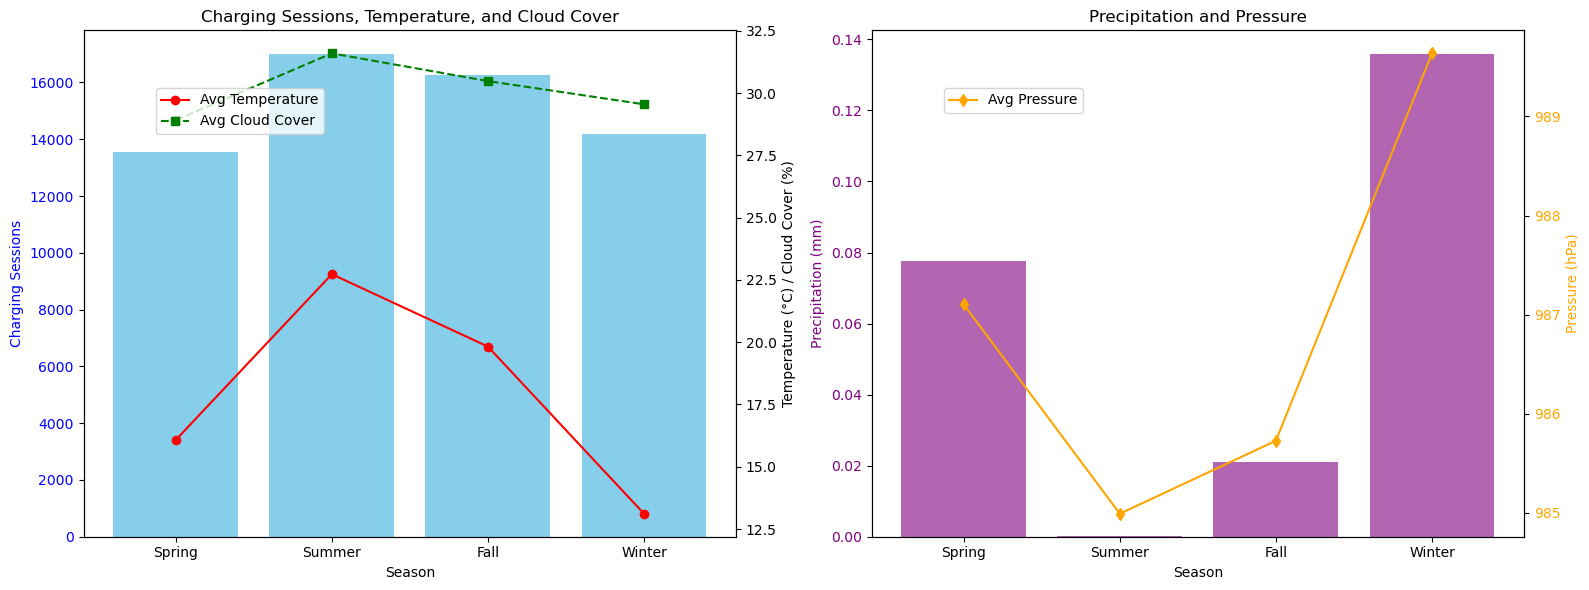

In [40]:
# Assign seasons to weather and charging session data
data_unique['season'] = data_unique['connectionTime'].dt.month.map(get_season)
weather_unique['season'] = weather_unique['timestamp'].dt.month.map(get_season)

# Aggregate Charging Sessions by Season
charging_sessions_by_season = data_unique.groupby('season').size()

# Select only numeric columns for weather data
numeric_weather_cols = weather_unique.select_dtypes(include=['float64', 'int64']).columns

# Aggregate Weather Data by Season (Average for numeric columns only)
weather_by_season = weather_unique.groupby('season')[numeric_weather_cols].mean()

# Combine Charging Sessions and Weather Data
seasonal_data = pd.DataFrame({
    'charging_sessions': charging_sessions_by_season,
    'avg_temperature': weather_by_season['temperature'],
    'avg_cloud_cover': weather_by_season['cloud_cover'],
    'avg_precipitation': weather_by_season['precipitation'],
    'avg_pressure': weather_by_season['pressure']
}).reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- First Plot: Charging Sessions, Temperature, and Cloud Cover ---
ax1.bar(seasonal_data.index, seasonal_data['charging_sessions'], color='skyblue', label='Charging Sessions')
ax1.set_ylabel('Charging Sessions', color='blue')
ax1.set_xlabel('Season')
ax1.tick_params(axis='y', labelcolor='blue')

# Add Secondary Axis for Temperature and Cloud Cover
ax1_2 = ax1.twinx()
ax1_2.plot(seasonal_data.index, seasonal_data['avg_temperature'], color='red', marker='o', label='Avg Temperature')
ax1_2.plot(seasonal_data.index, seasonal_data['avg_cloud_cover'], color='green', marker='s', linestyle='--', label='Avg Cloud Cover')
ax1_2.set_ylabel('Temperature (°C) / Cloud Cover (%)', color='black')
ax1_2.tick_params(axis='y', labelcolor='black')

ax1.set_title('Charging Sessions, Temperature, and Cloud Cover')
ax1_2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# --- Second Plot: Precipitation and Pressure ---
ax2.bar(seasonal_data.index, seasonal_data['avg_precipitation'], color='purple', alpha=0.6, label='Avg Precipitation')
ax2.set_ylabel('Precipitation (mm)', color='purple')
ax2.set_xlabel('Season')
ax2.tick_params(axis='y', labelcolor='purple')

# Add Secondary Axis for Pressure
ax2_2 = ax2.twinx()
ax2_2.plot(seasonal_data.index, seasonal_data['avg_pressure'], color='orange', marker='d', label='Avg Pressure')
ax2_2.set_ylabel('Pressure (hPa)', color='orange')
ax2_2.tick_params(axis='y', labelcolor='orange')

ax2.set_title('Precipitation and Pressure')
ax2_2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Heatmaps for analyzing the daily connection and disconnection times categorized by seasons.

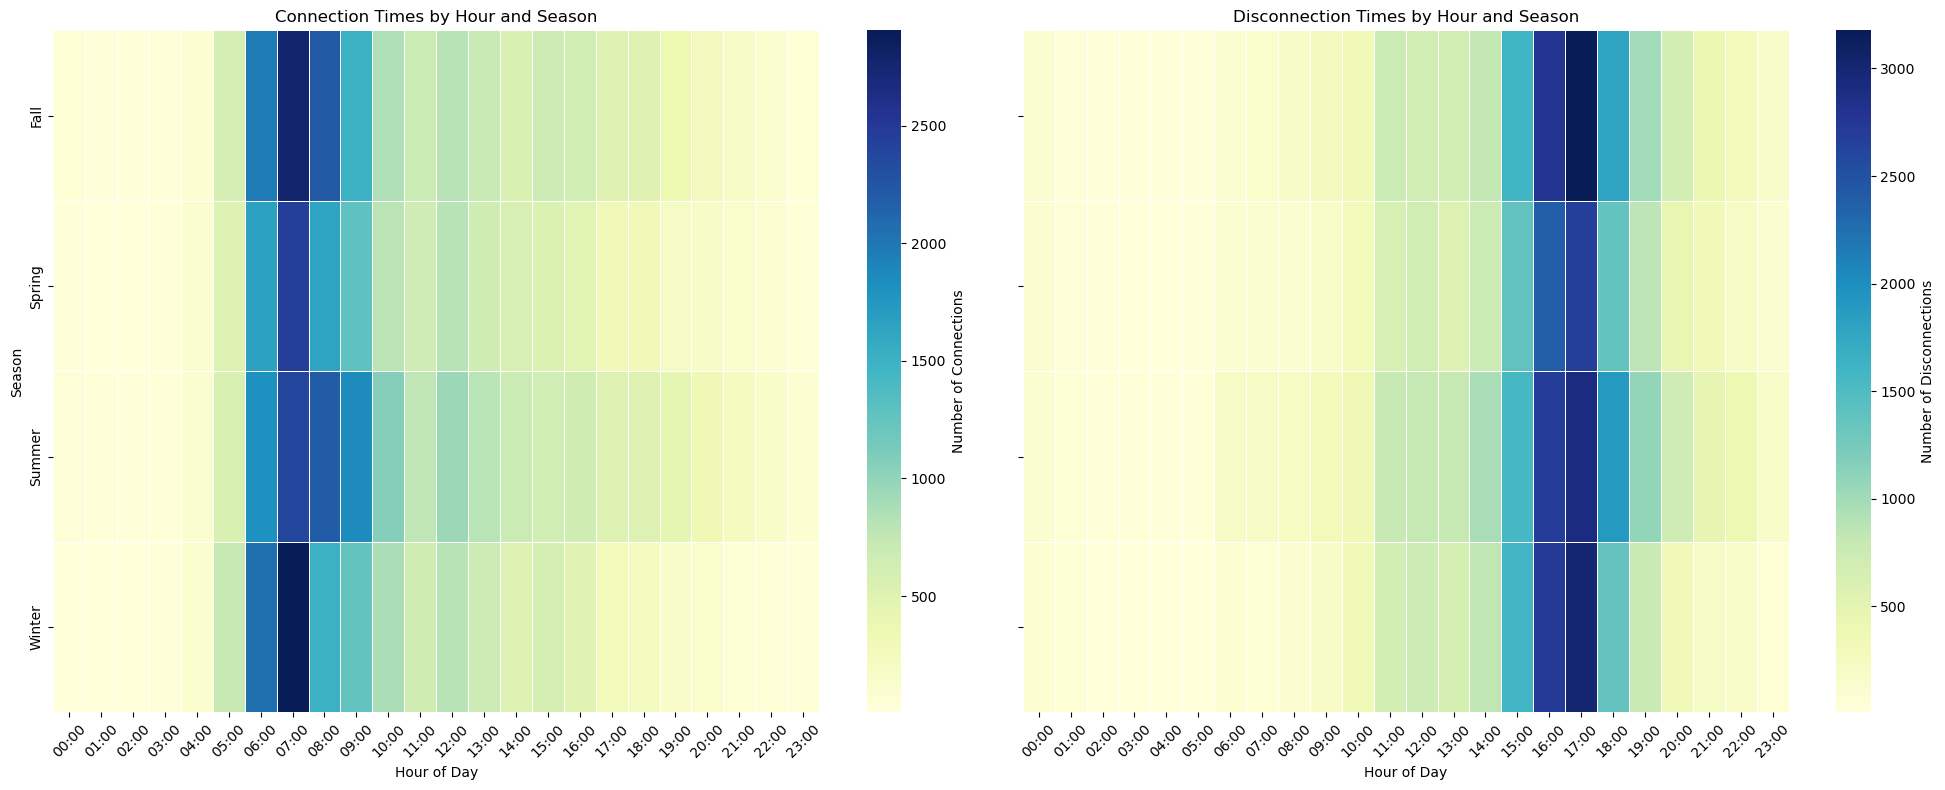

In [41]:
# Map months to seasons
data_unique['season'] = data_unique['connectionTime'].dt.month.map(get_season)
data_unique['connection_hour'] = data_unique['connectionTime'].dt.hour
data_unique['disconnection_hour'] = data_unique['disconnectTime'].dt.hour

# Create pivot tables for the heatmaps
connection_heatmap_data = data_unique.pivot_table(
    index='season', 
    columns='connection_hour', 
    values='connectionTime', 
    aggfunc='count', 
    fill_value=0
)

disconnection_heatmap_data = data_unique.pivot_table(
    index='season', 
    columns='disconnection_hour', 
    values='disconnectTime', 
    aggfunc='count', 
    fill_value=0
)

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Connection Time Heatmap
sns.heatmap(
    connection_heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    fmt="d", 
    linewidths=0.5, 
    cbar_kws={'label': 'Number of Connections'}, 
    ax=axes[0]
)
axes[0].set_title('Connection Times by Hour and Season')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Season')
axes[0].set_xticks(np.arange(24) + 0.5)
axes[0].set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45)

# Disconnection Time Heatmap
sns.heatmap(
    disconnection_heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    fmt="d", 
    linewidths=0.5, 
    cbar_kws={'label': 'Number of Disconnections'}, 
    ax=axes[1]
)
axes[1].set_title('Disconnection Times by Hour and Season')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')  # Remove duplicate ylabel
axes[1].set_xticks(np.arange(24) + 0.5)
axes[1].set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

The analysis of seasonal patterns reveals that the distribution of charging sessions varies across seasons. Charging sessions are most frequent in summer and fall, while winter and spring see the lowest activity levels. Further analysis indicates that this behavior correlates with weather factors: high temperatures and cloudy skies show a positive correlation with charging sessions, while precipitation and pressure have a negative correlation.

A potential hypothesis to explain this pattern is that people engage in more outdoor activities during summer and fall, leading to increased vehicle usage and a greater need for charging.

Moreover, connection and disconnection times are slightly more spread out during the summer compared to other seasons. This suggests a higher level of activity and flexibility in people’s schedules during the summer months. This seasonal variation in behavior highlights the importance of considering both weather conditions and human activity patterns when analyzing charging infrastructure usage.

### **Key Performance Indicators (KPIs)**

First we need to filter Days in both Site IDs with 0 Charging Sessions and analyze whether the parking lot was closed or simply not used.

In [42]:
# Filter data for SiteID 1 and SiteID 2
data_kpi1_site_1 = data_with_NA[data_with_NA['siteID'] == 1].copy()
data_kpi1_site_2 = data_with_NA[data_with_NA['siteID'] == 2].copy()

# Convert time columns to date format, if not already converted
data_kpi1_site_1['connectionDate'] = data_kpi1_site_1['connectionTime'].dt.date
data_kpi1_site_1['disconnectDate'] = data_kpi1_site_1['disconnectTime'].dt.date

data_kpi1_site_2['connectionDate'] = data_kpi1_site_2['connectionTime'].dt.date
data_kpi1_site_2['disconnectDate'] = data_kpi1_site_2['disconnectTime'].dt.date

# Determine the minimum and maximum date for SiteID 1
min_date_1 = min(data_kpi1_site_1['connectionDate'].min(), data_kpi1_site_1['disconnectDate'].min())
max_date_1 = max(data_kpi1_site_1['connectionDate'].max(), data_kpi1_site_1['disconnectDate'].max())

# Determine the minimum and maximum date for SiteID 2
min_date_2 = min(data_kpi1_site_2['connectionDate'].min(), data_kpi1_site_2['disconnectDate'].min())
max_date_2 = max(data_kpi1_site_2['connectionDate'].max(), data_kpi1_site_2['disconnectDate'].max())

# Create a complete list of all days in the range for SiteID 1
all_days_1 = pd.date_range(start=min_date_1, end=max_date_1).date

# Create a complete list of all days in the range for SiteID 2
all_days_2 = pd.date_range(start=min_date_2, end=max_date_2).date

# Find all days with at least one charging session for SiteID 1
active_days_1 = pd.concat([data_kpi1_site_1['connectionDate'], data_kpi1_site_1['disconnectDate']]).unique()

# Find all days with at least one charging session for SiteID 2
active_days_2 = pd.concat([data_kpi1_site_2['connectionDate'], data_kpi1_site_2['disconnectDate']]).unique()

# Identify days without any charging sessions for SiteID 1
inactive_days_1 = set(all_days_1) - set(active_days_1)

# Identify days without any charging sessions for SiteID 2
inactive_days_2 = set(all_days_2) - set(active_days_2)

# Function to identify consecutive days without charging sessions
def find_consecutive_days(inactive_days_sorted):
    # Convert the sorted days into a DataFrame
    df = pd.DataFrame({"date": inactive_days_sorted})
    df['diff'] = df['date'].diff().dt.days  # Calculate the difference in days

    consecutive_days = []  # List to store consecutive day sequences
    current_streak = []    # Temporary list to store the current streak of consecutive days

    for i, row in df.iterrows():
        if i > 0 and row['diff'] == 1:  # If the difference between two days is 1
            current_streak.append(row['date'])  # Add the day to the current streak
        else:
            if current_streak:  # If a streak ends
                consecutive_days.append(current_streak)  # Append the current streak to the list
                current_streak = []  # Reset the current streak
            current_streak.append(row['date'])  # Start a new streak

    # Add the last streak if it exists
    if current_streak:
        consecutive_days.append(current_streak)

    return consecutive_days

# Sort the days
inactive_days_sorted_1 = sorted(inactive_days_1)
inactive_days_sorted_2 = sorted(inactive_days_2)

# Find longer streaks for both sites
long_streaks_1 = find_consecutive_days(inactive_days_sorted_1)
long_streaks_2 = find_consecutive_days(inactive_days_sorted_2)

# Print long periods without parking guests
print("Longer Periods of consecutive days without charging sessions (Site 1):")
for streak in long_streaks_1:
    if len(streak) > 2:  # Only print if streak is longer than 2 days
        print(f"{streak[0]} to {streak[-1]} ({len(streak)} days)")

print("\nLonger Periods of consecutive days without charging sessions (Site 2):")
for streak in long_streaks_2:
    if len(streak) > 2:  # Only print if streak is longer than 2 days
        print(f"{streak[0]} to {streak[-1]} ({len(streak)} days)")

# Streaks of more than 7 days without a parking guest are considered as closed 
streaks_longer_than_7_1 = [streak for streak in long_streaks_1 if len(streak) > 7]
streaks_longer_than_7_2 = [streak for streak in long_streaks_2 if len(streak) > 7]

# Sum the length of the streaks longer than 7 days. These are the number of days where the sites were closed
sum_long_streaks_1 = sum(len(streak) for streak in streaks_longer_than_7_1)
sum_long_streaks_2 = sum(len(streak) for streak in streaks_longer_than_7_2)

# Print the long streaks length (just for reference)
print(f"\nTotal number of days in streaks > 7 days (Site 1): {sum_long_streaks_1}")
print(f"Total number of days in streaks > 7 days (Site 2): {sum_long_streaks_2}")

# Remove the days from the inactive days that are part of streaks longer than 7 days as here site isconsidered  as closed
def remove_long_streaks(inactive_days, long_streaks, threshold=7):
    # Create a set of days to remove
    days_to_remove = set()
    for streak in long_streaks:
        if len(streak) > threshold:
            days_to_remove.update(streak)

    # Remove the days from the list
    updated_inactive_days = [day for day in inactive_days if day not in days_to_remove]
    return updated_inactive_days

# Remove the long streaks from the inactive days
inactive_days_siteid_1 = remove_long_streaks(inactive_days_1, long_streaks_1)
inactive_days_siteid_2 = remove_long_streaks(inactive_days_2, long_streaks_2)

# Output the updated inactive days
print("\nNumber of considered incative days for Site 1 after removing streaks >7:")
print(len(inactive_days_siteid_1))
print("\nNumber of considered incative days for Site 2 after removing long streaks >7:")
print(len(inactive_days_siteid_2))


Longer Periods of consecutive days without charging sessions (Site 1):
2020-05-23 to 2020-05-25 (3 days)
2020-08-04 to 2020-11-17 (106 days)
2021-07-23 to 2021-07-27 (5 days)

Longer Periods of consecutive days without charging sessions (Site 2):
2020-04-15 to 2020-04-17 (3 days)
2020-04-30 to 2020-05-03 (4 days)
2020-05-05 to 2020-05-08 (4 days)
2020-05-21 to 2020-05-25 (5 days)
2020-08-04 to 2020-11-17 (106 days)

Total number of days in streaks > 7 days (Site 1): 106
Total number of days in streaks > 7 days (Site 2): 106

Number of considered incative days for Site 1 after removing streaks >7:
44

Number of considered incative days for Site 2 after removing long streaks >7:
46


We assume that if there are more than 7 consecutive days without any guests, the site was closed during that period. For example, between 2020-08-04 and 2020-11-17, both sites experienced no parking activity, which we interpret as the site being closed for 106 days. If we have less than or equal to 7 consecutive days without guests, we assume that the parking lot was open but not used.

#### 1. Utilization Rate of Parking Spaces
Definition: The utilization rate of parking spaces represents the percentage of parking spaces that are occupied per hour, on average. It reflects the overall usage of the charging station over a given period, indicating how efficiently the parking spaces are utilized.


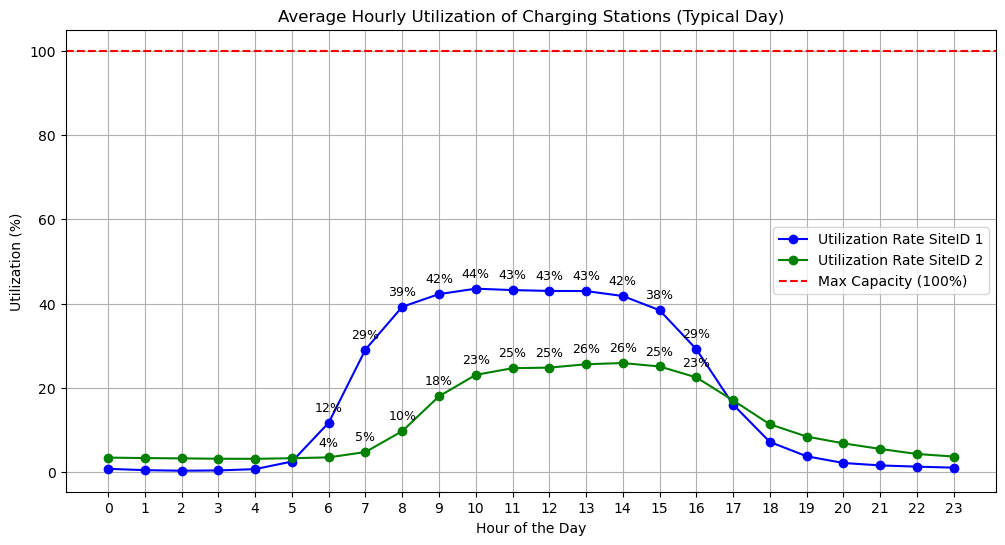

In [43]:
# Function to calculate hourly utilization for a given siteID
def calculate_utilization(site_id, data_with_NA, siteid_inactivedays, active_days):
    
    # Filter data for the specified siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Parameters
    num_stations = data_kpi['stationID'].nunique()  # Number of unique charging stations

    # Create a list of hourly activity data
    hourly_data = []

    for _, row in data_kpi.iterrows():
        start = row['connectionTime']
        end = row['disconnectTime']
        
        current = start
        while current < end:
            next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
            if next_hour > end:  
                next_hour = end
            
            # calculate duration of current hour
            duration_in_hour = (next_hour - current).total_seconds() / 3600  # Stunden
            
            hourly_data.append({
                'hour': current.replace(minute=0, second=0, microsecond=0),
                'active_charging': duration_in_hour  
            })
            
            current = next_hour 

    # Create DataFrame for the hourly usage data
    hourly_df = pd.DataFrame(hourly_data)

    hourly_df['hour'] = hourly_df['hour'].dt.hour

    # Calculate the total hourly usage per day
    avg_hourly_usage = hourly_df.groupby('hour')['active_charging'].sum().reset_index()

    # Calculate the utilization rate, using the unique connection dates in hourly_usage for the denominator
    avg_hourly_usage['utilization_rate'] = (avg_hourly_usage['active_charging'] / (len(siteid_inactivedays)+len(active_days)) / num_stations) * 100

    return avg_hourly_usage

# Calculate utilization for siteID 1
avg_hourly_usage_1 = calculate_utilization(1, data_with_NA,inactive_days_siteid_1,active_days_1)

# Calculate utilization for siteID 2
avg_hourly_usage_2 = calculate_utilization(2, data_with_NA,inactive_days_siteid_2,active_days_2)

# Visualization
plt.figure(figsize=(12, 6))

# Plot utilization for siteID 1
plt.plot(avg_hourly_usage_1['hour'], avg_hourly_usage_1['utilization_rate'], marker='o', label='Utilization Rate SiteID 1', color='blue')

# Plot utilization for siteID 2
plt.plot(avg_hourly_usage_2['hour'], avg_hourly_usage_2['utilization_rate'], marker='o', label='Utilization Rate SiteID 2', color='green')

# Add horizontal line for max capacity (100%)
plt.axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')

# Title and labels
plt.title('Average Hourly Utilization of Charging Stations (Typical Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization (%)')

# Set X-axis to display each hour from 0 to 23
plt.xticks(range(24))

for i, row in avg_hourly_usage_1.iterrows():
    if 6 <= row['hour'] <= 16:  # Check if the hour is between 6 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2.iterrows():
    if 6 <= row['hour'] <= 16:  # Check if the hour is between 6 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Grid and legend
plt.grid()
plt.legend()

# Show the plot
plt.show()

Key observations:

+  SiteID 1 (blue line): Shows higher utilization rates, peaking at around 44% during the late morning (11:00 AM) and remaining steady until mid-afternoon before declining in the evening.

+  SiteID 2 (green line): Displays lower utilization rates overall, peaking at around 26% during the afternoon (3:00 PM) and gradually declining afterward.

Conclusion:
SiteID 1 has significantly higher usage throughout the day, indicating a higher demand for charging, while SiteID 2 remains underutilized, reflecting either lower demand or fewer active vehicles. Both sites stay far below maximum capacity (100%).

Now we are going to take a closer look at peak utilization days of the parking spaces to determine wether the sites are always "underused" or also have days of high utilization.

In [44]:
from decimal import Decimal

# Funktion zur Berechnung der stündlichen Auslastung für eine gegebene siteID und Rückgabe einer detaillierten Tabelle
def calculate_utilization_table(site_id, data_with_NA, siteid_inactivedays, active_days):
    # Filtere die Daten für die angegebene siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Parameter
    num_stations = data_kpi['stationID'].nunique()  # Anzahl der einzigartigen Ladestationen

    # Liste der stündlichen Aktivitätsdaten erstellen
    hourly_data = []

    for _, row in data_kpi.iterrows():
        start = row['connectionTime']
        end = row['disconnectTime']
        
        current = start
        while current < end:
            next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
            if next_hour > end:  
                next_hour = end
            
            # Berechne die Dauer der aktuellen Stunde
            duration_in_hour = (next_hour - current).total_seconds() / 3600  # Stunden
            
            hourly_data.append({
                'date': current.date(),
                'hour': current.hour,
                'active_charging': duration_in_hour  
            })
            
            current = next_hour 

    # Erstelle DataFrame für die stündlichen Nutzungsdaten
    hourly_df = pd.DataFrame(hourly_data)

    # Gruppiere nach Datum und Stunde, um die gesamte aktive Ladezeit pro Stunde zu berechnen
    hourly_usage = hourly_df.groupby(['date', 'hour'])['active_charging'].sum().reset_index()

    # Berechne die Auslastungsrate
    hourly_usage['utilization_rate'] = ((hourly_usage['active_charging'] / num_stations) * 100).apply(Decimal)

    return hourly_usage

# Berechne die stündliche Auslastung für Site ID 1
hourly_utilization_1 = calculate_utilization_table(1, data_with_NA, inactive_days_siteid_1, active_days_1)

# Berechne die stündliche Auslastung für Site ID 2
hourly_utilization_2 = calculate_utilization_table(2, data_with_NA, inactive_days_siteid_2, active_days_2)

# Füge die Site-ID zu den Ergebnissen hinzu
hourly_utilization_1['siteID'] = 1
hourly_utilization_2['siteID'] = 2

# Kombiniere die Ergebnisse beider Sites in ein einzelnes DataFrame
hourly_utilization_combined = pd.concat([hourly_utilization_1, hourly_utilization_2], ignore_index=True)

# Zähle die Tage, an denen die Auslastung größer als 80% ist, für jede Stunde und Site
hourly_utilization_combined['high_utilization'] = hourly_utilization_combined['utilization_rate'] > 80

# Gruppiere nach Stunde und Site und zähle die Tage mit hoher Auslastung
high_utilization_counts = hourly_utilization_combined.groupby(['siteID', 'hour'])['high_utilization'].sum().reset_index()

# Zeige das Ergebnis an
high_utilization_counts.rename(columns={'high_utilization': 'days_with_utilization_above_80_percent'}, inplace=True)
high_utilization_counts.sort_values(by=['siteID', 'hour']).reset_index(drop=True)

,siteID,hour,days_with_utilization_above_80_percent
0,1,0,0
1,1,1,0
2,1,2,0
3,1,3,0
4,1,4,0
5,1,5,0
6,1,6,0
7,1,7,122
8,1,8,312
9,1,9,322


It is important to note that this chart represents the average utilization on a "typical day." There are days when the parking lot experiences higher demand. For example, over the observed period of approximately 3 years, Site ID 1 reached a utilization rate of over 80% at 11:00 AM on 324 days, indicating that there are regular occurrences of high demand. In contrast, Site ID 2 saw over 80% utilization at 10:00 AM on 42 days, which is considerably less frequent but still reflects occasional peak usage.


#### 2. Inactive Utilization Rate of Parking Spaces
Definition: The inactive utilization rate of parking spaces indicates the percentage of parking spaces occupied per hour where vehicles are connected to the charging station but are not actively charging. This metric highlights the proportion of time charging stations are used solely for parking, rather than for charging, reflecting inefficiencies in station utilization.

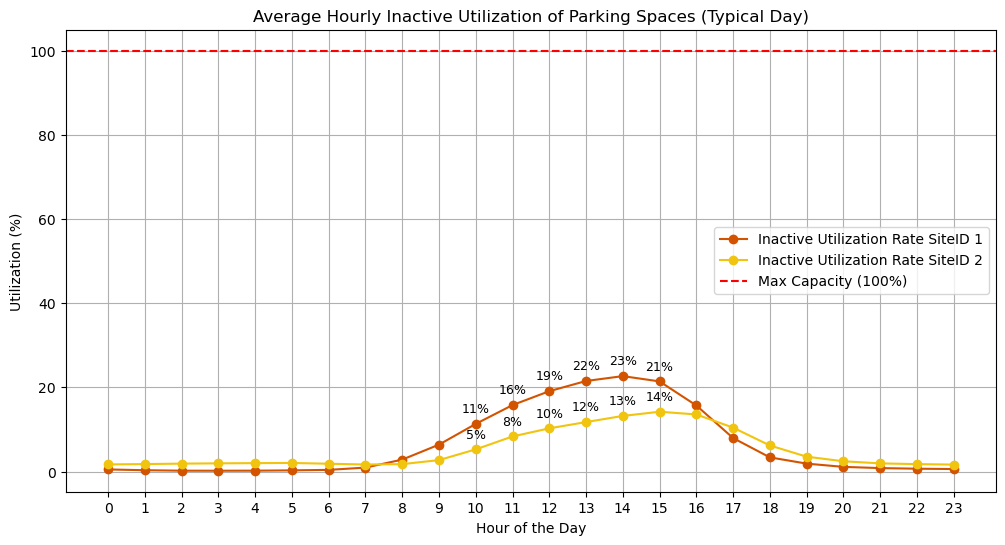

In [45]:
# Function to calculate hourly inactive utilization for a given siteID
def calculate_inactive_utilization(site_id, data_with_NA,inactive_days,active_days):

    # Filter data for the specified siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Parameters
    num_spaces = data_kpi['stationID'].nunique()  # Number of unique parking spaces

    # Create a list of hourly activity data for inactive (unoccupied) parking
    hourly_data = []

    # Iterate through each row in the dataset
    for _, row in data_kpi.iterrows():
        
        # Check if doneParkingTime is not NaT and disconnectTime > doneParkingTime
        if pd.notna(row['doneChargingTime']) and row['disconnectTime'] > row['doneChargingTime']:
            start = row['doneChargingTime']
            end = row['disconnectTime']
            
            current = start
            while current < end:
                next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
                if next_hour > end:  
                    next_hour = end
                
                # calculate duration of current hour
                duration_in_hour = (next_hour - current).total_seconds() / 3600  # Stunden
                
                hourly_data.append({
                    'hour': current.replace(minute=0, second=0, microsecond=0),
                    'inactive_utilization': duration_in_hour  
                })
                
                current = next_hour 

    # Create DataFrame for the hourly usage data
    hourly_df = pd.DataFrame(hourly_data)

    hourly_df['hour'] = hourly_df['hour'].dt.hour

    # Calculate the total hourly usage per day (inactive utilization)
    avg_hourly_usage = hourly_df.groupby('hour')['inactive_utilization'].sum().reset_index()

    # Calculate the utilization rate, using the unique parking dates for the denominator
    avg_hourly_usage['utilization_rate'] = (avg_hourly_usage['inactive_utilization'] / (len(inactive_days)+len(active_days)) / num_spaces) * 100

    return avg_hourly_usage

# Calculate inactive utilization for siteID 1
avg_hourly_usage_1_inactive = calculate_inactive_utilization(1, data_with_NA,inactive_days_1,active_days_1)

# Calculate inactive utilization for siteID 2
avg_hourly_usage_2_inactive = calculate_inactive_utilization(2, data_with_NA, inactive_days_2,active_days_2)

# Visualization
plt.figure(figsize=(12, 6))

# Plot inactive utilization for siteID 1
plt.plot(avg_hourly_usage_1_inactive['hour'], avg_hourly_usage_1_inactive['utilization_rate'], marker='o', label='Inactive Utilization Rate SiteID 1', color='#D35400')

# Plot inactive utilization for siteID 2
plt.plot(avg_hourly_usage_2_inactive['hour'], avg_hourly_usage_2_inactive['utilization_rate'], marker='o', label='Inactive Utilization Rate SiteID 2', color='#F1C40F')

# Add horizontal line for max capacity (100%)
plt.axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')

# Title and labels
plt.title('Average Hourly Inactive Utilization of Parking Spaces (Typical Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization (%)')

# Set X-axis to display each hour from 0 to 23
plt.xticks(range(24))

# Add percentage values above each point on the graph, but only for hours 7 to 16
for i, row in avg_hourly_usage_1_inactive.iterrows():
    if 10 <= row['hour'] <= 15:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2_inactive.iterrows():
    if 10 <= row['hour'] <= 15:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Grid and legend
plt.grid()
plt.legend()

# Show the plot
plt.show()

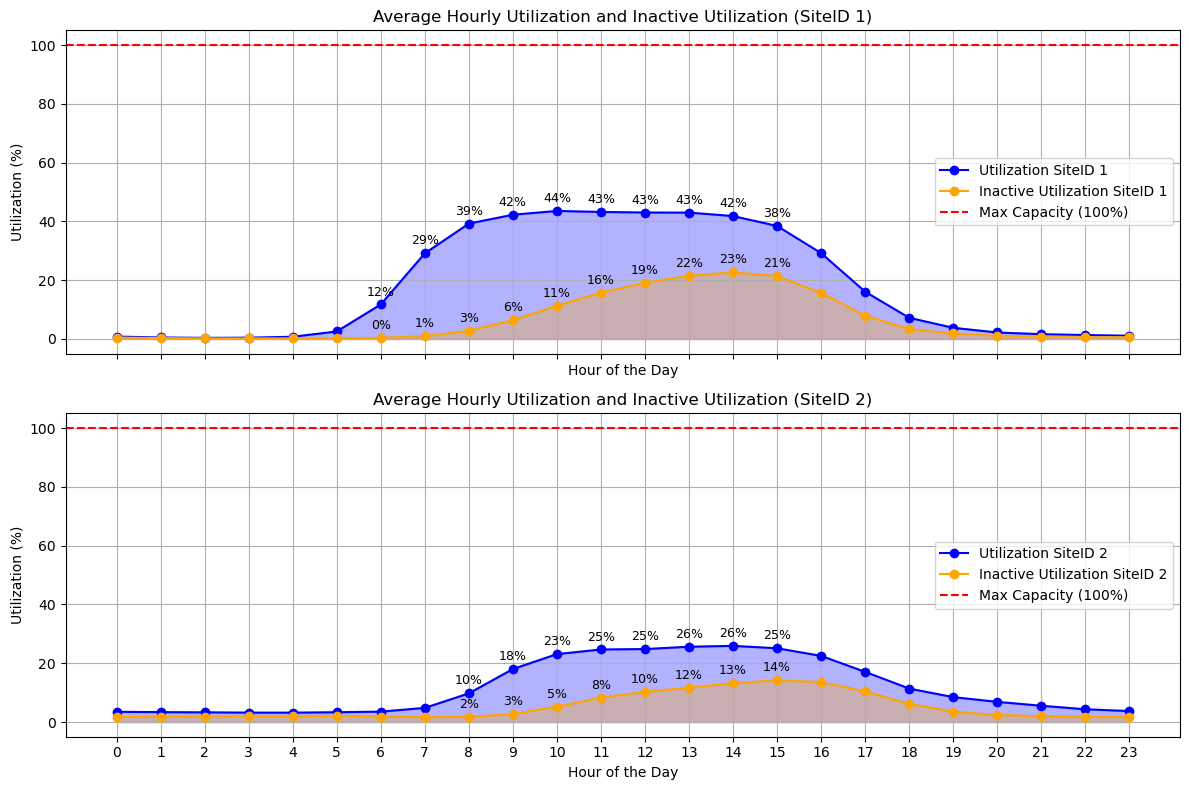

In [46]:
# Create subplots: One for SiteID 1 and one for SiteID 2
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for SiteID 1
axs[0].plot(avg_hourly_usage_1['hour'], avg_hourly_usage_1['utilization_rate'], marker='o', label='Utilization SiteID 1', color='blue')
axs[0].plot(avg_hourly_usage_1_inactive['hour'], avg_hourly_usage_1_inactive['utilization_rate'], marker='o', label='Inactive Utilization SiteID 1', color='orange')

# Fill the area under the active utilization curve for SiteID 1
axs[0].fill_between(avg_hourly_usage_1['hour'], 0, avg_hourly_usage_1['utilization_rate'], color='blue', alpha=0.3)
# Fill the area under the inactive utilization curve for SiteID 1
axs[0].fill_between(avg_hourly_usage_1_inactive['hour'], 0, avg_hourly_usage_1_inactive['utilization_rate'], color='orange', alpha=0.3)

# Title and labels for SiteID 1
axs[0].set_title('Average Hourly Utilization and Inactive Utilization (SiteID 1)')
axs[0].set_ylabel('Utilization (%)')  # Ensure ylabel is on the upper plot
axs[0].set_xlabel('Hour of the Day')
axs[0].axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')  # Max capacity line

# Add percentage values above each point on the graph, but only for hours 10 to 16
for i, row in avg_hourly_usage_1.iterrows():
    if 6 <= row['hour'] <= 15:
        axs[0].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_1_inactive.iterrows():
    if 6 <= row['hour'] <= 15:
        axs[0].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Plot for SiteID 2
axs[1].plot(avg_hourly_usage_2['hour'], avg_hourly_usage_2['utilization_rate'], marker='o', label='Utilization SiteID 2', color='blue')
axs[1].plot(avg_hourly_usage_2_inactive['hour'], avg_hourly_usage_2_inactive['utilization_rate'], marker='o', label='Inactive Utilization SiteID 2', color='orange')

# Fill the area under the active utilization curve for SiteID 2
axs[1].fill_between(avg_hourly_usage_2['hour'], 0, avg_hourly_usage_2['utilization_rate'], color='blue', alpha=0.3)
# Fill the area under the inactive utilization curve for SiteID 2
axs[1].fill_between(avg_hourly_usage_2_inactive['hour'], 0, avg_hourly_usage_2_inactive['utilization_rate'], color='orange', alpha=0.3)

# Title and labels for SiteID 2
axs[1].set_title('Average Hourly Utilization and Inactive Utilization (SiteID 2)')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Utilization (%)')  # Make sure the ylabel is also on the second plot
axs[1].axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')  # Max capacity line

# Add percentage values above each point on the graph, but only for hours 8 to 16
for i, row in avg_hourly_usage_2.iterrows():
    if 8 <= row['hour'] <= 15:
        axs[1].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2_inactive.iterrows():
    if 8 <= row['hour'] <= 15:
        axs[1].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Set X-axis to display each hour from 0 to 23
axs[1].set_xticks(range(24))

# Grid and legend for both subplots
axs[0].grid(True)
axs[1].grid(True)

axs[0].legend(loc='center right')
axs[1].legend(loc='center right')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

An interesting observation is the noticeably high proportion of vehicles that remain connected to the charging stations without further charging. This idle time suggests a significant number of vehicles occupy charging spots even after the charging process has been completed, highlighting an opportunity to improve the overall efficiency of the charging infrastructure.

However, at present, this idle time after charging does not pose a significant problem, as the overall utilization remains low. The available charging capacity is not being fully utilized, so there is no immediate concern regarding limited access for other vehicles in need of charging. Nonetheless, addressing this inefficiency could enhance the capacity and accessibility of the stations in the future.

#### 3. Average kWh Delivered
Definition: The Average kWh Delivered shows the average amount of energy, in kilowatt-hours (kWh), delivered to electric vehicles across the entire site each hour. This metric helps identify peak demand times, indicating when most energy is needed/delivered, and provides insights into the overall energy usage patterns throughout the day.

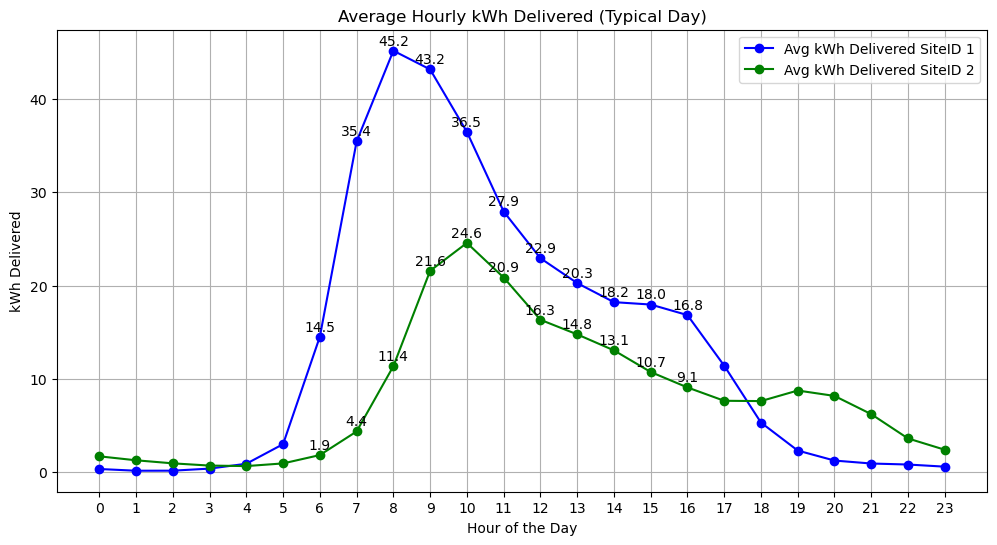

In [47]:
def calculate_kwh_delivered(site_id, data_with_NA, siteid_inactivedays, active_days):
    
    # Filter data for the specified siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Create a list of hourly kWh delivery data
    hourly_data = []

    for _, row in data_kpi.iterrows():
        start = row['connectionTime']
        end = row['doneChargingTime']
        total_energy = row['kWhDelivered']  # Total kWh delivered during the session
        
        current = start
        while current < end:
            next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
            if next_hour > end:  
                next_hour = end
            
            # Calculate the proportion of energy delivered in the current hour
            duration_in_hour = (next_hour - current).total_seconds() / (end - start).total_seconds()
            energy_in_hour = total_energy * duration_in_hour
            
            hourly_data.append({
                'hour': current.replace(minute=0, second=0, microsecond=0),
                'energy_delivered': energy_in_hour
            })
            
            current = next_hour 

    # Create DataFrame for the hourly kWh data
    hourly_df = pd.DataFrame(hourly_data)

    # Extract the hour of the day
    hourly_df['hour'] = hourly_df['hour'].dt.hour

    # Calculate the total kWh delivered per hour
    avg_hourly_kwh = hourly_df.groupby('hour')['energy_delivered'].sum().reset_index()

    # Calculate the average kWh delivered per hour, normalized by the number of active days
    avg_hourly_kwh['avg_kwh'] = avg_hourly_kwh['energy_delivered'] / (len(siteid_inactivedays) + len(active_days))

    return avg_hourly_kwh

# Calculate average kWh delivered for siteID 1
avg_hourly_kwh_1 = calculate_kwh_delivered(1, data_unique, inactive_days_siteid_1, active_days_1)

# Calculate average kWh delivered for siteID 2
avg_hourly_kwh_2 = calculate_kwh_delivered(2, data_unique, inactive_days_siteid_2, active_days_2)

# Visualization
plt.figure(figsize=(12, 6))

# Plot kWh delivered for siteID 1
plt.plot(avg_hourly_kwh_1['hour'], avg_hourly_kwh_1['avg_kwh'], marker='o', label='Avg kWh Delivered SiteID 1', color='blue')

# Plot kWh delivered for siteID 2
plt.plot(avg_hourly_kwh_2['hour'], avg_hourly_kwh_2['avg_kwh'], marker='o', label='Avg kWh Delivered SiteID 2', color='green')

# Title and labels
plt.title('Average Hourly kWh Delivered (Typical Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('kWh Delivered')

# Set X-axis to display each hour from 0 to 23
plt.xticks(range(24))

# Annotate kWh values for specific hours (e.g., between 6 and 16)
for i, row in avg_hourly_kwh_1.iterrows():
    if 6 <= row['hour'] <= 16:  
        plt.text(row['hour'], row['avg_kwh'] + 0.3, 
                 f'{row["avg_kwh"]:.1f}', ha='center', va='bottom', fontsize=10)

for i, row in avg_hourly_kwh_2.iterrows():
    if 6 <= row['hour'] <= 16:  
        plt.text(row['hour'], row['avg_kwh'] + 0.3,
                 f'{row["avg_kwh"]:.1f}', ha='center', va='bottom', fontsize=10)
        
# Grid and legend
plt.grid()
plt.legend()

# Show the plot
plt.show()

The graph shows the average hourly kWh delivered for two sites on a typical day:

* SiteID 1 (blue line): Energy usage at the company's parking lot starts to rise significantly at 6 AM, peaks sharply at 8 AM (45.2 kWh), and gradually decreases throughout the day, with a smaller peak at 4 PM (18 kWh), likely corresponding to employees leaving work. Usage drops significantly after 5 PM, reaching minimal levels in the late evening.

* SiteID 2 (green line): The public parking lot near the university has a more gradual increase in energy usage, starting at 7 AM, peaking between 10 AM and 11 AM (24.6 kWh), and tapering off through the afternoon and evening. It stabilizes at a low level after 8 PM.

Interpretation:
* SiteID 1: Reflects a typical workday pattern. The morning peak corresponds to employees arriving at work, while the smaller afternoon peak is related to departure.
* SiteID 2: The university parking lot shows consistent activity throughout the day, with a peak mid-morning likely due to lectures and activities. Evening activity decreases as students and staff leave.

This comparison highlights the differing energy consumption patterns based on the primary user group and their daily routines.










###  **Site Characteristics: Identifying the Public Charging Hub**

In this section, we aim to determine which of the two sites is the public charging hub. By analyzing the provided data and combining insights from previous descriptive analytics with domain knowledge of how private company parking (reserved for employees) and public university charging stations typically operate, we will evaluate key characteristics to distinguish between the two sites.

We have a look at different criteria to make our decision:

- Time distribution
- User diversity
- Session duration

First we take a closer look at the stations. We want to know exactly how many charging stations are in the garages.

In [48]:
def count_stations_per_site(df):
    """
    Count the number of unique stations per site.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'stationID' and 'siteID' columns.

    Returns:
        pd.Series: Number of unique stations per site.
    """
    if 'stationID' not in df.columns or 'siteID' not in df.columns:
        raise ValueError("The provided DataFrame must contain 'stationID' and 'siteID' columns.")
    
    return df.groupby('siteID')['stationID'].nunique()

# Count unique stations for each site
station_counts = count_stations_per_site(data_unique)
print("Number of unique stations per site:")
print(station_counts)

Number of unique stations per site:
siteID
1    52
2    54
Name: stationID, dtype: int64


There are 52 charging stations in the first garage (site_id=1) and 54 stations in the second garage (site_id=2).

#### **Time distribution**
To better understand how the charging stations are used, we analyze their temporal distribution. This involves examining patterns across days of the week and hours of the day to identify trends and peak usage periods.

We extract the hour of the day and the weekday from the _connectionTime column_ in the dataset. This allows us to examine how usage varies throughout the day and the week. The hour is extracted using `.dt.hour`, while the weekday is derived using `.dt.day_name()`. These new columns enable us to visualize the usage patterns based on time of day and weekday, providing further insights into the site type.

In [49]:
data_1['hour'] = data_1['connectionTime'].dt.hour
data_1['weekday'] = data_1['connectionTime'].dt.day_name()

data_2['hour'] = data_2['connectionTime'].dt.hour
data_2['weekday'] = data_2['connectionTime'].dt.day_name()

**1. Day Of the Week Analysis (weekly distribution):**
This bar chart shows the number of charging events for each day of the week. This will help us understand if there are variations in usage between weekdays and weekends. At the university (public site), we expect higher usage during weekdays, aligning with academic schedules, and possibly lower usage on weekends. At the firm (private site), consistent weekday usage is expected, reflecting employee commutes, with little to no activity on weekends.

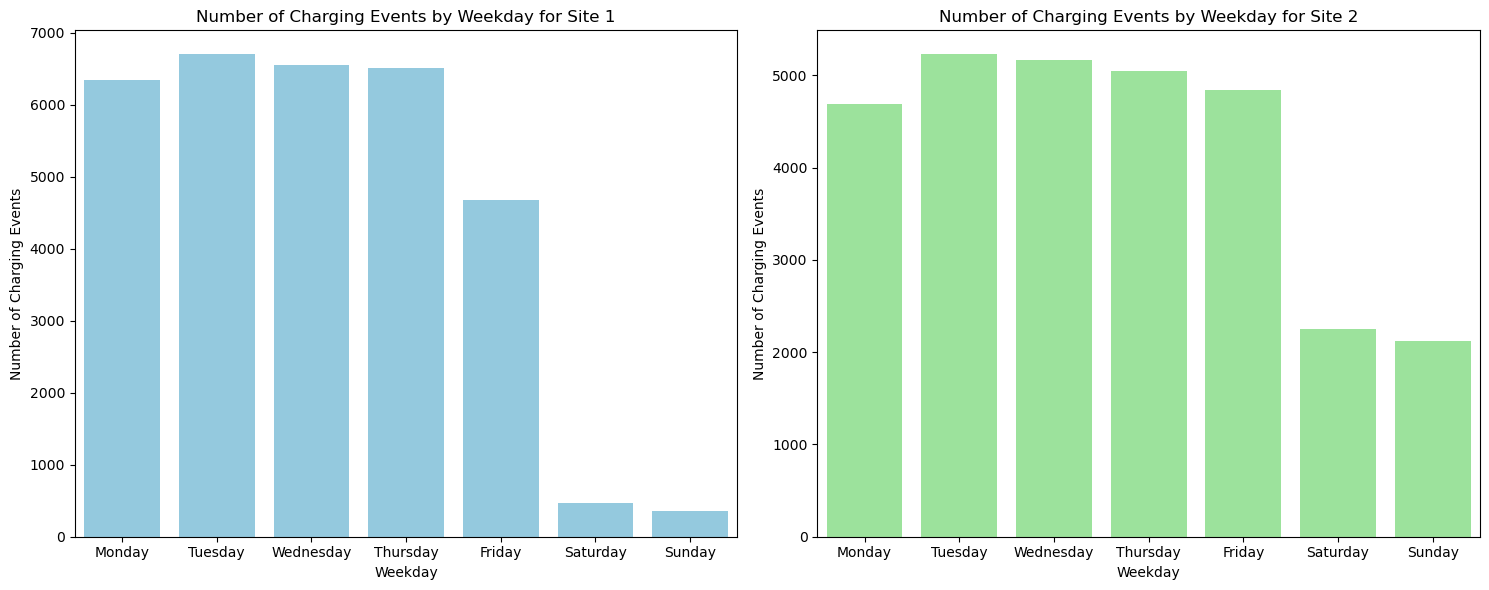

In [50]:
# Bar chart of charging events per weekday

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=data_1, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="skyblue", ax=axes[0])
axes[0].set_title('Number of Charging Events by Weekday for Site 1')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Charging Events')

sns.countplot(data=data_2, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="lightgreen", ax=axes[1])
axes[1].set_title('Number of Charging Events by Weekday for Site 2')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Number of Charging Events')

plt.tight_layout()
plt.show()

Both sites exhibit a general trend of higher usage on weekdays compared to weekends. However, there is a noticeable difference between the two sites. Site 2 shows more usage on weekends compared to Site 1, which aligns with the typical usage pattern for public charging stations. Public sites, like the one near the university, often experience higher demand on weekends, not only from students attending events or studying but also from other visitors who may need to use the public parking garage. In contrast, private sites, such as the company parking garage in Site 1, see much lower usage on weekends, as they are mainly used by employees during the working week. Less than a tenth of the charging sessions take place at weekends. At station 2, the figure is slightly higher. There, the utilization at weekends is about half as high as on a working day.

**2. Time of the Day Analysis (hourly distribution):**
This histogram visualizes the number of charging events for each hour of the day. The x-axis represents the hours (0 to 23), and the y-axis shows the total number of charging events that occurred during each hour. This visualization helps us identify peak usage times throughout the day, which can provide insights into typical charging patterns.

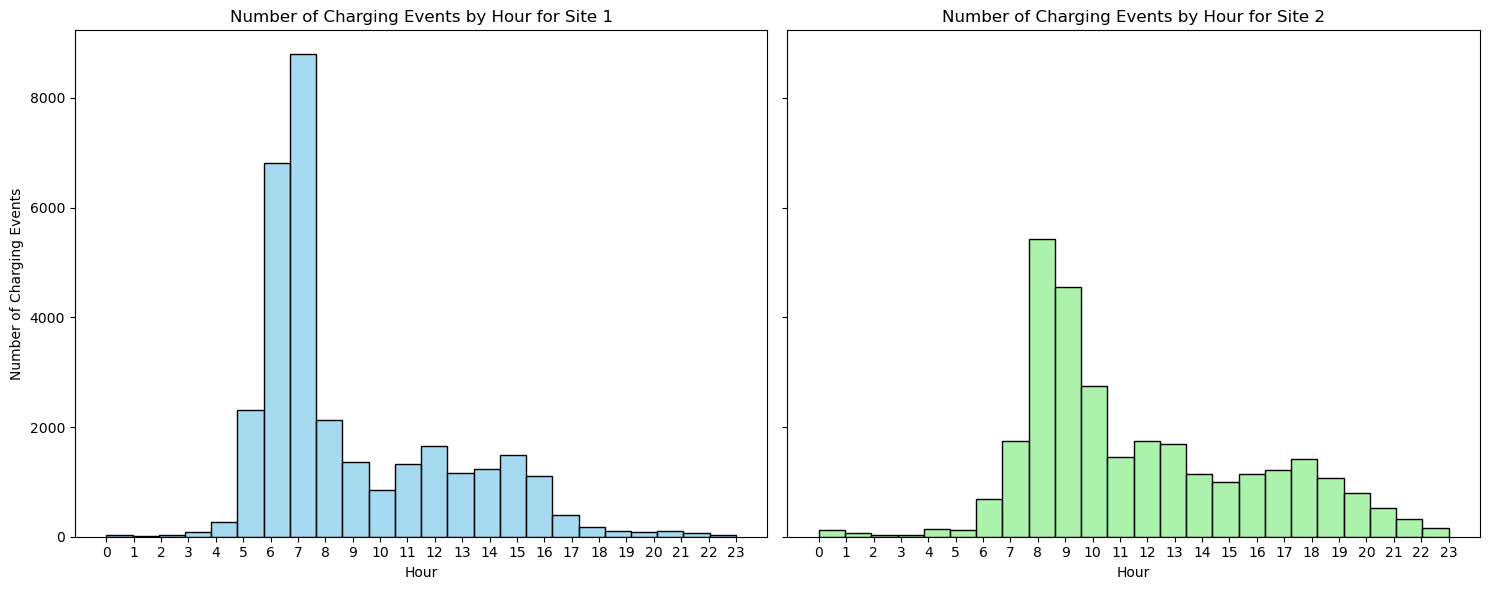

In [51]:
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey=True)

sns.histplot(data=data_1, x='hour', bins=24, color="skyblue", ax=axes[0])

# Histogram of charging events per hour with full hours on the X-axis
#site 1
axes[0].set_title('Number of Charging Events by Hour for Site 1')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Number of Charging Events')
axes[0].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  


sns.histplot(data=data_2, x='hour', bins=24, color="lightgreen", ax=axes[1])

axes[1].set_title('Number of Charging Events by Hour for Site 2')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Charging Events')
axes[1].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  

plt.tight_layout()
plt.show()

If you look at the utilization for the specific times of the day, you can see patterns. For Site 1, there are clear peaks at **6:00 and 7:00 AM**, while the peaks for Site 2 are not so extreme and are at **8:00 and 9:00 AM**. respectively. 

For Site 1, the charging events primarily occur from around **5:00 AM to 5:00 PM**, with a significant decline in usage afterward. This pattern suggests that the site is most heavily used during business hours, which is often characteristic of sites serving a more specific user group, such as employees of a company.

In contrast, for Site 2, the charging events occur throughout a longer period, from approximately **6:00 AM to 11:00 PM**. This extended period of usage may indicate that the site is open to a broader range of users, with charging events spanning both daytime and evening hours, which is a typical feature of public charging hubs.

&#8594;
These insights strongly suggest that Site 2 is the public charging station, likely located at the university, while Site 1 is the private company parking garage, as the usage pattern matches the expected behavior for these types of locations.

#### **User Count and Diversity**

In this step, we aim to determine whether the site is primarily used by repeat users or a diverse range of users. A public site is expected to have a higher number of unique users, as it serves a broader, more varied group. In contrast, a private site, like a company parking garage, might show repeated usage by the same set of users, as it is typically restricted to employees or specific individuals.

First, we count the unique user IDs (`userID`) for each site and determine the number of missing values in the userID column.

In [52]:
# Count the unique userIDs for siteID 1
unique_users_per_site_1 = data_1['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for Site 1: {unique_users_per_site_1}")

# Count the missing values in the 'userID' column
missing_values_userID_1 = data_1['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 1: {missing_values_userID_1}")


Number of unique (distinct) userIDs for Site 1: 511
Number of missing values in 'userID' for Site 1: 1433


In [53]:
# Count the unique userIDs for siteID 2
unique_users_per_site_2 = data_2['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for SIte 2: {unique_users_per_site_2}")

# Count the missing values in the 'userID' column
missing_values_userID_2 = data_2['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 2: {missing_values_userID_2}")

Number of unique (distinct) userIDs for SIte 2: 459
Number of missing values in 'userID' for Site 2: 14873


Now we create a comparison DataFrame to visualize the number of unique users for Site 1 and Site 2, and generate a bar chart to display the comparison between the two sites.

In [54]:
#compare number of unique user IDs per side
comparison_unique_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [unique_users_per_site_1, unique_users_per_site_2]
})

In [55]:
#compare number of missing user IDs per site
comparison_missing_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [missing_values_userID_1, missing_values_userID_2]
})

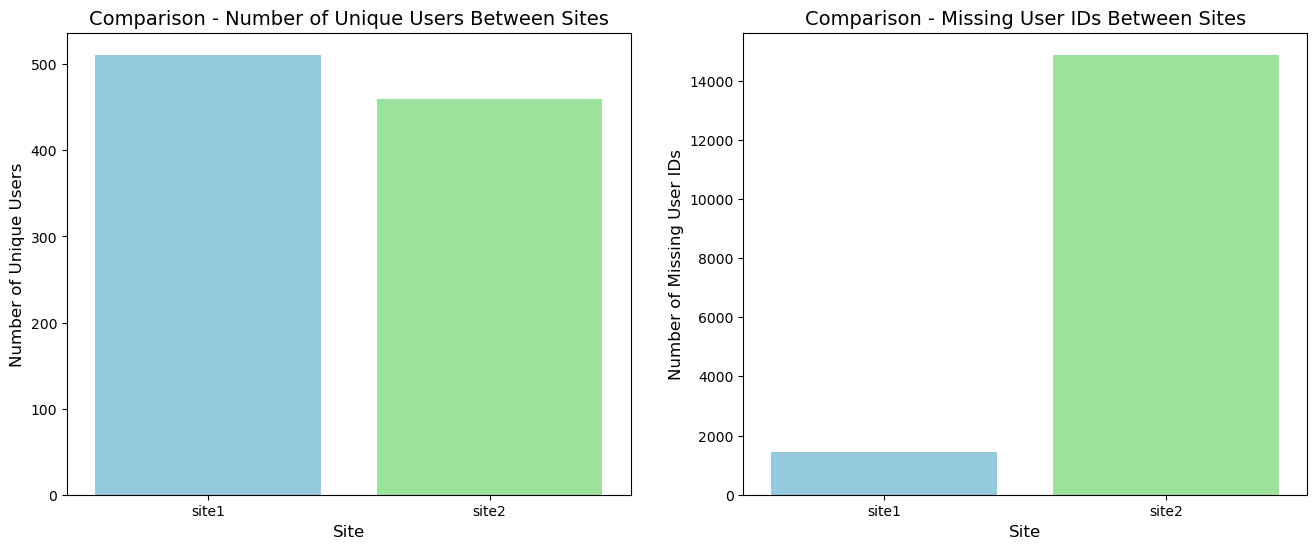

In [56]:
custom_palette = {'site1': 'skyblue', 'site2': 'lightgreen'}


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the number of unique users per site
sns.barplot(x='siteID', y='unique_users', data=comparison_unique_users, palette=custom_palette, ax=axes[0])
axes[0].set_title('Comparison - Number of Unique Users Between Sites', fontsize=14)
axes[0].set_xlabel('Site', fontsize=12)
axes[0].set_ylabel('Number of Unique Users', fontsize=12)

# Plot for the number of missing user IDs per site
sns.barplot(x='siteID', y='unique_users', data=comparison_missing_users, palette=custom_palette, ax=axes[1])
axes[1].set_title('Comparison - Missing User IDs Between Sites', fontsize=14)
axes[1].set_xlabel('Site', fontsize=12)
axes[1].set_ylabel('Number of Missing User IDs', fontsize=12)



# Display the plots
plt.show()

The diagrams reveal several insights about the two sites, Site 1 and Site 2.
- Unique Users: Both sites show a similar number of unique users, with values in the same range for both locations. This indicates that, in terms of unique user activity, both sites are relatively comparable.
- Missing User IDs: However, the second diagram reveals a significant difference in the number of missing userID values. Site 2 has 14,873 missing values compared to only 1,433 for Site 1. 

Conclusion: The high number of missing user IDs at Site 2 suggests it is the public charging hub, likely at the university, where there is a mix of registered and non-registered users. In contrast, Site 1, with fewer missing IDs, is more consistent with a private site, such as a company parking garage, where the usage is mainly from registered employees and nearly everyone who uses the garage, is registred through the company.

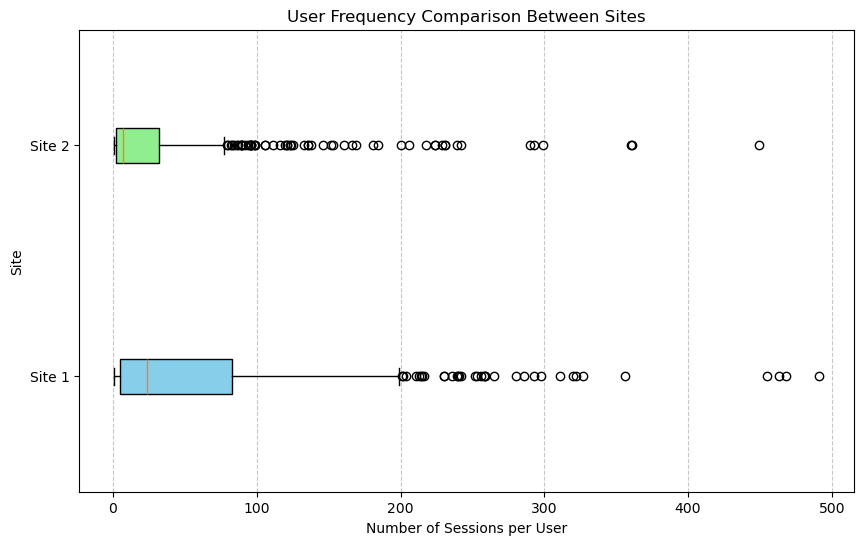

In [57]:
# Group by user ID and count the number of sessions per user
user_frequency_1 = data_1.groupby('userID').size()
user_frequency_2 = data_2.groupby('userID').size()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))


# Create individual boxplots for each site with custom colors
box_data = [user_frequency_1, user_frequency_2]
box_colors = ['skyblue', 'lightgreen']
box_labels = ['Site 1', 'Site 2']

# Draw the boxplots
bp = ax.boxplot(box_data, vert=False, patch_artist=True, labels=box_labels)

# Set custom colors
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)

# Box plot
ax.set_title('User Frequency Comparison Between Sites')
ax.set_xlabel('Number of Sessions per User')
ax.set_ylabel('Site')
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Site 1 seems to be a private charging station for company employees. The variety of frequent and regular users suggests many employees use it daily. A few users charge particularly often, likely because they commute every day.  
On the other hand, Site 2 appears to be a public charging station at a university. Most users charge their vehicles only occasionally, typical for students or university visitors. A handful of users charge more frequently, but the majority use the station sporadically.

#### **Charging Duration and Energy Consumption**

The goal of this analysis is to determine if charging durations and energy consumption patterns indicate a specific type of location.

This section calculates the charging duration for both datasets. The charging duration is derived by subtracting the connectionTime from the chargingTime and then converting the result from seconds to hours.

In [58]:
# Calculate the charging duration in hours for both datasets
data_1['chargingDuration'] = (data_1['doneChargingTime'] - data_1['connectionTime']).dt.total_seconds() / 3600
data_2['chargingDuration'] = (data_2['doneChargingTime'] - data_2['connectionTime']).dt.total_seconds() / 3600

In this step, summary statistics (mean and median) for the charging duration and kWh delivered are calculated for both sites (siteID=1 and siteID=2).

In [59]:
# Summary for siteID=1
summary_stats_1 = data_1[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_1['siteID'] = 1

# Summary for siteID=2
summary_stats_2 = data_2[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_2['siteID'] = 2

# Combine the statistics for both sites
summary_stats = pd.concat([summary_stats_1, summary_stats_2])
print("Summary of Charging Duration and Energy Consumption:")
print(summary_stats)


Summary of Charging Duration and Energy Consumption:
    index  chargingDuration  kWhDelivered  siteID
0    mean          4.031188     10.343517       1
1  median          3.498889      8.991000       1
0    mean          2.977065      7.696862       2
1  median          2.047500      6.588000       2


 The goal of these visualizations is to compare the charging duration and energy consumption for the two sites (siteID=1 and siteID=2). The first two plots are boxplots that show the distribution of charging duration and energy delivered for each site, while the last two plots are histograms that provide further insight into the distribution of charging durations and energy consumption.

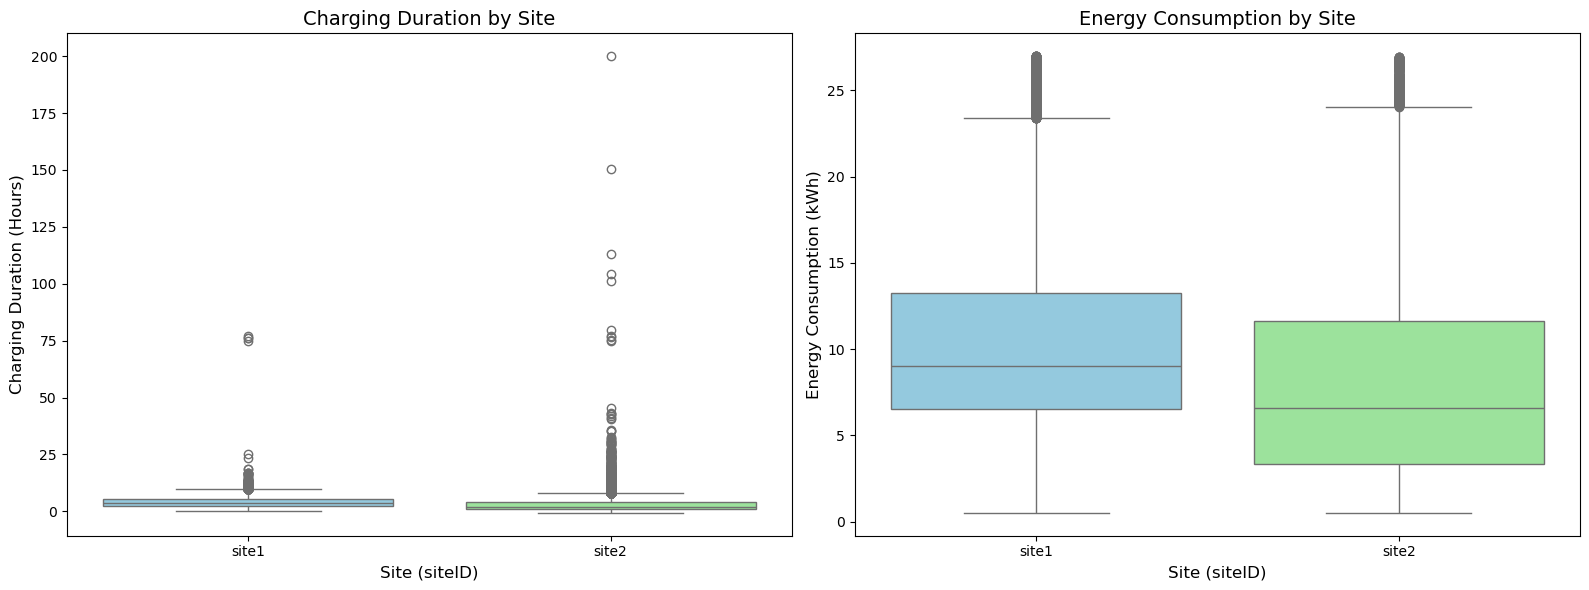

In [60]:
# Define the custom color palette
custom_palette = {'site1': 'skyblue', 'site2': 'lightgreen'}

# Prepare the data with site labels
data_combined = pd.concat([
    data_1.assign(siteID='site1'), 
    data_2.assign(siteID='site2')
])

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Boxplot for charging duration
sns.boxplot(
    data=data_combined, 
    x='siteID', 
    y='chargingDuration', 
    palette=custom_palette, 
    ax=axes[0]
)
axes[0].set_title("Charging Duration by Site", fontsize=14)
axes[0].set_xlabel("Site (siteID)", fontsize=12)
axes[0].set_ylabel("Charging Duration (Hours)", fontsize=12)

# Boxplot for energy consumption
sns.boxplot(
    data=data_combined, 
    x='siteID', 
    y='kWhDelivered', 
    palette=custom_palette, 
    ax=axes[1]
)
axes[1].set_title("Energy Consumption by Site", fontsize=14)
axes[1].set_xlabel("Site (siteID)", fontsize=12)
axes[1].set_ylabel("Energy Consumption (kWh)", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


Key Statistics:

| Metric                      | Site 1         | Site 2         |
|-----------------------------|----------------|----------------|
| Average Charging Duration   | 6.87 hours     | 5.85 hours     |
| Median Charging Duration    | 7.60 hours     | 4.99 hours     |
| Average Energy Consumption  | 14.16 kWh      | 8.81 kWh       |
| Median Energy Consumption   | 11.29 kWh      | 6.59 kWh       |


The boxplot for charging duration reveals that the distribution of charging times at Site 1 is slightly higher and broader than at Site 2. This suggests that vehicles tend to stay connected for longer periods at Site 1, aligning with predictable usage patterns by employees.

The boxplot for energy consumption indicates that both the average and median energy consumption at Site 1 are higher than at Site 2. This could be attributed to longer charging durations and a controlled environment with regular users.

##### Conclusion

The analysis confirms that **site 1 is likely a private charging station**, such as one at a company parking lot, while **site 2 corresponds to a public charging station** near the university.

- Site 1 exhibits predictable weekday usage, longer charging durations, more equal users and higher energy consumption. These patterns align with employees charging their vehicles during fixed working hours in a controlled, private setting.

- Site 2 shows more varied usage across the day and week, shorter charging, higher variety of users, and lower energy consumption. Although the total number of unique registered users is similar to site 1, the significantly higher volume of anonymous, unregistered users reflects the public access and transient visitors typical of a university setting.


# `3. Cluster Analysis`

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#### ParkingDuration - KWHDelivered

We are going to cluster Parking Duration and kWh Delivered to identify groups based on parking and energy usage patterns. This will help us better understand different user behaviors and group them accordingly for more targeted insights and resource management.

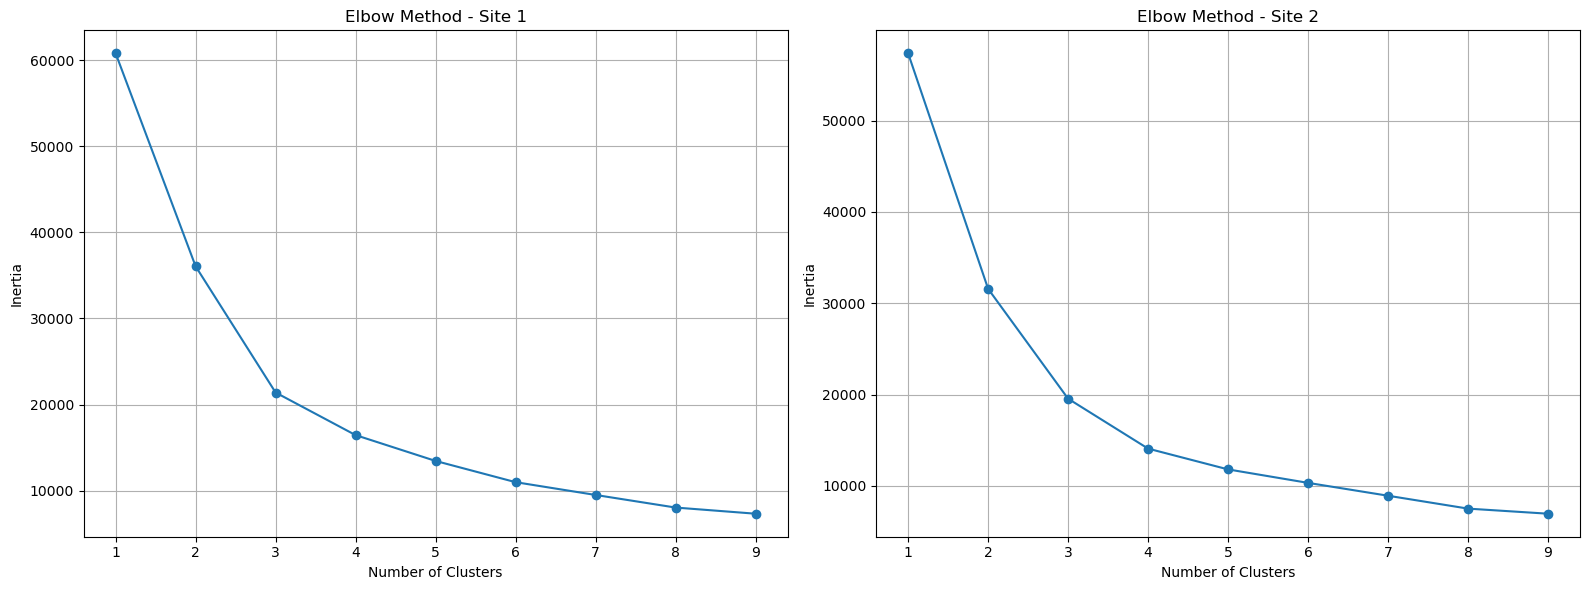

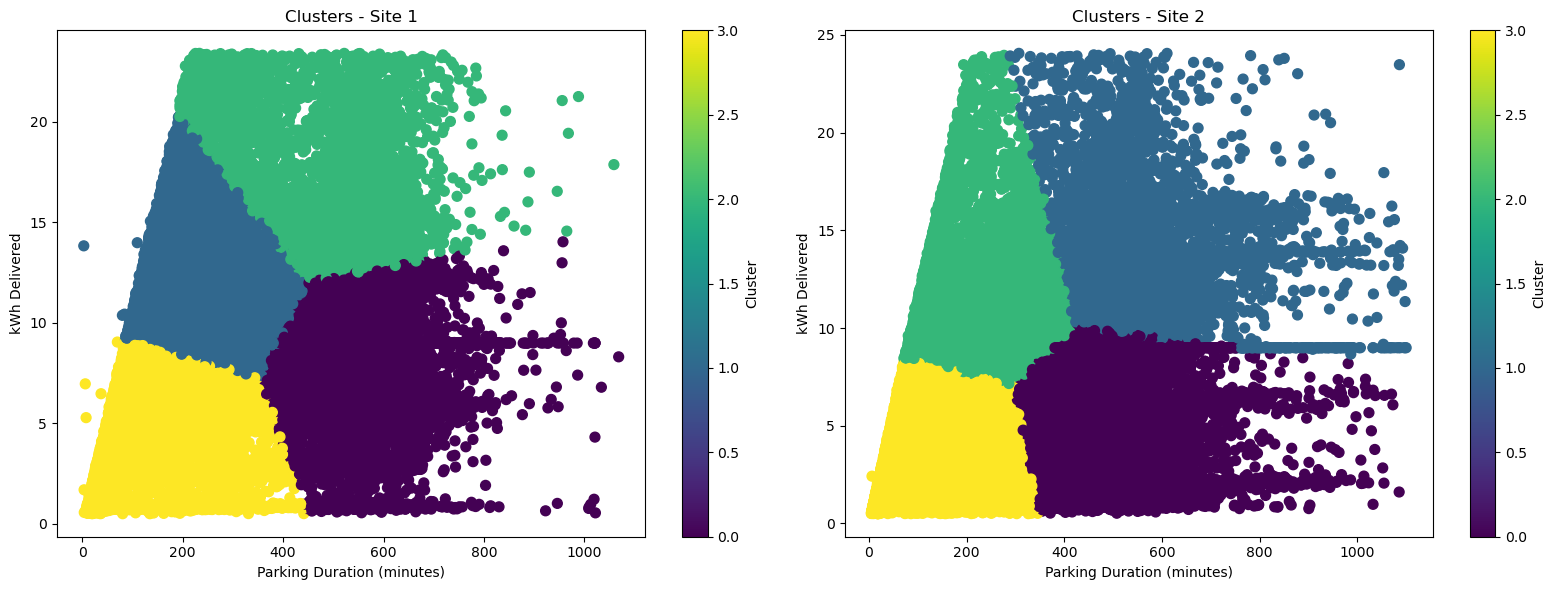

Site 1 - Average Silhouette Coefficient: 0.43
Site 1 - Cluster Statistics:
        parkingTime                 kWhDelivered       
              count    mean  median         mean median
Cluster                                                
0             12347  568.48  570.97         8.04   8.99
1              6539  247.77  249.18        11.88  11.60
2              5496  503.58  543.22        16.87  16.01
3              6013  168.71  151.48         4.67   5.24


Site 2 - Average Silhouette Coefficient: 0.45
Site 2 - Cluster Statistics:
        parkingTime                 kWhDelivered       
              count    mean  median         mean median
Cluster                                                
0              7784  515.91  509.40         5.17   5.30
1              4904  568.47  542.01        14.16  13.83
2              5652  215.27  207.18        12.22  11.89
3             10338  120.55   97.17         3.51   3.34


In [62]:
def cluster_charging_kwh(data, site_id):
    # Filter data for the specific site ID
    site_data = data[data['siteID'] == site_id]

    # Calculate parkingTime and keep kWhDelivered
    site_data['parkingTime'] = (site_data['disconnectTime'] - site_data['connectionTime']).dt.total_seconds() / 60
    site_data['kWhDelivered'] = site_data['kWhDelivered']

    # Calculate IQR for both features and remove outliers
    Q1_charging = site_data['parkingTime'].quantile(0.25)
    Q3_charging = site_data['parkingTime'].quantile(0.75)
    IQR_charging = Q3_charging - Q1_charging
    lower_bound_charging = Q1_charging - 1.5 * IQR_charging
    upper_bound_charging = Q3_charging + 1.5 * IQR_charging

    Q1_kwh = site_data['kWhDelivered'].quantile(0.25)
    Q3_kwh = site_data['kWhDelivered'].quantile(0.75)
    IQR_kwh = Q3_kwh - Q1_kwh
    lower_bound_kwh = Q1_kwh - 1.5 * IQR_kwh
    upper_bound_kwh = Q3_kwh + 1.5 * IQR_kwh

    site_data_filtered = site_data[(site_data['parkingTime'] >= lower_bound_charging) & (site_data['parkingTime'] <= upper_bound_charging) &
                                   (site_data['kWhDelivered'] >= lower_bound_kwh) & (site_data['kWhDelivered'] <= upper_bound_kwh)]

    # Select and scale both features
    features = site_data_filtered[['parkingTime', 'kWhDelivered']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Determine optimal number of clusters using the Elbow method
    inertia = []
    range_n_clusters = range(1, 10)
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    # Perform clustering
    optimal_clusters = 4
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    site_data_filtered['Cluster'] = clusters

    # Evaluate silhouette score
    silhouette_avg = silhouette_score(features_scaled, clusters)

    # Aggregate cluster statistics
    cluster_stats = site_data_filtered.groupby('Cluster').agg({
        'parkingTime': ['count', 'mean', 'median'],
        'kWhDelivered': ['mean', 'median']
    }).sort_index().round(2)

    return inertia, clusters, features, site_data_filtered, silhouette_avg, cluster_stats

# Perform clustering for siteID 1 and siteID 2
inertia_1, clusters_1, features_1, filtered_data_1, silhouette_1, stats_1 = cluster_charging_kwh(data_unique, site_id=1)
inertia_2, clusters_2, features_2, filtered_data_2, silhouette_2, stats_2 = cluster_charging_kwh(data_unique, site_id=2)

# Plot Elbow Method for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(range(1, 10), inertia_1, marker='o')
axes[0].set_title('Elbow Method - Site 1')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid()

axes[1].plot(range(1, 10), inertia_2, marker='o')
axes[1].set_title('Elbow Method - Site 2')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Inertia')
axes[1].grid()

plt.tight_layout()
plt.show()

# Plot Clustering Results for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter1 = axes[0].scatter(features_1['parkingTime'], features_1['kWhDelivered'], c=clusters_1, cmap='viridis', s=50)
axes[0].set_title('Clusters - Site 1')
axes[0].set_xlabel('Parking Duration (minutes)')
axes[0].set_ylabel('kWh Delivered')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')  # Corrected line

scatter2 = axes[1].scatter(features_2['parkingTime'], features_2['kWhDelivered'], c=clusters_2, cmap='viridis', s=50)
axes[1].set_title('Clusters - Site 2')
axes[1].set_xlabel('Parking Duration (minutes)')
axes[1].set_ylabel('kWh Delivered')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')  # Corrected line

plt.tight_layout()
plt.show()

# Display Silhouette Scores and Cluster Statistics
print(f"Site 1 - Average Silhouette Coefficient: {silhouette_1:.2f}")
print("Site 1 - Cluster Statistics:")
print(stats_1)

print("\n" + "="*50 + "\n")

print(f"Site 2 - Average Silhouette Coefficient: {silhouette_2:.2f}")
print("Site 2 - Cluster Statistics:")
print(stats_2)

##### Cluster Names

Site 1
* Cluster 0 -> "The Power Professionals"
    * Employees in this cluster park for longer durations (568 minutes on average) and deliver a moderate amount of energy (8.04 kWh). They likely spend significant time at the company, engaging in meetings or tasks, and use the charging stations consistently.
* Cluster 1 -> "The Quick Rechargers"
    * These employees park for shorter durations (247 minutes on average) and deliver a higher amount of energy (11.88 kWh). They likely use the charging stations during quick breaks or short visits, reflecting a dynamic workday with quick but efficient energy use.
* Cluster 2 -> "The Steady Chargers"
    * Employees in this cluster charge for a moderately long time (503 minutes on average) and deliver a substantial amount of energy (16.87 kWh). These workers may be on-site for full days, using the charging stations for consistent, longer sessions throughout their workday.
* Cluster 3 -> "The Short Hoppers"
    * These employees park for relatively short durations (168 minutes on average) and deliver the lowest amount of energy (4.67 kWh). They are likely making brief, quick stops for work-related tasks, using the charging stations only for short bursts of energy.

Site 2
* Cluster 0 -> "The All-Day Learners"
    * Students in this cluster park for moderate periods (515 minutes on average) and deliver a small amount of energy (5.17 kWh). They likely stay on campus for extended periods for classes or studying, charging their vehicles over the course of the day.
* Cluster 1 -> "The Marathon Students"
    * These students park for long durations (568 minutes on average) and deliver a higher amount of energy (14.16 kWh). They are likely on campus for the whole day, attending multiple classes or engaging in university activities, relying heavily on the charging stations.
* Cluster 2 -> "The Quick Breakers"
    * Students in this cluster park for shorter durations (215 minutes on average) but deliver a relatively high amount of energy (12.22 kWh). Despite the brief parking time, they charge a significant amount, indicating that they use the charging stations efficiently during their quick visits to campus, likely between classes or other activities. This group may rely on the chargers for high-energy needs during their brief stops.
* Cluster 3 -> "The Casual Commuters"
    * These students park for the shortest periods (120 minutes on average) and deliver the least energy (3.51 kWh). They are likely making brief visits to campus, perhaps between classes, and only need minimal energy for quick stops.
 

#### ChargingTime - PostChargingTime

We are going to cluster Charging Time and Post-Charging Time to group users based on their charging and post-charging behaviors. This will help us understand whether users leave immediately after charging or stay for a while, providing insights into their charging habits and behavior after the charging session ends.

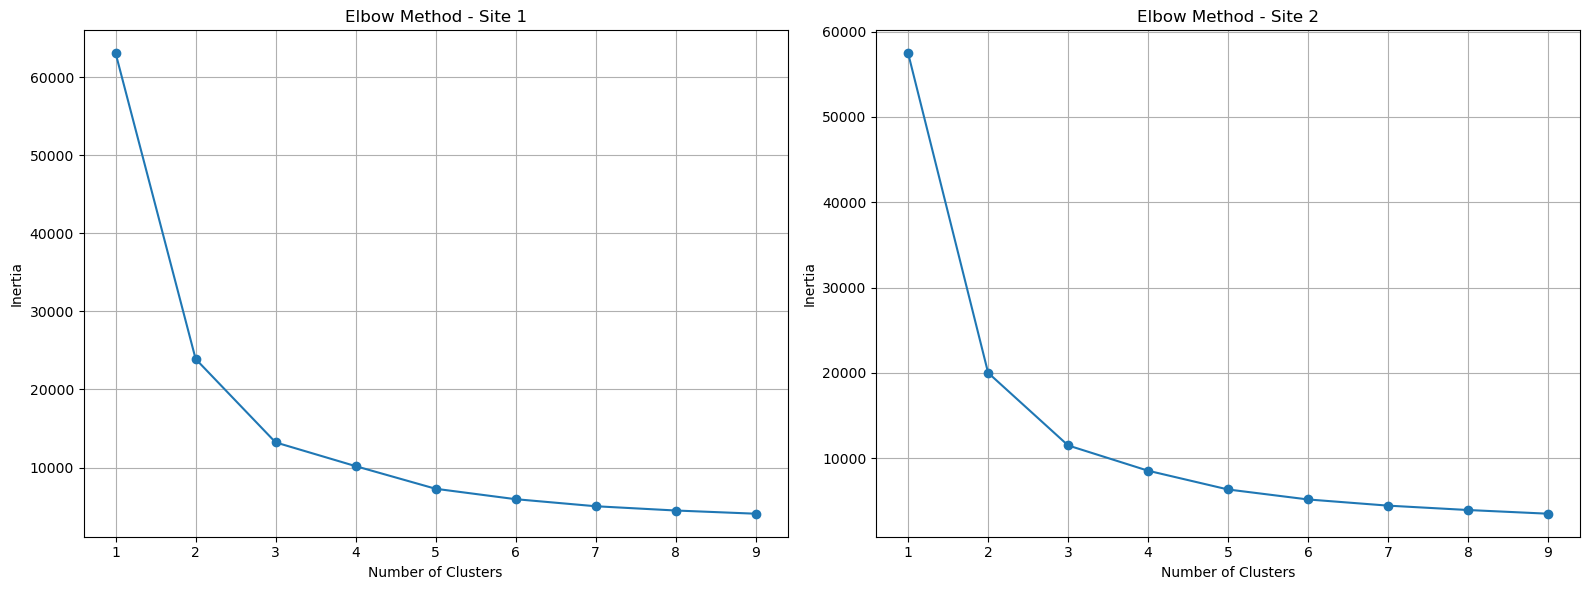

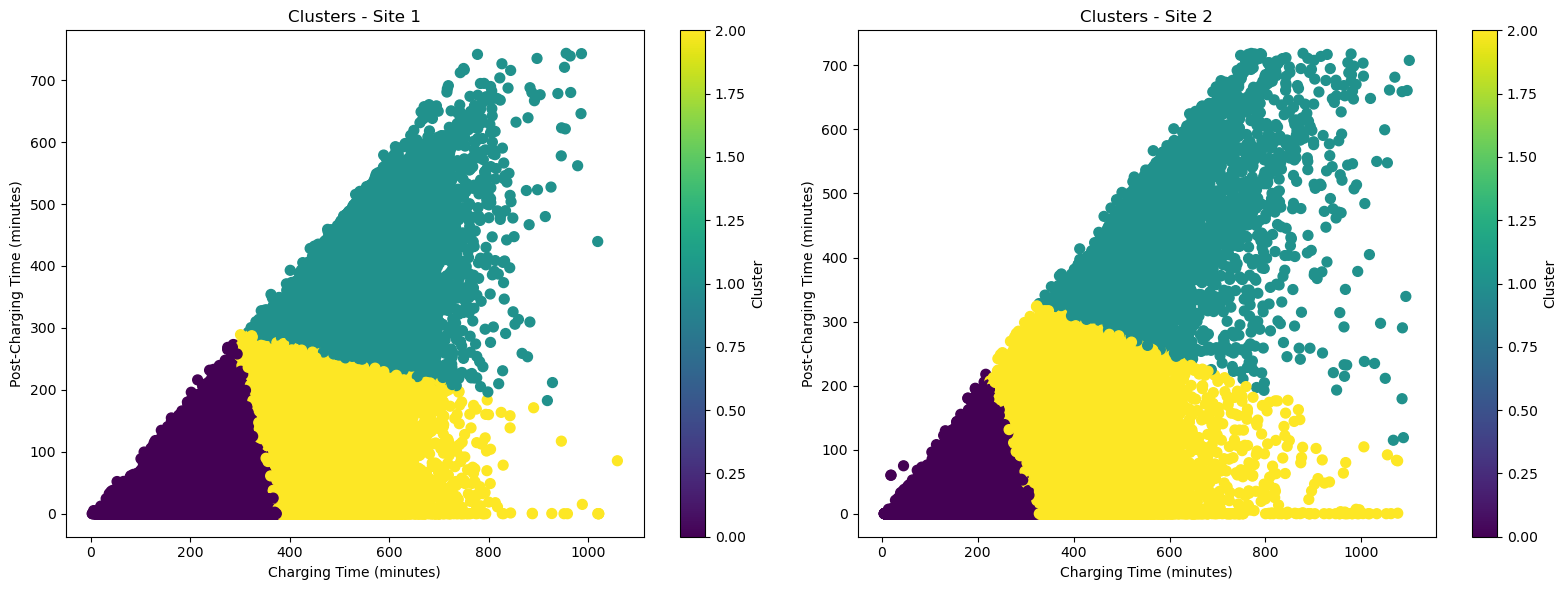

Site 1 - Average Silhouette Coefficient: 0.50
Site 1 - Cluster Statistics:
        chargingTime                 PostChargingTime        
               count    mean  median             mean  median
Cluster                                                      
0              12467  199.36  202.82            39.20    3.80
1              10087  580.77  580.73           376.70  363.48
2               8964  507.91  521.15           111.42  114.21


Site 2 - Average Silhouette Coefficient: 0.53
Site 2 - Cluster Statistics:
        chargingTime                 PostChargingTime        
               count    mean  median             mean  median
Cluster                                                      
0              14022  131.42  119.13            26.00    0.22
1               6828  566.31  545.10           421.96  408.28
2               7882  441.68  430.24           128.99  133.32


In [63]:
def cluster_charging_postcharging(data, site_id):
    # Filter data for the specific site ID
    site_data = data[data['siteID'] == site_id]

    # Calculate chargingTime and PostChargingTime
    site_data['chargingTime'] = (site_data['disconnectTime'] - site_data['connectionTime']).dt.total_seconds() / 60
    site_data['PostChargingTime'] = (site_data['disconnectTime'] - site_data['doneChargingTime']).dt.total_seconds() / 60 

    # Calculate IQR for both features and remove outliers
    Q1_charging = site_data['chargingTime'].quantile(0.25)
    Q3_charging = site_data['chargingTime'].quantile(0.75)
    IQR_charging = Q3_charging - Q1_charging
    lower_bound_charging = Q1_charging - 1.5 * IQR_charging
    upper_bound_charging = Q3_charging + 1.5 * IQR_charging

    Q1_postcharging = site_data['PostChargingTime'].quantile(0.25)
    Q3_postcharging = site_data['PostChargingTime'].quantile(0.75)
    IQR_postcharging = Q3_postcharging - Q1_postcharging
    lower_bound_postcharging = Q1_postcharging - 1.5 * IQR_postcharging
    upper_bound_postcharging = Q3_postcharging + 1.5 * IQR_postcharging

    site_data_filtered = site_data[(site_data['chargingTime'] >= lower_bound_charging) & 
                                   (site_data['chargingTime'] <= upper_bound_charging) & 
                                   (site_data['PostChargingTime'] >= lower_bound_postcharging) & 
                                   (site_data['PostChargingTime'] <= upper_bound_postcharging)]

    # Select and scale both features
    features = site_data_filtered[['chargingTime', 'PostChargingTime']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Determine optimal number of clusters using the Elbow method
    inertia = []
    range_n_clusters = range(1, 10)
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    # Perform clustering with the chosen number of clusters
    optimal_clusters = 3
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    site_data_filtered['Cluster'] = clusters

    # Evaluate silhouette score
    silhouette_avg = silhouette_score(features_scaled, clusters)

    # Aggregate cluster statistics
    cluster_stats = site_data_filtered.groupby('Cluster').agg({
        'chargingTime': ['count', 'mean', 'median'],
        'PostChargingTime': ['mean', 'median']
    }).sort_index().round(2)

    return inertia, clusters, features, site_data_filtered, silhouette_avg, cluster_stats

# Perform clustering for siteID 1 and siteID 2
inertia_1, clusters_1, features_1, filtered_data_1, silhouette_1, stats_1 = cluster_charging_postcharging(data_unique, site_id=1)
inertia_2, clusters_2, features_2, filtered_data_2, silhouette_2, stats_2 = cluster_charging_postcharging(data_unique, site_id=2)

# Plot Elbow Method for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(range(1, 10), inertia_1, marker='o')
axes[0].set_title('Elbow Method - Site 1')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid()

axes[1].plot(range(1, 10), inertia_2, marker='o')
axes[1].set_title('Elbow Method - Site 2')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Inertia')
axes[1].grid()

plt.tight_layout()
plt.show()

# Plot Clustering Results for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter1 = axes[0].scatter(features_1['chargingTime'], features_1['PostChargingTime'], c=clusters_1, cmap='viridis', s=50)
axes[0].set_title('Clusters - Site 1')
axes[0].set_xlabel('Charging Time (minutes)')
axes[0].set_ylabel('Post-Charging Time (minutes)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')  # Corrected line

scatter2 = axes[1].scatter(features_2['chargingTime'], features_2['PostChargingTime'], c=clusters_2, cmap='viridis', s=50)
axes[1].set_title('Clusters - Site 2')
axes[1].set_xlabel('Charging Time (minutes)')
axes[1].set_ylabel('Post-Charging Time (minutes)')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')  # Corrected line

plt.tight_layout()
plt.show()

# Display Silhouette Scores and Cluster Statistics
print(f"Site 1 - Average Silhouette Coefficient: {silhouette_1:.2f}")
print("Site 1 - Cluster Statistics:")
print(stats_1)

print("\n" + "="*50 + "\n")

print(f"Site 2 - Average Silhouette Coefficient: {silhouette_2:.2f}")
print("Site 2 - Cluster Statistics:")
print(stats_2)

##### Cluster Names

Site 1
* Cluster 0 -> "The Quick Break"
    * This group represents employees who park for a moderate amount of time (around 199 minutes) and charge their vehicles before leaving shortly after the charging ends. These individuals likely use the charging station for a short, efficient stop during their workday. It is possible that some of these employees come to the parking lot specifically to charge their vehicles, perhaps for errands, meetings, or other brief work-related tasks. Their quick turnover suggests they don't spend extended time in the parking lot but still make use of the charging station during their on-site hours.
* Cluster 1 -> "The All-Day Worker"
    * This cluster includes employees who charge their vehicles for a long period (around 580 minutes) and stay at the parking lot for an extended time after the charging is complete. These are employees who likely work throughout the entire day, using the charging station during office hours and staying on-site for long stretches, perhaps in the parking lot or the building.
* Cluster 2 -> "The Mid-Day Recharge"
    * This group consists of employees who charge their vehicles for a moderate amount of time (around 508 minutes) and then spend additional time in the parking lot after their car is fully charged (around 111 minutes). These employees likely stay on-site for the majority of the day. The extended postChargingTime suggests that they may not immediately leave after charging, possibly using the extra time to relax, finish up work, or prepare for their next task.


Site 2
* Cluster 0 -> "Single Class Attendees"
    * This cluster represents students who charge for a short period (around 131 minutes on average) and leave almost immediately after charging is complete, with a very brief post-charging time (around 26 minutes on average). These students likely attend a single class or activity for a couple of hours and then leave the campus, reflecting a quick stop for charging between classes.
* Cluster 1 -> "Full-Day Campus Attendees"
    * This cluster represents students who charge for a long period (around 566 minutes on average) and stay on the parking lot for an extended time after the charging session ends (with a post-charging time averaging 421.96 minutes, and a median of 408.28 minutes). These students likely spend the entire day on campus, from morning to evening, attending classes, studying, or participating in campus activities, and they use the charging station throughout the day.
* Cluster 2 -> "Extended Campus Stay"
    * This cluster represents students who charge for a long period (around 441 minutes on average) and stay on the parking lot for a moderate time after the charging session ends (with a post-charging time averaging 128.99 minutes, and a median of 133.32 minutes). These students likely spend significant time on campus, possibly attending multiple classes or study sessions, but do not stay as long as the full-day campus attendees in Cluster 1. They charge during their time on campus and leave after spending several hours on-site.

#### StartingHour - ParkingDuration

We are going to cluster StartingHour and ParkingDuration to analyze when different groups arrive at the parking lot and how long they stay. By grouping vehicles based on their arrival times and the duration of their stay, we can identify patterns in parking behavior, such as peak arrival times and varying lengths of stay. This clustering will help in better understanding user behavior, enabling more effective management of parking resources and improving overall parking efficiency.








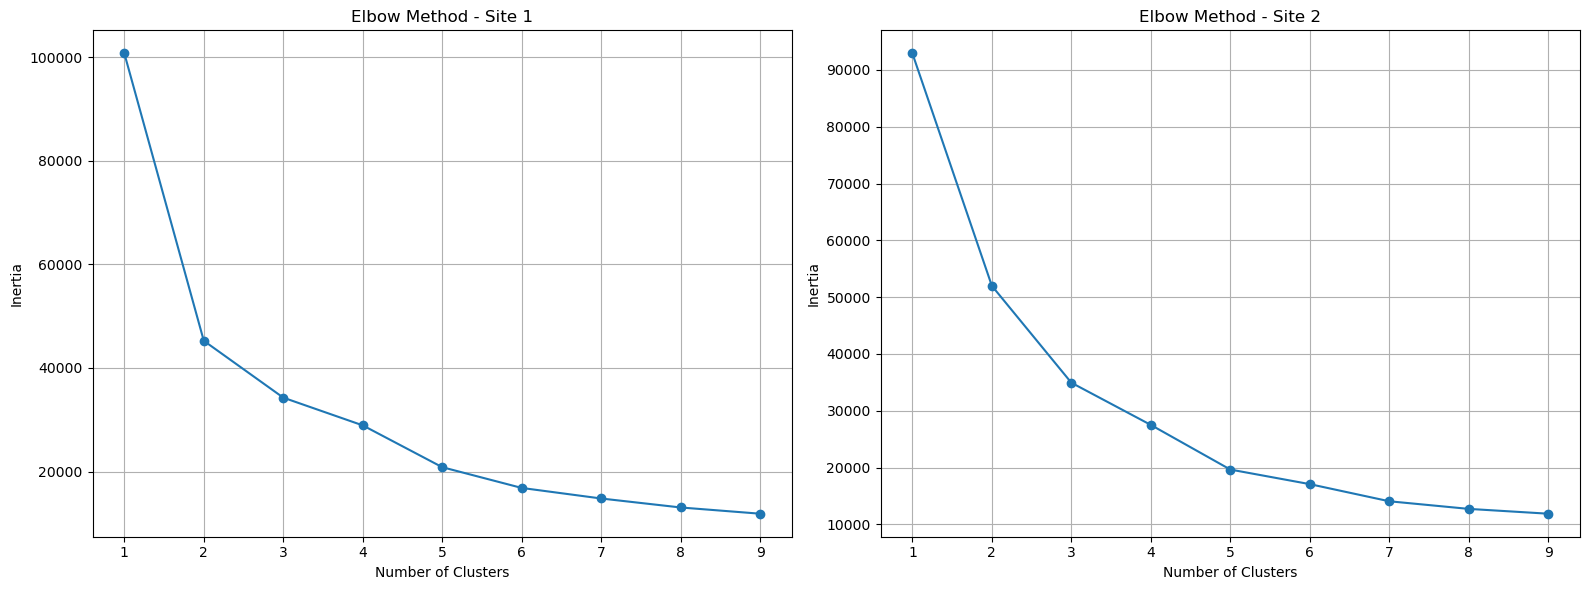

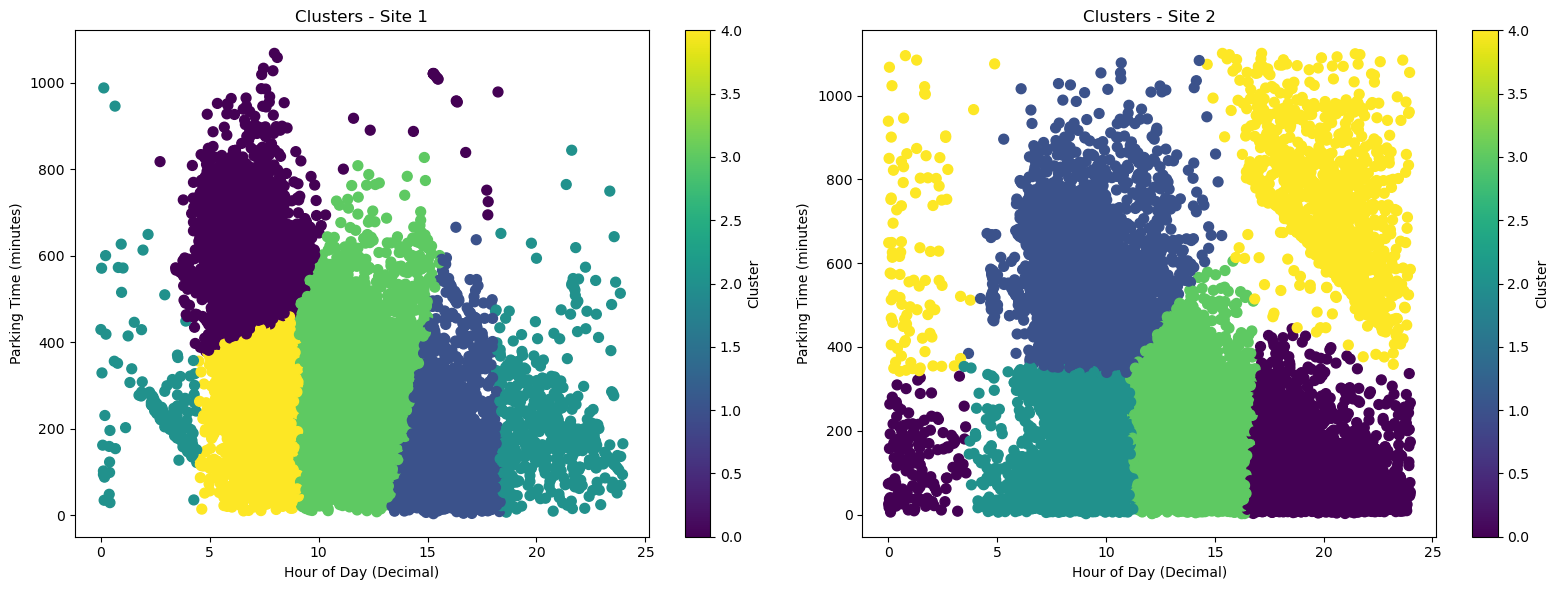

Site 1 - Average Silhouette Coefficient: 0.46
Site 1 - Cluster Statistics:
         count  circular_mean_hour_decimal  mean_parkingTime  \
Cluster                                                        
0        16499                        6.96            576.55   
1         4332                       15.69            152.70   
2          699                       21.80            220.55   
3         6639                       11.74            283.04   
4         5406                        7.31            279.94   

         median_parkingTime  
Cluster                      
0                    572.98  
1                    137.86  
2                    198.75  
3                    273.23  
4                    287.90  


Site 2 - Average Silhouette Coefficient: 0.46
Site 2 - Cluster Statistics:
         count  circular_mean_hour_decimal  mean_parkingTime  \
Cluster                                                        
0         5463                       19.03            107.77 

In [64]:
def cluster_minute_parkingtime(data, site_id, ncluster):
    # Filter data for the specific site ID
    site_data = data[data['siteID'] == site_id]

    # Calculate parkingTime
    site_data['parkingTime'] = (site_data['disconnectTime'] - site_data['connectionTime']).dt.total_seconds() / 60 

    # Convert 'hour' to decimal format
    site_data['connectionHour'] = site_data['connectionTime'].dt.hour + site_data['connectionTime'].dt.minute / 60
   

    # Do not remove outliers for 'hour_decimal'; only remove outliers for 'parkingTime'
    Q1_parking = site_data['parkingTime'].quantile(0.25)
    Q3_parking = site_data['parkingTime'].quantile(0.75)
    IQR_parking = Q3_parking - Q1_parking
    lower_bound_parking = Q1_parking - 1.5 * IQR_parking
    upper_bound_parking = Q3_parking + 1.5 * IQR_parking

    site_data_filtered = site_data[(site_data['parkingTime'] >= lower_bound_parking) & 
                                   (site_data['parkingTime'] <= upper_bound_parking)]

    
    site_data_filtered['hour_sin'] = np.sin(2 * np.pi * site_data_filtered['connectionHour'] / 24)
    site_data_filtered['hour_cos'] = np.cos(2 * np.pi * site_data_filtered['connectionHour'] / 24)

    # Select and scale features
    features = site_data_filtered[['hour_sin', 'hour_cos', 'parkingTime']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Determine optimal number of clusters using the Elbow method
    inertia = []
    range_n_clusters = range(1, 10)
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    # Perform clustering with the chosen number of clusters
    optimal_clusters = ncluster
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    site_data_filtered['Cluster'] = clusters

    # Evaluate silhouette score
    silhouette_avg = silhouette_score(features_scaled, clusters)

    # Function to calculate circular mean for 'hour_decimal'
    def calculate_circular_mean(hour_series):
        hour_sin = np.sin(2 * np.pi * hour_series / 24)
        hour_cos = np.cos(2 * np.pi * hour_series / 24)
        mean_sin = np.mean(hour_sin)
        mean_cos = np.mean(hour_cos)
        mean_angle = np.arctan2(mean_sin, mean_cos)
        mean_hour = (mean_angle * 24 / (2 * np.pi)) % 24
        return mean_hour

    # Aggregate cluster statistics
    cluster_stats = site_data_filtered.groupby('Cluster').agg({
        'connectionHour': ['count', calculate_circular_mean],
        'parkingTime': ['mean', 'median']
    }).sort_index().round(2)

    # Rename columns for clarity
    cluster_stats.columns = ['count', 'circular_mean_hour_decimal', 'mean_parkingTime', 'median_parkingTime']

    return inertia, clusters, features, site_data_filtered, silhouette_avg, cluster_stats

# Perform clustering for siteID 1 and siteID 2
inertia_1, clusters_1, features_1, filtered_data_1, silhouette_1, stats_1 = cluster_minute_parkingtime(data_with_NA, site_id=1, ncluster=5)
inertia_2, clusters_2, features_2, filtered_data_2, silhouette_2, stats_2 = cluster_minute_parkingtime(data_with_NA, site_id=2, ncluster=5)

# Plot Elbow Method for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(range(1, 10), inertia_1, marker='o')
axes[0].set_title('Elbow Method - Site 1')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid()

axes[1].plot(range(1, 10), inertia_2, marker='o')
axes[1].set_title('Elbow Method - Site 2')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Inertia')
axes[1].grid()

plt.tight_layout()
plt.show()

# Plot Clustering Results for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter1 = axes[0].scatter(filtered_data_1['connectionHour'], filtered_data_1['parkingTime'], c=clusters_1, cmap='viridis', s=50)
axes[0].set_title('Clusters - Site 1')
axes[0].set_xlabel('Hour of Day (Decimal)')
axes[0].set_ylabel('Parking Time (minutes)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(filtered_data_2['connectionHour'], filtered_data_2['parkingTime'], c=clusters_2, cmap='viridis', s=50)
axes[1].set_title('Clusters - Site 2')
axes[1].set_xlabel('Hour of Day (Decimal)')
axes[1].set_ylabel('Parking Time (minutes)')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# Display Silhouette Scores and Cluster Statistics
print(f"Site 1 - Average Silhouette Coefficient: {silhouette_1:.2f}")
print("Site 1 - Cluster Statistics:")
print(stats_1)

print("\n" + "="*50 + "\n")

print(f"Site 2 - Average Silhouette Coefficient: {silhouette_2:.2f}")
print("Site 2 - Cluster Statistics:")
print(stats_2)
    

##### Cluster Names

Site 1
* Cluster 0 -> "The Early hard working Birds"
    * Starting very early at 7:00 AM and parking for an extended period (576 minutes), this group likely includes employees who arrive early to start their workday, often parking for most of the day. This cluster is by far the biggest.
* Cluster 1 -> "The Quick Stops"
    * Starting quite late at 4:00 PM, with a shorter parking duration (150 minutes), these individuals are likely making quick stops, possibly finishing up their workday or stopping by for brief tasks.
* Cluster 2 -> "The Late Night Crew"
    * These workers begin their shifts around 9:00 PM and typically work for approximately 3,5 hours. They are part of a late-evening schedule, often covering specific tasks that require attention during off-peak hours. This Cluster is the smallest.
* Cluster 3 -> "The Late Arrivals"
    * With a later start at around 12:00 PM and a moderate parking time (283 minutes), these individuals may have a midday shift or flexible schedules, staying a few hours during the afternoon.
* Cluster 4 -> "The Morning Steady-Stayers"
    * This group arrives early at around 7:30 AM and parks for a moderate duration (280 minutes), indicating that they likely start their day early and stay for a few hours, possibly for morning tasks or meetings. These individuals could potentially be part-time workers who have flexible or shorter work schedules.

Site 2
* Cluster 0 -> "The Evening Students"
    * This group of students begins parking around 7:00 PM and stays for an average of 107 minutes. They likely arrive for short evening classes or activities.
* Cluster 1 -> "The Campus Lifers"
    * This group of students parks around 9:00 AM and stays for an average of 523 minutes (around 8.5 hours). These Campus Lifers spend the entire day on campus, immersed in classes, studying, and engaging in various activities from morning to evening. This Cluster is the biggest.
* Cluster 2 -> "The Morning Class Attendees"
    * This group of students arrives around 9:00 AM and parks for an average duration of 164 minutes. They likely come for a morning class or a short session and leave after approximately 3 hours, reflecting their brief stay on campus.
* Cluster 3 -> "The Midday Scholars"
    * This group of students parks around 14:00 PM and stays for an average of 185 minutes. They likely attend afternoon classes or engage in campus activities, staying for about 3 hours during the midday period.
* Cluster 4 -> "The Night Owls"
    * This group of students parks around 9:00 PM and stays for an extended period of about 728 minutes. These night owls likely park overnight, staying on campus for late-night study sessions, social activities, or events like partying. This Cluster is the smallest.

Identifying different types of charging sessions is valuable for several reasons:

1. Optimized Resource Management: By understanding the patterns of charging sessions, such as peak usage times, duration, and energy delivered, parking lot operators can better allocate charging stations, ensuring availability during high-demand periods and reducing wait times.

2. User Behavior Insights: Identifying different charging behaviors (e.g., quick charges vs. long-term parking) helps understand how users interact with the infrastructure. This can inform strategies to improve customer experience, such as offering different types of charging services (e.g., fast charging for short visits, regular charging for long stays).

3. Improved Infrastructure Planning: Understanding charging patterns helps in planning the capacity and locations of charging stations. For example, areas with higher usage of long-duration charging sessions might need more chargers or higher-capacity ones.

4. Energy Efficiency and Cost Management: By categorizing charging sessions, energy providers can predict demand more accurately and plan for energy distribution. They can optimize load balancing and adjust pricing strategies, potentially offering dynamic pricing to encourage charging during off-peak hours, leading to cost savings.

5. Targeted Marketing and Services: Recognizing different user types enables tailored marketing. For instance, users who frequently engage in short, quick charging sessions might be interested in loyalty programs or promotions for regular users, while long-stay parkers may benefit from discounts or subscription plans.

6. Sustainability Efforts: Understanding the different types of charging sessions can help in promoting eco-friendly practices. For example, offering incentives for using renewable energy sources during certain times of the day can help reduce the environmental impact.

-------------------------------------------------------------------------------------------

# `4. Utilization Prediction`

In [65]:
def hourly_utilization_prediction(data):
    rows = []

    # Iteriere über alle eindeutigen Site-IDs
    for site_id in data['siteID'].unique():
        # Filtere Daten für die aktuelle Site-ID
        data_prediction = data[data['siteID'] == site_id].copy()

        for _, row in data_prediction.iterrows():
            start = row['connectionTime']
            end = row['disconnectTime']

            current = start
            while current < end:
                next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
                if next_hour > end:
                    next_hour = end

                # Berechne die Dauer innerhalb der aktuellen Stunde
                duration_in_hour = (next_hour - current).total_seconds() / 3600

                # Füge die Daten der Liste hinzu
                rows.append({
                    'siteID': site_id,
                    'hour': current.replace(minute=0, second=0, microsecond=0),
                    'session_duration_in_hour': duration_in_hour
                })

                current = next_hour

    # Erstelle einen DataFrame aus den gesammelten Daten
    result_df = pd.DataFrame(rows)

    # Gruppiere nach Site-ID und Stunde, berechne die Summen und die Auslastung
    utilization_df = (
        result_df.groupby(['siteID', 'hour'])
        .agg(total_session_duration=('session_duration_in_hour', 'sum'))
        .reset_index()
    )

    # Anzahl der Stationen hinzufügen
    station_counts = data.groupby('siteID')['stationID'].nunique().reset_index()
    station_counts.rename(columns={'stationID': 'num_stations'}, inplace=True)

    # Merge mit Stationenanzahl
    utilization_df = utilization_df.merge(station_counts, on='siteID', how='left')

    # Berechne die Auslastung
    utilization_df['hourly_utilization'] = (
        utilization_df['total_session_duration'] / utilization_df['num_stations'] * 100
    )

    return utilization_df

In [66]:
hourly_utilization = hourly_utilization_prediction(data_unique)

hourly_utilization['day_of_week'] = hourly_utilization['hour'].dt.dayofweek
hourly_utilization['date'] = hourly_utilization['hour'].dt.date
hourly_utilization['hour'] = hourly_utilization['hour'].dt.hour

columns_order = ['siteID', 'date', 'hour', 'day_of_week', 'total_session_duration', 'num_stations', 'hourly_utilization']
hourly_utilization = hourly_utilization[columns_order]
hourly_utilization.head(5)

,siteID,date,hour,day_of_week,total_session_duration,num_stations,hourly_utilization
0,1,2018-10-08,6,0,1.991667,52,3.830128
1,1,2018-10-08,7,0,11.224444,52,21.585470
2,1,2018-10-08,8,0,19.000000,52,36.538462
3,1,2018-10-08,9,0,19.000000,52,36.538462
4,1,2018-10-08,10,0,19.000000,52,36.538462


In [67]:
# Group by site_id and calculate mean utilization
utilization_by_type = hourly_utilization.groupby(['siteID'])['hourly_utilization'].describe()
print(utilization_by_type)

          count       mean       std       min       25%       50%        75%  \
siteID                                                                          
1       15053.0  27.732495  34.70021  0.000534  2.063568  8.390491  38.989316   
2       19302.0  16.468796  19.79278  0.001543  2.983796  7.407407  22.077418   

               max  
siteID              
1       100.000000  
2        93.286523  


In [68]:
hourly_utilization_1 = hourly_utilization[hourly_utilization['siteID']==1]
hourly_utilization_2 = hourly_utilization[hourly_utilization['siteID']==2]
hourly_utilization_1.head()

,siteID,date,hour,day_of_week,total_session_duration,num_stations,hourly_utilization
0,1,2018-10-08,6,0,1.991667,52,3.830128
1,1,2018-10-08,7,0,11.224444,52,21.585470
2,1,2018-10-08,8,0,19.000000,52,36.538462
3,1,2018-10-08,9,0,19.000000,52,36.538462
4,1,2018-10-08,10,0,19.000000,52,36.538462


Add weather data to prediction. Therefore we choose relevant data from the weather dataset.

In [69]:
weather_unique.head()

,city,timestamp,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,month,season
0,Burbank,2018-01-01 00:53:00,9.0,33.0,991.75,9.0,0.0,8.0,1,Winter
1,Burbank,2018-01-01 01:53:00,9.0,33.0,992.08,0.0,0.0,9.0,1,Winter
2,Burbank,2018-01-01 02:53:00,9.0,21.0,992.08,0.0,0.0,9.0,1,Winter
3,Burbank,2018-01-01 03:53:00,9.0,29.0,992.08,0.0,0.0,9.0,1,Winter
4,Burbank,2018-01-01 04:53:00,8.0,33.0,992.08,0.0,0.0,8.0,1,Winter


In [70]:
weather_unique['timestamp'] = weather_unique['timestamp'].dt.ceil('H')

weather_unique['date'] = weather_unique['timestamp'].dt.date
weather_unique['hour'] = weather_unique['timestamp'].dt.hour

weather_unique = weather_unique.drop(columns=['timestamp'])

columns_order_weather = ['date', 'hour', 'city', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature', 'month', 'season']
weather_unique = weather_unique[columns_order_weather]
weather_unique.head(5)

,date,hour,city,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,month,season
0,2018-01-01,1,Burbank,9.0,33.0,991.75,9.0,0.0,8.0,1,Winter
1,2018-01-01,2,Burbank,9.0,33.0,992.08,0.0,0.0,9.0,1,Winter
2,2018-01-01,3,Burbank,9.0,21.0,992.08,0.0,0.0,9.0,1,Winter
3,2018-01-01,4,Burbank,9.0,29.0,992.08,0.0,0.0,9.0,1,Winter
4,2018-01-01,5,Burbank,8.0,33.0,992.08,0.0,0.0,8.0,1,Winter


Merge weather data to the prediction-data.

In [71]:
merged_prediction_df_1= pd.merge(hourly_utilization_1, weather_unique, on=['date', 'hour'], how='left')
print(merged_prediction_df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16400 entries, 0 to 16399
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   siteID                  16400 non-null  int64  
 1   date                    16400 non-null  object 
 2   hour                    16400 non-null  int32  
 3   day_of_week             16400 non-null  int32  
 4   total_session_duration  16400 non-null  float64
 5   num_stations            16400 non-null  int64  
 6   hourly_utilization      16400 non-null  float64
 7   city                    12307 non-null  string 
 8   temperature             12307 non-null  float64
 9   cloud_cover             12307 non-null  float64
 10  pressure                12307 non-null  float64
 11  windspeed               12307 non-null  float64
 12  precipitation           12307 non-null  float64
 13  felt_temperature        12307 non-null  float64
 14  month                   12307 non-null

In [72]:
merged_prediction_df_2= pd.merge(hourly_utilization_2, weather_unique, on=['date', 'hour'], how='left')
print(merged_prediction_df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21222 entries, 0 to 21221
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   siteID                  21222 non-null  int64  
 1   date                    21222 non-null  object 
 2   hour                    21222 non-null  int32  
 3   day_of_week             21222 non-null  int32  
 4   total_session_duration  21222 non-null  float64
 5   num_stations            21222 non-null  int64  
 6   hourly_utilization      21222 non-null  float64
 7   city                    17849 non-null  string 
 8   temperature             17849 non-null  float64
 9   cloud_cover             17849 non-null  float64
 10  pressure                17849 non-null  float64
 11  windspeed               17849 non-null  float64
 12  precipitation           17849 non-null  float64
 13  felt_temperature        17849 non-null  float64
 14  month                   17849 non-null

Features entfernen, die für das Lernen des Models nicht nützlich sind

In [73]:
# Droppen von nicht-numerischen Spalten
df_prediction_1 = merged_prediction_df_1.select_dtypes(include=['float64', 'int32', 'int64'])
df_prediction_2 = merged_prediction_df_2.select_dtypes(include=['float64', 'int32', 'int64'])

# Korrelationsmatrix berechnen
correlation_matrix_1 = df_prediction_1.corr()
correlation_matrix_2 = df_prediction_2.corr()

# Korrelation von Features mit `hourly_utilization`
correlation_with_target_1 = correlation_matrix_1['hourly_utilization'].sort_values(ascending=False)
correlation_with_target_2 = correlation_matrix_2['hourly_utilization'].sort_values(ascending=False)

# Ausgabe
print("Correlation of siteID 1 dataframe with hourly_utilization:")
print(correlation_with_target_1)
print("-------------------------------------------------")
print("Correlation of siteID 2 dataframe with hourly_utilization:")
print(correlation_with_target_2)

Correlation of siteID 1 dataframe with hourly_utilization:
total_session_duration    1.000000
hourly_utilization        1.000000
felt_temperature          0.104892
temperature               0.102226
precipitation             0.051987
windspeed                 0.046135
pressure                  0.045599
cloud_cover              -0.010441
month                    -0.047695
hour                     -0.092696
day_of_week              -0.297867
siteID                         NaN
num_stations                   NaN
Name: hourly_utilization, dtype: float64
-------------------------------------------------
Correlation of siteID 2 dataframe with hourly_utilization:
total_session_duration    1.000000
hourly_utilization        1.000000
felt_temperature          0.404467
temperature               0.401756
windspeed                 0.192688
cloud_cover               0.104595
hour                      0.095025
month                     0.039278
precipitation            -0.004958
pressure             

We drop the Features with a low correlation to minimize our features for the prediction training.

In [74]:
merged_prediction_df_1.drop(columns=['total_session_duration', 'num_stations', 'city', 'felt_temperature', 'windspeed', 'cloud_cover', 'precipitation', 'pressure', 'season'], inplace=True)
merged_prediction_df_2.drop(columns=['total_session_duration', 'num_stations', 'city', 'felt_temperature', 'windspeed', 'cloud_cover', 'precipitation', 'pressure', 'season'], inplace=True)

In [75]:
merged_prediction_df_1.head(5)

,siteID,date,hour,day_of_week,hourly_utilization,temperature,month
0,1,2018-10-08,6,0,3.830128,14.0,10.0
1,1,2018-10-08,7,0,21.585470,13.0,10.0
2,1,2018-10-08,8,0,36.538462,14.0,10.0
3,1,2018-10-08,8,0,36.538462,14.0,10.0
4,1,2018-10-08,8,0,36.538462,15.0,10.0


In [76]:
rows_with_NA_1 = merged_prediction_df_1[merged_prediction_df_1.isnull().any(axis=1)]

rows_with_NA_1.head(5)

,siteID,date,hour,day_of_week,hourly_utilization,temperature,month
4525,1,2019-05-29,4,2,1.383547,NaN,NaN
4526,1,2019-05-29,5,2,4.152778,NaN,NaN
4527,1,2019-05-29,6,2,29.032585,NaN,NaN
4528,1,2019-05-29,7,2,80.600962,NaN,NaN
4529,1,2019-05-29,8,2,97.138355,NaN,NaN


In [77]:
# Zeilen direkt im DataFrame entfernen
merged_prediction_df_1.dropna(inplace=True)
merged_prediction_df_2.dropna(inplace=True)
merged_prediction_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12307 entries, 0 to 12325
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   siteID              12307 non-null  int64  
 1   date                12307 non-null  object 
 2   hour                12307 non-null  int32  
 3   day_of_week         12307 non-null  int32  
 4   hourly_utilization  12307 non-null  float64
 5   temperature         12307 non-null  float64
 6   month               12307 non-null  float64
dtypes: float64(3), int32(2), int64(1), object(1)
memory usage: 673.0+ KB


In [78]:
merged_prediction_df_1['month'] = merged_prediction_df_1['month'].astype(int)
merged_prediction_df_2['month'] = merged_prediction_df_2['month'].astype(int)

In [79]:
merged_prediction_1 = merged_prediction_df_1.copy()
merged_prediction_2 = merged_prediction_df_2.copy()
merged_prediction_1.head()

,siteID,date,hour,day_of_week,hourly_utilization,temperature,month
0,1,2018-10-08,6,0,3.830128,14.0,10
1,1,2018-10-08,7,0,21.585470,13.0,10
2,1,2018-10-08,8,0,36.538462,14.0,10
3,1,2018-10-08,8,0,36.538462,14.0,10
4,1,2018-10-08,8,0,36.538462,15.0,10


In [80]:
# additional imports for modeling

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

We split our data in three: 50% training data, 20% validation data, 30% test data.  
We will
- *train* the model on df_train
- *validate* the model with df_hold
- and *test* the model with df_test

In [81]:
df_train_1, df_test_1 = train_test_split(merged_prediction_df_1, test_size=0.3, random_state=32)
df_train_1, df_hold_1 = train_test_split(df_train_1, test_size=(0.2/0.7), random_state=32)

In [82]:
df_train_2, df_test_2 = train_test_split(merged_prediction_df_2, test_size=0.3, random_state=32)
df_train_2, df_hold_2 = train_test_split(df_train_2, test_size=(0.2/0.7), random_state=32)

### **MODEL PREPROCESSING**

In [83]:
def preprocess_model(train, hold, test, prediction_df):
    
    # Define target and feature variables
    trainX, trainY = train[['hour', 'day_of_week', 'temperature', 'month']], train['hourly_utilization']
    holdX, holdY = hold[['hour', 'day_of_week', 'temperature', 'month']], hold['hourly_utilization']
    testX, testY = test[['hour', 'day_of_week', 'temperature', 'month']], test['hourly_utilization']

    # Add lagged_utilization feature to train, hold, and test sets
    prediction_df['lagged_utilization'] = prediction_df['hourly_utilization'].shift(1).fillna(0)
    trainX['lagged_utilization'] = prediction_df.loc[trainX.index, 'lagged_utilization']
    holdX['lagged_utilization'] = prediction_df.loc[holdX.index, 'lagged_utilization']
    testX['lagged_utilization'] = prediction_df.loc[testX.index, 'lagged_utilization']
    # Add periodic features for train set
    trainX['hour_sin'] = np.sin(2 * np.pi * trainX['hour'] / 24)
    trainX['hour_cos'] = np.cos(2 * np.pi * trainX['hour'] / 24)
    trainX['day_of_week_sin'] = np.sin(2 * np.pi * trainX['day_of_week'] / 7)
    trainX['day_of_week_cos'] = np.cos(2 * np.pi * trainX['day_of_week'] / 7)
    trainX['hour_day_interaction'] = trainX['hour_sin'] * trainX['day_of_week_sin']

     # Add periodic features for holdout set
    holdX['hour_sin'] = np.sin(2 * np.pi * holdX['hour'] / 24)
    holdX['hour_cos'] = np.cos(2 * np.pi * holdX['hour'] / 24)
    holdX['day_of_week_sin'] = np.sin(2 * np.pi * holdX['day_of_week'] / 7)
    holdX['day_of_week_cos'] = np.cos(2 * np.pi * holdX['day_of_week'] / 7)
    holdX['hour_day_interaction'] = holdX['hour_sin'] * holdX['day_of_week_sin']

     # Add periodic features for test set
    testX['hour_sin'] = np.sin(2 * np.pi * testX['hour'] / 24)
    testX['hour_cos'] = np.cos(2 * np.pi * testX['hour'] / 24)
    testX['day_of_week_sin'] = np.sin(2 * np.pi * testX['day_of_week'] / 7)
    testX['day_of_week_cos'] = np.cos(2 * np.pi * testX['day_of_week'] / 7)
    testX['hour_day_interaction'] = testX['hour_sin'] * testX['day_of_week_sin']

    # Add hour_day_interaction before scaling
    trainX['hour_day_interaction'] = trainX['hour_sin'] * trainX['day_of_week_sin']
    holdX['hour_day_interaction'] = holdX['hour_sin'] * holdX['day_of_week_sin']
    testX['hour_day_interaction'] = testX['hour_sin'] * testX['day_of_week_sin']

    # drop original columns
    trainX = trainX.drop(['hour', 'day_of_week'], axis = 1)
    holdX = holdX.drop(['hour', 'day_of_week'], axis = 1)
    testX = testX.drop(['hour', 'day_of_week'], axis = 1)

    #scale the features
    scaler = StandardScaler()
    trainX_scaled = scaler.fit_transform(trainX)
    holdX_scaled = scaler.fit_transform(holdX)
    testX_scaled = scaler.fit_transform(testX)

    return trainX_scaled, holdX_scaled, testX_scaled, trainY, holdY, testY

#### **1. Random Forest Model**

In [84]:
def RandomForest_with_GridSearch(trainX_scaled, holdX_scaled, testX_scaled, trainY, holdY, testY):
    
    #log-transform the target value
    trainY_log = np.log1p(trainY)
    holdY_log = np.log1p(holdY)
    testY_log = np.log1p(testY)

    # hyperparameter tuning for Random Forest
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=32), param_grid, cv=3, scoring='r2', n_jobs=-1
    )

    # train the model using GridSearchCV to find best parameters
    grid_search.fit(trainX_scaled, trainY_log)
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # evaluate the model
    print("\nModel Evaluation")

    predicted_log_train = best_model.predict(trainX_scaled)
    predicted_train = np.expm1(predicted_log_train) # back log with exp
    rmse_train = np.sqrt(mean_squared_error(np.expm1(trainY_log), predicted_train))
    r2_train = r2_score(np.expm1(trainY_log), predicted_train)
    print(f"Training Set RMSE: {rmse_train:.4f} | R²: {r2_train:.4f}")

    predicted_log_hold = best_model.predict(holdX_scaled)
    predicted_hold = np.expm1(predicted_log_hold) # back log with exp
    rmse_hold = np.sqrt(mean_squared_error(np.expm1(holdY_log), predicted_hold))
    r2_hold = r2_score(np.expm1(holdY_log), predicted_hold)
    print(f"Holdout Set RMSE: {rmse_hold:.4f} | R²: {r2_hold:.4f}")

    predicted_log_test = best_model.predict(testX_scaled)
    predicted_test = np.expm1(predicted_log_test) # back log with exp
    rmse_test = np.sqrt(mean_squared_error(np.expm1(testY_log), predicted_test))
    r2_test = r2_score(np.expm1(testY_log), predicted_test)
    print(f"Test Set RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")

In [85]:
trainX_scaled_1, holdX_scaled_1, testX_scaled_1, trainY_1, holdY_1, testY_1 = preprocess_model(df_train_1, df_hold_1, df_test_1, merged_prediction_df_1)

In [86]:
RandomForest_with_GridSearch(trainX_scaled_1, holdX_scaled_1, testX_scaled_1, trainY_1, holdY_1, testY_1)

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Model Evaluation
Training Set RMSE: 2.7474 | R²: 0.9949
Holdout Set RMSE: 3.3708 | R²: 0.9923
Test Set RMSE: 3.7970 | R²: 0.9904


In [87]:
trainX_scaled_2, holdX_scaled_2, testX_scaled_2, trainY_2, holdY_2, testY_2 = preprocess_model(df_train_2, df_hold_2, df_test_2, merged_prediction_df_2)

In [88]:
RandomForest_with_GridSearch(trainX_scaled_2, holdX_scaled_2, testX_scaled_2, trainY_2, holdY_2, testY_2)

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Model Evaluation
Training Set RMSE: 1.7486 | R²: 0.9927
Holdout Set RMSE: 3.0588 | R²: 0.9783
Test Set RMSE: 3.0182 | R²: 0.9792


### **2. Polynomial Regression Model**

In [89]:
def Polynomial_Model(s, degr, trainX_scaled, holdX_scaled, testX_scaled, trainY, holdY, testY):

    # Log-transform the target variable to handle skewness
    trainY_log = np.log1p(trainY)
    holdY_log = np.log1p(holdY)
    testY_log = np.log1p(testY)

 # Fehlerlisten initialisieren
    err_train = []
    err_hold = []
    min_dim = 1
    best_model = None

    for d in np.arange(s, degr + 1):
        
        # PolynomialFeatures für den aktuellen Grad erstellen
        poly = PolynomialFeatures(degree=d, include_bias=False)
        poly_features_train = poly.fit_transform(trainX_scaled)

        # Lineare Regression verwenden
        poly_reg_model = Ridge(alpha=215.0)
        poly_reg_model.fit(poly_features_train, trainY_log)  # Trainiere mit log-transformierten Y-Werten

        # Trainingsfehler berechnen
        train_predicted_log = poly_reg_model.predict(poly_features_train)
        train_predicted = np.expm1(train_predicted_log)  # Rücktransformation der Vorhersage
        train_rmse = np.sqrt(mean_squared_error(np.expm1(trainY_log), train_predicted))  # Log-transformierte Y-Werte zurücktransformieren
        err_train.append(train_rmse)

        # Validierungsfehler berechnen
        poly_features_hold = poly.transform(holdX_scaled)
        hold_predicted_log = poly_reg_model.predict(poly_features_hold)
        hold_predicted = np.expm1(hold_predicted_log)  # Rücktransformation der Vorhersage
        hold_rmse = np.sqrt(mean_squared_error(np.expm1(holdY_log), hold_predicted))  # Log-transformierte Y-Werte zurücktransformieren
        err_hold.append(hold_rmse)

        # Ausgabe der Zwischenergebnisse
        print(f"Degree: {d} | Train RMSE: {train_rmse:.4f} | Holdout RMSE: {hold_rmse:.4f}")
        
        # Wähle den besten Grad basierend auf dem Holdout-Fehler
        if d - s > 1 and err_hold[min_dim - 1] > hold_rmse:
            min_dim = d
            best_model = (poly_reg_model, poly)

 # Bestes Modell mit dem optimalen Grad trainieren
    final_model, final_poly = best_model
    poly_features_test = final_poly.transform(testX_scaled)
    test_predicted_log = final_model.predict(poly_features_test)
    test_predicted = np.expm1(test_predicted_log)  # Rücktransformation der Vorhersage
    test_rmse = np.sqrt(mean_squared_error(np.expm1(testY_log), test_predicted))  # Log-transformierte Y-Werte zurücktransformieren
    
    r2 = r2_score(np.expm1(testY_log), test_predicted)

    print(f"\nBest Degree: {min_dim} | Test RMSE: {test_rmse:.4f} | Test R²: {r2:.4f}")

    if degr >= s:
        plt.figure(figsize=(8,6))
        plt.plot(range(s, degr+1), err_train, color='blue', label='Training')
        plt.plot(range(s, degr + 1), err_hold, color='orange', label='Validation')
        plt.title("Training vs Validation Error by Polynomial Degree")
        plt.xlabel("Polynomial Degree")
        plt.ylabel("Root Mean Squared Error (RMSE)")
        plt.xlim([s, degr])
        plt.ylim([0, max(max(err_train), max(err_hold)) * 1.1]) # dynamischer y-Bereich
        plt.legend()
        plt.show()

Degree: 1 | Train RMSE: 18.5657 | Holdout RMSE: 19.9076
Degree: 2 | Train RMSE: 10.9031 | Holdout RMSE: 10.8702
Degree: 3 | Train RMSE: 7.3430 | Holdout RMSE: 7.6460
Degree: 4 | Train RMSE: 5.9518 | Holdout RMSE: 6.3808
Degree: 5 | Train RMSE: 5.1840 | Holdout RMSE: 6.0782
Degree: 6 | Train RMSE: 4.5911 | Holdout RMSE: 6.3652
Degree: 7 | Train RMSE: 4.0335 | Holdout RMSE: 7.8127
Degree: 8 | Train RMSE: 3.6258 | Holdout RMSE: 8.6237
Degree: 9 | Train RMSE: 3.2924 | Holdout RMSE: 22.1110

Best Degree: 5 | Test RMSE: 6.5748 | Test R²: 0.9712


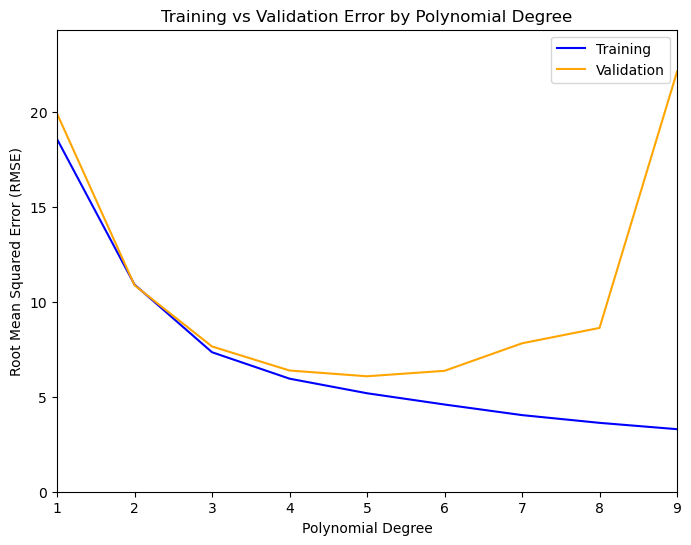

In [90]:
Polynomial_Model(1, 9, trainX_scaled_1, holdX_scaled_1, testX_scaled_1, trainY_1, holdY_1, testY_1)

Degree: 1 | Train RMSE: 20.0746 | Holdout RMSE: 21.1214
Degree: 2 | Train RMSE: 6.6612 | Holdout RMSE: 6.9099
Degree: 3 | Train RMSE: 4.5184 | Holdout RMSE: 5.4737
Degree: 4 | Train RMSE: 3.6260 | Holdout RMSE: 4.2499
Degree: 5 | Train RMSE: 3.2004 | Holdout RMSE: 6.4800
Degree: 6 | Train RMSE: 2.8866 | Holdout RMSE: 5.7510
Degree: 7 | Train RMSE: 2.7077 | Holdout RMSE: 16.3396
Degree: 8 | Train RMSE: 2.5334 | Holdout RMSE: 19.3620
Degree: 9 | Train RMSE: 2.3379 | Holdout RMSE: 317.9425

Best Degree: 4 | Test RMSE: 3.9841 | Test R²: 0.9637


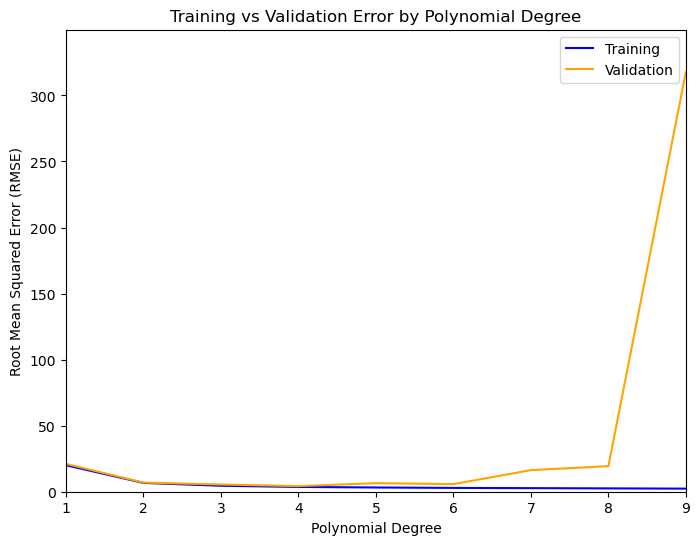

In [91]:
Polynomial_Model(1, 9, trainX_scaled_2, holdX_scaled_2, testX_scaled_2, trainY_2, holdY_2, testY_2)

### **3. Neural Network Model**

In [92]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Sequential # sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout

trainX_scaled, holdX_scaled, testX_scaled, trainY, holdY, testY = preprocess_model(df_train_1, df_hold_1, df_test_1, merged_prediction_df_1)

# Log-transform the target variable
trainY_nn = trainY / 100
holdY_nn = holdY / 100
testY_nn = testY / 100

    # initializig artificial neural network
    # one hidden layer
model = Sequential([
    Dense(64, activation='relu', input_shape=(trainX_scaled.shape[1],)),
    Dropout(rate=0.2),
    Dense(32, activation='relu'),
    Dropout(rate=0.2),
    Dense(1, activation='sigmoid')  # Output layer for regression
])

    #compiling the ANN
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

    #train the model
history = model.fit(
    trainX_scaled, trainY_nn,
    validation_data=(testX_scaled, testY_nn),
    epochs=100,
    batch_size=64,
    verbose=1
)

history_df = pd.DataFrame(history.history)
root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_df.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0813 - mae: 0.2408 - mse: 0.0813 - val_loss: 0.0088 - val_mae: 0.0609 - val_mse: 0.0088
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0124 - mae: 0.0724 - mse: 0.0124 - val_loss: 0.0062 - val_mae: 0.0481 - val_mse: 0.0062
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0084 - mae: 0.0577 - mse: 0.0084 - val_loss: 0.0050 - val_mae: 0.0441 - val_mse: 0.0050
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0078 - mae: 0.0557 - mse: 0.0078 - val_loss: 0.0047 - val_mae: 0.0412 - val_mse: 0.0047
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0071 - mae: 0.0522 - mse: 0.0071 - val_loss: 0.0044 - val_mae: 0.0388 - val_mse: 0.0044
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067 - mae: 0.0503 - mse: 0.0067 - val_loss: 0.0044 - val_mae: 0.0382 - val_mse: 0.0044
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - mae: 0.0490 - mse: 0.0062 - val

In [93]:
y_pred_scaled = model.predict(testX_scaled)
y_pred = y_pred_scaled * 100
y_pred_nn = np.clip(y_pred, 0 , 100)

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [94]:
mse_nn = mean_squared_error(testY, y_pred_nn)  
r2_nn = r2_score(testY, y_pred_nn)
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared Score:", r2_nn)

Neural Network - Mean Squared Error: 14.49973792901829
Neural Network - R-squared Score: 0.9903356377853804


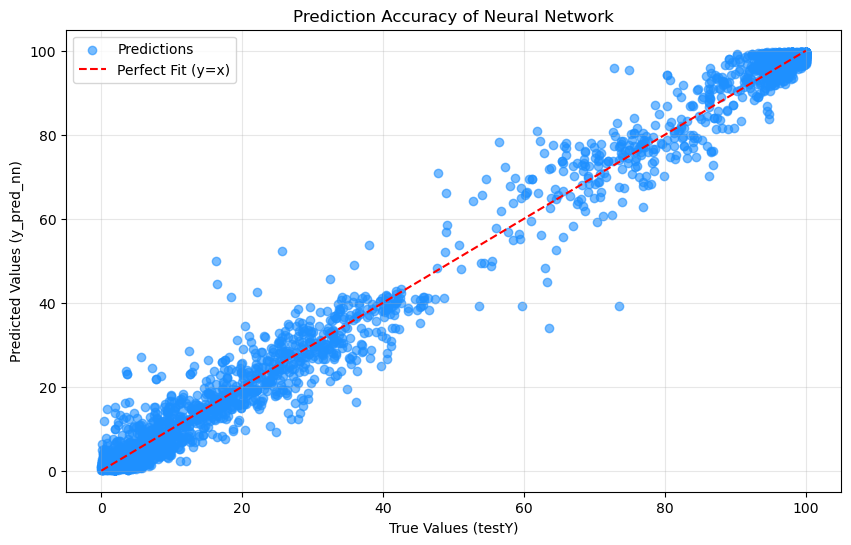

In [95]:
# Plotting ground truth vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(testY, y_pred_nn, alpha=0.6, color='dodgerblue', label='Predictions')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Perfect Fit (y=x)')
plt.title("Prediction Accuracy of Neural Network")
plt.xlabel("True Values (testY)")
plt.ylabel("Predicted Values (y_pred_nn)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

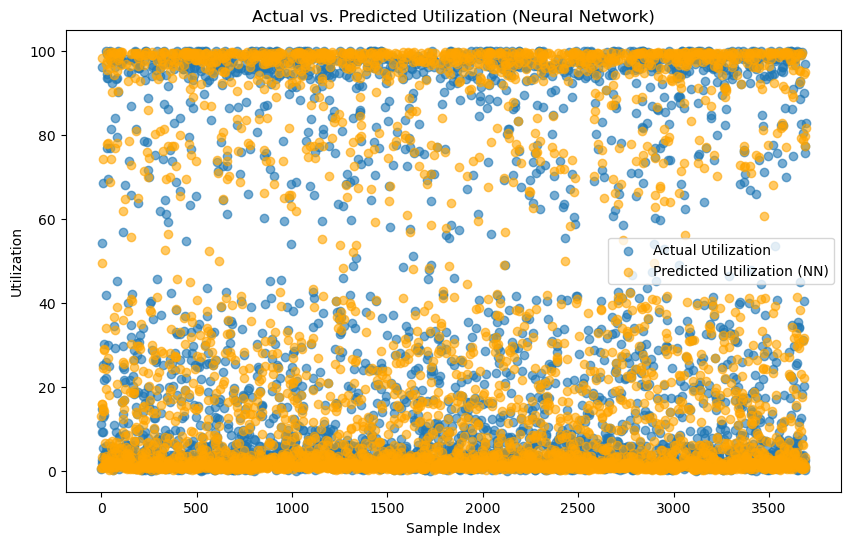

In [96]:
# Plot Actual vs Predicted Utilization
plt.figure(figsize=(10, 6))
plt.scatter(range(len(testY)), testY , label="Actual Utilization", alpha=0.6)
plt.scatter(range(len(y_pred_nn)), y_pred_nn, label="Predicted Utilization (NN)", alpha=0.6, color='orange')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Utilization")
plt.title("Actual vs. Predicted Utilization (Neural Network)")
plt.show()

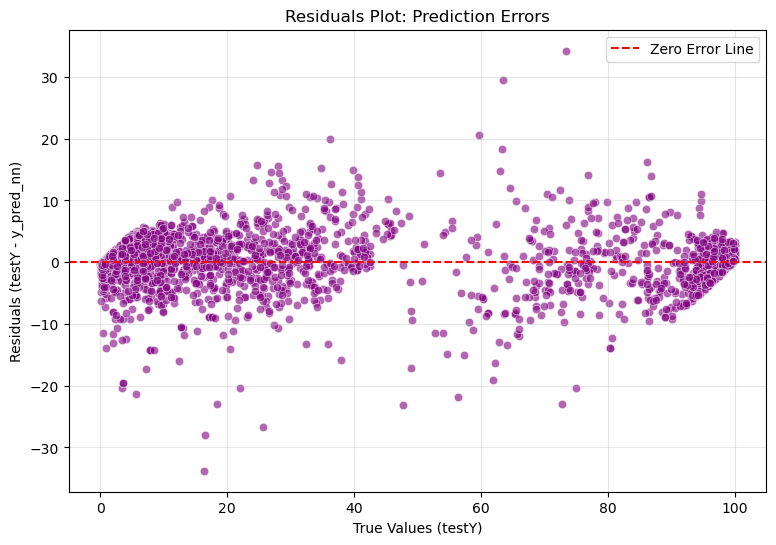

In [97]:
testY = testY.values.ravel()  # Converts to 1D array
y_pred_nn = y_pred_nn.ravel()  # Converts to 1D array
residuals = testY - y_pred_nn

# Residuals Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(x=testY, y=residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.title("Residuals Plot: Prediction Errors")
plt.xlabel("True Values (testY)")
plt.ylabel("Residuals (testY - y_pred_nn)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## `Model Evaluation and Revision`

We noticed the problem of data leakage when using the lagged features like before. Our test data would know about relationships in our training or validation data which definetly would manipulate the result. Thats why they seem perfect. But we want to simulate a prediction of unknown data so we have to correct our feature processing for the models. 

We also thought about a more realistic alternative to split the dataset. Because we are working with time-based data and want to predict future events we simulate the prediction of future events by splitting the data in time-based order. The test set therefore includes the newest 15% of the data - like predicting "next week".


In [98]:
# make sure the data in the set is sorted by time 
merged_prediction_1 = merged_prediction_1.sort_values(by=['date', 'hour']).reset_index(drop=True)
merged_prediction_2 = merged_prediction_2.sort_values(by=['date', 'hour']).reset_index(drop=True)

In [99]:
# new split in time order - calculation of split points needed
train_split_1 = int(len(merged_prediction_1) * 0.7)  # 70% Training
val_split_1 = int(len(merged_prediction_1) * 0.85)  # 15% Validation and last 15% Test

train_split_2 = int(len(merged_prediction_2) * 0.7)  # 70% Training
val_split_2 = int(len(merged_prediction_2) * 0.85)  # 15% Validation and last 15% Test

# split the data for site 1
train_data_1 = merged_prediction_1.iloc[:train_split_1]
val_data_1 = merged_prediction_1.iloc[train_split_1:val_split_1]
test_data_1 = merged_prediction_1.iloc[val_split_1:]

# Split the data for site 2
train_data_2 = merged_prediction_2.iloc[:train_split_2]
val_data_2 = merged_prediction_2.iloc[train_split_2:val_split_2]
test_data_2 = merged_prediction_2.iloc[val_split_2:]


In [100]:
# correctly use the lagged features to make time-based predictions more precise and preserve independence of the dataset splits
train_data_1['hourly_utilization_lag_1'] = train_data_1['hourly_utilization'].shift(1)
train_data_1['hourly_utilization_lag_24'] = train_data_1['hourly_utilization'].shift(24)

val_data_1['hourly_utilization_lag_1'] = val_data_1['hourly_utilization'].shift(1)
val_data_1['hourly_utilization_lag_24'] = val_data_1['hourly_utilization'].shift(24)

# Test data lagged features
test_data_1['hourly_utilization_lag_1'] = test_data_1['hourly_utilization'].shift(1)
test_data_1['hourly_utilization_lag_24'] = test_data_1['hourly_utilization'].shift(24)

# to see if the time-split is correct according to the dates
# print(f"Train data: {train_data_1['date'].min()} to {train_data_1['date'].max()} ({len(train_data_1)} rows)")
# print(f"Validation data: {val_data_1['date'].min()} to {val_data_1['date'].max()} ({len(val_data_1)} rows)")
# print(f"Test data: {test_data_1['date'].min()} to {test_data_1['date'].max()} ({len(test_data_1)} rows)")

train_data_2['hourly_utilization_lag_1'] = train_data_2['hourly_utilization'].shift(1)
train_data_2['hourly_utilization_lag_24'] = train_data_2['hourly_utilization'].shift(24)

val_data_2['hourly_utilization_lag_1'] = val_data_2['hourly_utilization'].shift(1)
val_data_2['hourly_utilization_lag_24'] = val_data_2['hourly_utilization'].shift(24)

test_data_2['hourly_utilization_lag_1'] = test_data_2['hourly_utilization'].shift(1)
test_data_2['hourly_utilization_lag_24'] = test_data_2['hourly_utilization'].shift(24)

# To see if the time-split is correct according to the dates
# print(f"Train data 2: {train_data_2['date'].min()} to {train_data_2['date'].max()} ({len(train_data_2)} rows)")
# print(f"Validation data 2: {val_data_2['date'].min()} to {val_data_2['date'].max()} ({len(val_data_2)} rows)")
# print(f"Test data 2: {test_data_2['date'].min()} to {test_data_2['date'].max()} ({len(test_data_2)} rows)")



In [101]:
#Using rolling averate features to capture trends over the time

train_data_1['rolling_avg_3'] = train_data_1['hourly_utilization'].rolling(window=3).mean()
train_data_1['rolling_avg_24'] = train_data_1['hourly_utilization'].rolling(window=24).mean()

val_data_1['rolling_avg_3'] = val_data_1['hourly_utilization'].rolling(window=3).mean()
val_data_1['rolling_avg_24'] = val_data_1['hourly_utilization'].rolling(window=24).mean()

test_data_1['rolling_avg_3'] = test_data_1['hourly_utilization'].rolling(window=3).mean()
test_data_1['rolling_avg_24'] = test_data_1['hourly_utilization'].rolling(window=24).mean()

# print(train_data_1.columns)
# print(val_data_1.columns)
# print(test_data_1.columns)

train_data_2['rolling_avg_3'] = train_data_2['hourly_utilization'].rolling(window=3).mean()
train_data_2['rolling_avg_24'] = train_data_2['hourly_utilization'].rolling(window=24).mean()

val_data_2['rolling_avg_3'] = val_data_2['hourly_utilization'].rolling(window=3).mean()
val_data_2['rolling_avg_24'] = val_data_2['hourly_utilization'].rolling(window=24).mean()

test_data_2['rolling_avg_3'] = test_data_2['hourly_utilization'].rolling(window=3).mean()
test_data_2['rolling_avg_24'] = test_data_2['hourly_utilization'].rolling(window=24).mean()

In [102]:
# Fill NaN values in all splits, which are caused by the lagged features with 0
# The first samples do not have preceding data, which is why the lagged features are NaN

train_data_1 = train_data_1.fillna(0)
val_data_1 = val_data_1.fillna(0)
test_data_1 = test_data_1.fillna(0)

train_data_2 = train_data_2.fillna(0)
val_data_2 = val_data_2.fillna(0)
test_data_2 = test_data_2.fillna(0)

To collect the metrics: one dataframe `metrics_df_revised`

In [132]:
# Creating a revised DataFrame structure for metrics with Site 1 and Site 2 side by side
metrics_df_revised = pd.DataFrame({
    "Site": ["Site 1", "Site 1", "Site 1", "Site 2", "Site 2", "Site 2"],
    "Model": ["Neural Network", "Polynomial Regression", "Random Forest",
              "Neural Network", "Polynomial Regression", "Random Forest"],
    "MSE": [None, None, None, None, None, None],  # Placeholder 
    "RMSE": [None, None, None, None, None, None],  # Placeholder 
    "R2": [None, None, None, None, None, None]     # Placeholder 
})

# import ace_tools as tools;
# # Display the DataFrame to the user
# tools.display_dataframe_to_user(name="Detailed Model Metrics for Sites 1 and 2", dataframe=metrics_df_revised)
metrics_df_revised

,Site,Model,MSE,RMSE,R2
0,Site 1,Neural Network,None,None,None
1,Site 1,Polynomial Regression,None,None,None
2,Site 1,Random Forest,None,None,None
3,Site 2,Neural Network,None,None,None
4,Site 2,Polynomial Regression,None,None,None
5,Site 2,Random Forest,None,None,None


In [103]:
# final features
features = [
    'hour', 'day_of_week', 'temperature', 'month',
    'hourly_utilization_lag_1', 'hourly_utilization_lag_24',  # Lagged Features
    'rolling_avg_3', 'rolling_avg_24']

target = 'hourly_utilization'

In [136]:
def Polynomial_Model_Test(s, degr, train, hold, test, features, target):
 
    trainX, trainY = train[features], train[target]
    holdX, holdY = hold[features], hold[target]
    testX, testY = test[features], test[target]

    # Periodische Features erstellen
    for dataset in [trainX, holdX, testX]:
        dataset['hour_sin'] = np.sin(2 * np.pi * dataset['hour'] / 24)
        dataset['hour_cos'] = np.cos(2 * np.pi * dataset['hour'] / 24)
        dataset['day_of_week_sin'] = np.sin(2 * np.pi * dataset['day_of_week'] / 7)
        dataset['day_of_week_cos'] = np.cos(2 * np.pi * dataset['day_of_week'] / 7)

    # Drop ursprüngliche Zeitspalten, da sie durch periodische Features ersetzt werden
    trainX = trainX.drop(['hour', 'day_of_week'], axis=1)
    holdX = holdX.drop(['hour', 'day_of_week'], axis=1)
    testX = testX.drop(['hour', 'day_of_week'], axis=1)

     # Skalierung der Features
    scaler = StandardScaler()
    trainX_scaled = scaler.fit_transform(trainX)
    holdX_scaled = scaler.transform(holdX)
    testX_scaled = scaler.transform(testX)

    # Log-Transformation der Zielvariable
    trainY_log = np.log1p(trainY)
    holdY_log = np.log1p(holdY)
    testY_log = np.log1p(testY)

    # Fehlerlisten initialisieren
    err_train = []
    err_hold = []
    best_model = None
    best_degree = s

    for d in range(s, degr + 1):
        # Polynomiale Features
        poly = PolynomialFeatures(degree=d, include_bias=False)
        poly_features_train = poly.fit_transform(trainX_scaled)

        # Ridge Regression trainieren
        model = Ridge(alpha=10.0)
        model.fit(poly_features_train, trainY_log)

        # Vorhersagen für Training und Holdout
        train_predicted = np.expm1(model.predict(poly_features_train))
        train_rmse = np.sqrt(mean_squared_error(np.expm1(trainY_log), train_predicted))

        poly_features_hold = poly.transform(holdX_scaled)
        hold_predicted = np.expm1(model.predict(poly_features_hold))
        hold_rmse = np.sqrt(mean_squared_error(np.expm1(holdY_log), hold_predicted))

        # Fehler speichern
        err_train.append(train_rmse)
        err_hold.append(hold_rmse)

        print(f"Degree: {d} | Train RMSE: {train_rmse:.4f} | Holdout RMSE: {hold_rmse:.4f}")

        # Bestes Modell speichern
        if len(err_hold) > 1 and err_hold[-2] > hold_rmse:
            best_model = (model, poly)
            best_degree = d
    
    # Testdaten mit dem besten Modell bewerten
    final_model, final_poly = best_model
    poly_features_test = final_poly.transform(testX_scaled)
    test_predicted = np.expm1(final_model.predict(poly_features_test))
    test_rmse = np.sqrt(mean_squared_error(np.expm1(testY_log), test_predicted))
    test_r2 = r2_score(np.expm1(testY_log), test_predicted)

    print(f"\nBest Degree: {best_degree} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")

    # Plot der Trainings- und Validierungsfehler
    if degr >= s:
        plt.figure(figsize=(8, 6))
        plt.plot(range(s, degr + 1), err_train, label="Train RMSE", color='blue')
        plt.plot(range(s, degr + 1), err_hold, label="Validation RMSE", color='orange')
        plt.xlabel("Polynomial Degree")
        plt.ylabel("RMSE")
        plt.legend()
        plt.title("Train vs Validation Error by Polynomial Degree")
        plt.show()
    
    return test_rmse, test_r2,best_model


Degree: 1 | Train RMSE: 23.6863 | Holdout RMSE: 20.6160
Degree: 2 | Train RMSE: 11.2427 | Holdout RMSE: 9.7671
Degree: 3 | Train RMSE: 5.8953 | Holdout RMSE: 5.8960
Degree: 4 | Train RMSE: 4.3241 | Holdout RMSE: 6.9942
Degree: 5 | Train RMSE: 3.0884 | Holdout RMSE: 52.5647

Best Degree: 3 | Test RMSE: 3.5872 | Test R²: 0.8604


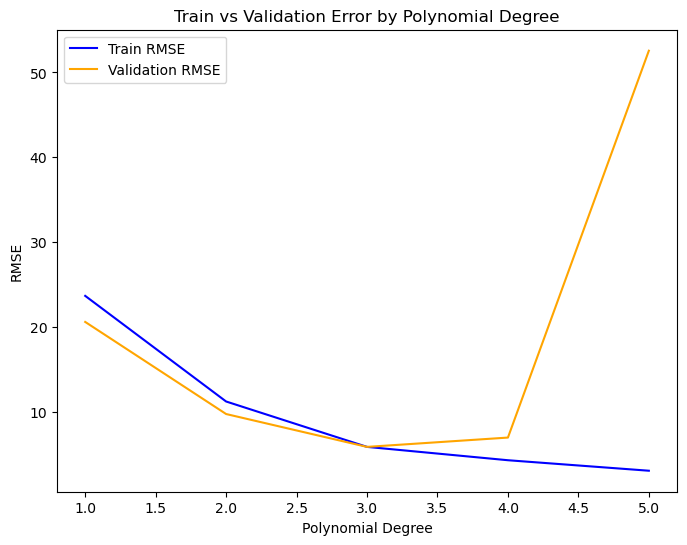

In [138]:
test_rmse_1, test_r2_1, best_model = Polynomial_Model_Test(
    s=1, degr=5, train=train_data_1, hold=val_data_1, test=test_data_1,
    features=features, target=target
)

# Update des DataFrames
metrics_df_revised.loc[
    (metrics_df_revised["Site"] == "Site 1") & (metrics_df_revised["Model"] == "Polynomial Regression"),
    ["RMSE", "R2"]
] = [test_rmse_1, test_r2_1]

Degree: 1 | Train RMSE: 17.3989 | Holdout RMSE: 7.1086
Degree: 2 | Train RMSE: 6.7552 | Holdout RMSE: 4.5528
Degree: 3 | Train RMSE: 3.8901 | Holdout RMSE: 3.2720
Degree: 4 | Train RMSE: 2.7676 | Holdout RMSE: 2.9275
Degree: 5 | Train RMSE: 2.1367 | Holdout RMSE: 4.2584

Best Degree: 4 | Test RMSE: 1.9902 | Test R²: 0.9789


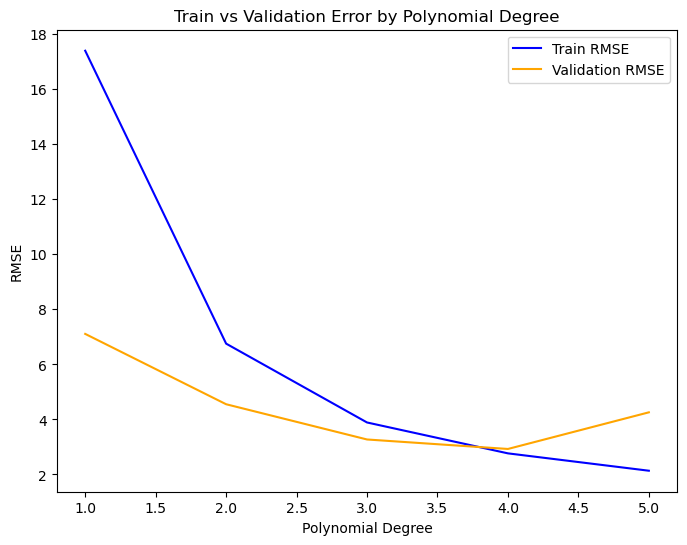

In [139]:
test_rmse_2, test_r2_2, best_model_2 = Polynomial_Model_Test(
    s=1, degr=5, train=train_data_2, hold=val_data_2, test=test_data_2,
    features=features, target=target
)

# Update des DataFrames
metrics_df_revised.loc[
    (metrics_df_revised["Site"] == "Site 2") & (metrics_df_revised["Model"] == "Polynomial Regression"),
    ["RMSE", "R2"]
] = [test_rmse_2, test_r2_2]

In [140]:
metrics_df_revised

,Site,Model,MSE,RMSE,R2
0,Site 1,Neural Network,None,None,None
1,Site 1,Polynomial Regression,None,3.587226,0.860372
2,Site 1,Random Forest,None,None,None
3,Site 2,Neural Network,None,None,None
4,Site 2,Polynomial Regression,None,1.990245,0.978933
5,Site 2,Random Forest,None,None,None


In [141]:
def RandomForest_with_GridSearch(train_df, hold_df, test_df, features, target):
    """
    Train a Random Forest model using GridSearchCV for hyperparameter tuning, evaluate on train, holdout, and test sets.

    Parameters:
    - train_df, hold_df, test_df: DataFrames containing features and target
    - features: List of feature column names
    - target: Target column name
    
    Returns:
    - Best Random Forest model
    """
    # Split the data into X (features) and y (target)
    trainX = train_df[features]
    trainY = train_df[target]
    holdX = hold_df[features]
    holdY = hold_df[target]
    testX = test_df[features]
    testY = test_df[target]

    # Log-transform the target variable
    trainY_log = np.log1p(trainY)
    holdY_log = np.log1p(holdY)
    testY_log = np.log1p(testY)

    # Hyperparameter tuning for Random Forest
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=32),
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1
    )

    # Train the model using GridSearchCV to find the best parameters
    grid_search.fit(trainX, trainY_log)
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Evaluate the model
    print("\nModel Evaluation")

    # Training set evaluation
    predicted_log_train = best_model.predict(trainX)
    predicted_train = np.expm1(predicted_log_train)  # Reverse log transformation
    rmse_train = np.sqrt(mean_squared_error(np.expm1(trainY_log), predicted_train))
    r2_train = r2_score(np.expm1(trainY_log), predicted_train)
    print(f"Training Set RMSE: {rmse_train:.4f} | R²: {r2_train:.4f}")

    # Holdout set evaluation
    predicted_log_hold = best_model.predict(holdX)
    predicted_hold = np.expm1(predicted_log_hold)  # Reverse log transformation
    rmse_hold = np.sqrt(mean_squared_error(np.expm1(holdY_log), predicted_hold))
    r2_hold = r2_score(np.expm1(holdY_log), predicted_hold)
    print(f"Holdout Set RMSE: {rmse_hold:.4f} | R²: {r2_hold:.4f}")

    # Test set evaluation
    predicted_log_test = best_model.predict(testX)
    predicted_test = np.expm1(predicted_log_test)  # Reverse log transformation
    rmse_test = np.sqrt(mean_squared_error(np.expm1(testY_log), predicted_test))
    r2_test = r2_score(np.expm1(testY_log), predicted_test)
    print(f"Test Set RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")

    return best_model, rmse_test, r2_test

In [146]:
best_rf_model_1, rmserf_1, r2rf_1 = RandomForest_with_GridSearch(train_df=train_data_1, hold_df=val_data_1, test_df=test_data_1, features=features, target=target)

# Update des DataFrames
metrics_df_revised.loc[
    (metrics_df_revised["Site"] == "Site 1") & (metrics_df_revised["Model"] == "Random Forest"),
    ["RMSE", "R2"]
] = [rmserf_1, r2rf_1]

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Model Evaluation
Training Set RMSE: 0.9509 | R²: 0.9995
Holdout Set RMSE: 3.3047 | R²: 0.9924
Test Set RMSE: 2.5506 | R²: 0.9294


In [147]:
best_rf_model_2, rmserf_2, r2rf_2 = RandomForest_with_GridSearch(train_df=train_data_2, hold_df=val_data_2, test_df=test_data_2, features=features, target=target)

# Update des DataFrames
metrics_df_revised.loc[
    (metrics_df_revised["Site"] == "Site 2") & (metrics_df_revised["Model"] == "Random Forest"),
    ["RMSE", "R2"]
] = [rmserf_2, r2rf_2]

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Model Evaluation
Training Set RMSE: 1.2940 | R²: 0.9965
Holdout Set RMSE: 2.4949 | R²: 0.9762
Test Set RMSE: 1.7787 | R²: 0.9832


In [148]:
metrics_df_revised

,Site,Model,MSE,RMSE,R2
0,Site 1,Neural Network,None,None,None
1,Site 1,Polynomial Regression,None,3.587226,0.860372
2,Site 1,Random Forest,None,2.550557,0.929413
3,Site 2,Neural Network,None,None,None
4,Site 2,Polynomial Regression,None,1.990245,0.978933
5,Site 2,Random Forest,None,1.778745,0.983173


In [110]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Sequential
from keras.layers import Dense, Dropout


def NeuralNetworkModel(train_df, hold_df, test_df, features, target, epochs=100, batch_size=64):
  
    # Split the data into X (features) and y (target)
    trainX = train_df[features]
    trainY = train_df[target] / 100  # Scale target for neural network
    holdX = hold_df[features]
    holdY = hold_df[target] / 100  # Scale target for neural network
    testX = test_df[features]
    testY = test_df[target] / 100  # Scale target for neural network

    # Initialize artificial neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=(len(features),)),
        Dropout(rate=0.1),
        Dense(32, activation='relu'),
        Dropout(rate=0.1),
        Dense(1, activation='sigmoid')  # Output layer for regression
    ])

    # Compile the ANN
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

    # Train the model
    history = model.fit(
        trainX, trainY,
        validation_data=(testX, testY),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Convert history to DataFrame
    history_df = pd.DataFrame(history.history)
    root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)  # Compute RMSE
    root_metrics_df.rename({"mse": "rmse", "val_mse": "val_rmse"}, axis=1, inplace=True)

    # Print final RMSE
    print(f"Final Training RMSE: {root_metrics_df['rmse'].iloc[-1]:.4f}")
    print(f"Final Validation RMSE: {root_metrics_df['val_rmse'].iloc[-1]:.4f}")

    return model, root_metrics_df, trainX, holdX, testX, trainY, holdY, testY

In [111]:
model_1, metrics_df, trainX, holdX, testX, trainY, holdY, testY = NeuralNetworkModel(
    train_data_1, val_data_1, test_data_1, features, target, epochs=100, batch_size=64
)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1600 - mae: 0.2381 - mse: 0.1600 - val_loss: 0.0252 - val_mae: 0.1048 - val_mse: 0.0252
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0410 - mae: 0.1087 - mse: 0.0410 - val_loss: 0.0187 - val_mae: 0.1031 - val_mse: 0.0187
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0346 - mae: 0.1016 - mse: 0.0346 - val_loss: 0.0187 - val_mae: 0.1038 - val_mse: 0.0187
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0287 - mae: 0.0947 - mse: 0.0287 - val_loss: 0.0183 - val_mae: 0.1028 - val_mse: 0.0183
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0249 - mae: 0.0902 - mse: 0.0249 - val_loss: 0.0081 - val_mae: 0.0697 - val_mse: 0.0081
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0177 - mae: 0.0771 - mse: 0.0177 - val_loss: 0.0054 - val_mae: 0.0571 - val_mse: 0.0054
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0117 - mae: 0.0662 - mse

<Axes: title={'center': 'Training and Validation RMSE Site 1'}>

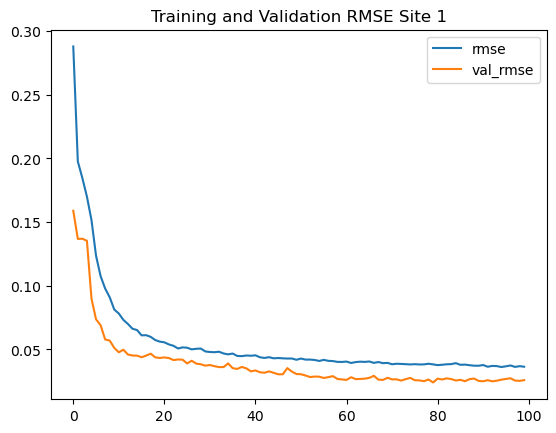

In [112]:
metrics_df[['rmse', 'val_rmse']].plot(title="Training and Validation RMSE Site 1")

In [149]:
y_pred_scaled = model_1.predict(testX)
y_pred = y_pred_scaled * 100  # Rescale predictions to original scale
y_pred_nn = np.clip(y_pred, 0, 100)  # Clip predictions to valid range

testY_rescaled = testY * 100 

# Calculate evaluation metrics
mse_nn = mean_squared_error(testY_rescaled, y_pred_nn)
r2_nn = r2_score(testY_rescaled, y_pred_nn)

# Neural Network, Site 1 aktualisieren
metrics_df_revised.loc[(metrics_df_revised["Site"] == "Site 1") & 
                       (metrics_df_revised["Model"] == "Neural Network"), ["MSE", "R2"]] = [mse_nn, r2_nn]


# Print results
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared Score:", r2_nn)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network - Mean Squared Error: 11.858857634196413
Neural Network - R-squared Score: 0.9369299425132596


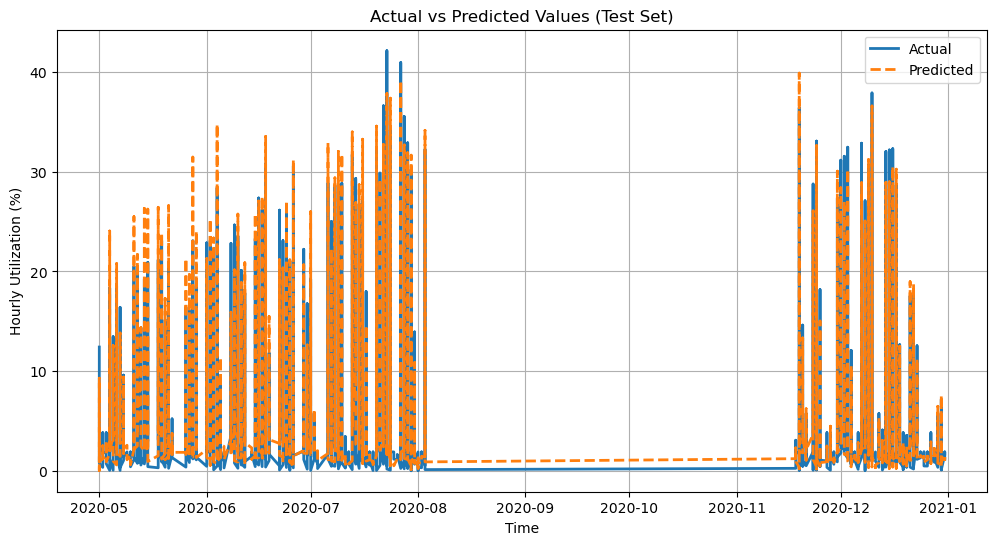

In [114]:
import matplotlib.pyplot as plt

# Create a time index (assuming 'date' exists in test_data)
time_index = test_data_1['date'] if 'date' in test_data_1 else range(len(testY_rescaled))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, testY_rescaled, label="Actual", linewidth=2)
plt.plot(time_index, y_pred_nn, label="Predicted", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Values (Test Set)")
plt.xlabel("Time")
plt.ylabel("Hourly Utilization (%)")
plt.legend()
plt.grid()
plt.show()


In [115]:
model_2, metrics_df, trainX, holdX, testX, trainY, holdY, testY = NeuralNetworkModel(
    train_data_2, val_data_2, test_data_2, features, target, epochs=100, batch_size=64
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1189 - mae: 0.2464 - mse: 0.1189 - val_loss: 0.0260 - val_mae: 0.0846 - val_mse: 0.0260
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0415 - mae: 0.1428 - mse: 0.0415 - val_loss: 0.0033 - val_mae: 0.0380 - val_mse: 0.0033
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0100 - mae: 0.0749 - mse: 0.0100 - val_loss: 0.0026 - val_mae: 0.0329 - val_mse: 0.0026
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0069 - mae: 0.0618 - mse: 0.0069 - val_loss: 0.0022 - val_mae: 0.0302 - val_mse: 0.0022
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0054 - mae: 0.0547 - mse: 0.0054 - val_loss: 0.0018 - val_mae: 0.0268 - val_mse: 0.0018
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0043 - mae: 0.0484 - mse: 0.0043 - val_loss: 0.0015 - val_mae: 0.0248 - val_mse: 0.0015
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0038 - mae: 0.0455 - mse

<Axes: title={'center': 'Training and Validation RMSE Site 2'}>

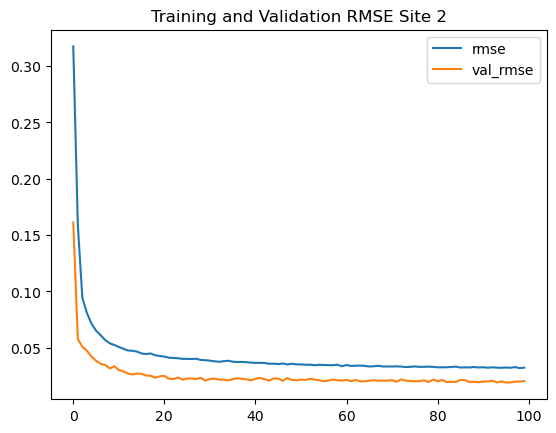

In [116]:
metrics_df[['rmse', 'val_rmse']].plot(title="Training and Validation RMSE Site 2")

In [150]:
y_pred_scaled = model_2.predict(testX)
y_pred = y_pred_scaled * 100  # Rescale predictions to original scale
y_pred_nn = np.clip(y_pred, 0, 100)  # Clip predictions to valid range

testY_rescaled = testY * 100 

# Calculate evaluation metrics
mse_nn_2 = mean_squared_error(testY_rescaled, y_pred_nn)
r2_nn_2 = r2_score(testY_rescaled, y_pred_nn)

metrics_df_revised.loc[(metrics_df_revised["Site"] == "Site 2") & 
                       (metrics_df_revised["Model"] == "Neural Network"), ["MSE", "R2"]] = [mse_nn_2, r2_nn_2]

# Print results
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared Score:", r2_nn)

 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Neural Network - Mean Squared Error: 11.858857634196413
Neural Network - R-squared Score: 0.9369299425132596


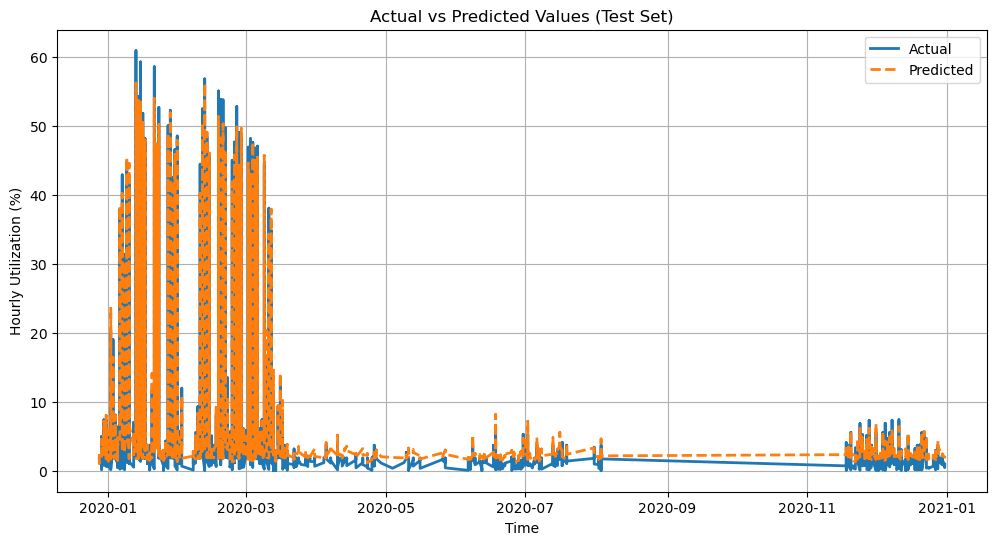

In [118]:
import matplotlib.pyplot as plt

# Create a time index (assuming 'date' exists in test_data)
time_index = test_data_2['date'] if 'date' in test_data_2 else range(len(testY_rescaled))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, testY_rescaled, label="Actual", linewidth=2)
plt.plot(time_index, y_pred_nn, label="Predicted", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Values (Test Set)")
plt.xlabel("Time")
plt.ylabel("Hourly Utilization (%)")
plt.legend()
plt.grid()
plt.show()


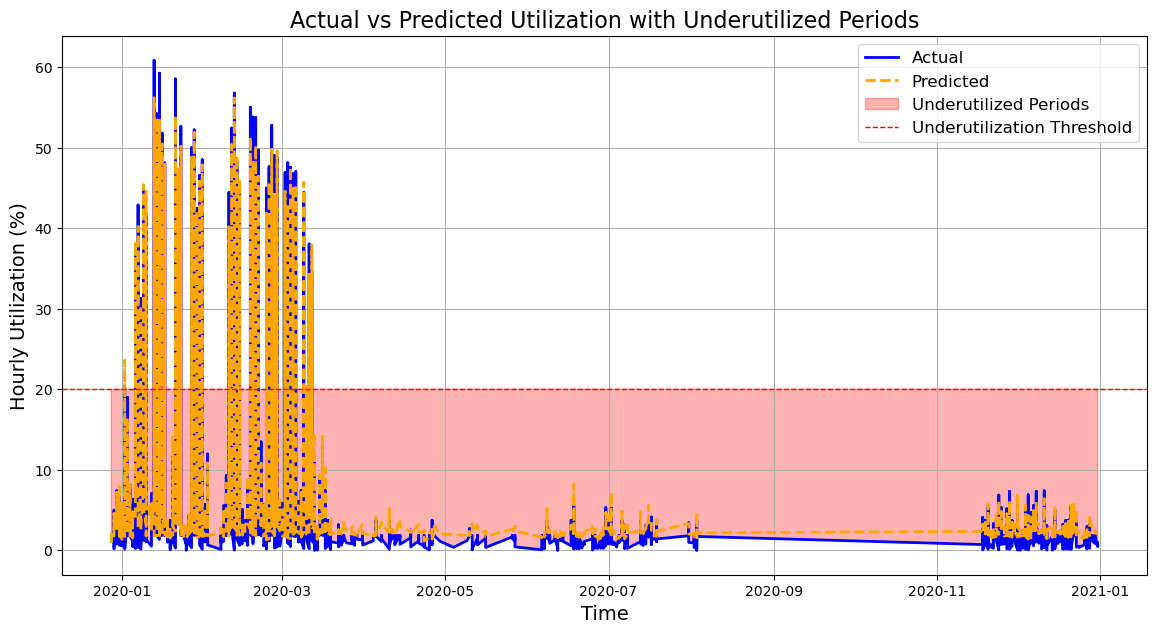

In [119]:
# Define underutilization threshold
underutilization_threshold = 20  # Example threshold (e.g., below 20% utilization)

# Identify underutilized periods
underutilized_mask = testY_rescaled < underutilization_threshold

# Enhanced plot
plt.figure(figsize=(14, 7))
plt.plot(time_index, testY_rescaled, label="Actual", color="blue", linewidth=2)
plt.plot(time_index, y_pred_nn, label="Predicted", linestyle="--", color="orange", linewidth=2)

# Highlight underutilized periods
plt.fill_between(
    time_index,
    testY_rescaled,
    underutilization_threshold,
    where=underutilized_mask,
    color="red",
    alpha=0.3,
    label="Underutilized Periods"
)

# Add labels and title
plt.title("Actual vs Predicted Utilization with Underutilized Periods", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Hourly Utilization (%)", fontsize=14)
plt.axhline(y=underutilization_threshold, color="red", linestyle="--", linewidth=1, label="Underutilization Threshold")
plt.legend(fontsize=12)
plt.grid()
plt.show()


In [151]:
metrics_df_revised

,Site,Model,MSE,RMSE,R2
0,Site 1,Neural Network,11.858858,None,0.93693
1,Site 1,Polynomial Regression,None,3.587226,0.860372
2,Site 1,Random Forest,None,2.550557,0.929413
3,Site 2,Neural Network,4.163759,None,0.977855
4,Site 2,Polynomial Regression,None,1.990245,0.978933
5,Site 2,Random Forest,None,1.778745,0.983173


In [153]:
# Calculate the missing RMSE and MSE values based on the given data

# Filling in RMSE where MSE is provided
metrics_df_revised.loc[metrics_df_revised["RMSE"].isnull(), "RMSE"] = metrics_df_revised.loc[
    metrics_df_revised["RMSE"].isnull(), "MSE"
].apply(lambda x: x**0.5 if x is not None else None)

# Filling in MSE where RMSE is provided
metrics_df_revised.loc[metrics_df_revised["MSE"].isnull(), "MSE"] = metrics_df_revised.loc[
    metrics_df_revised["MSE"].isnull(), "RMSE"
].apply(lambda x: x**2 if x is not None else None)

# Display the updated DataFrame
metrics_df_revised

,Site,Model,MSE,RMSE,R2
0,Site 1,Neural Network,11.858858,3.443669,0.93693
1,Site 1,Polynomial Regression,12.868194,3.587226,0.860372
2,Site 1,Random Forest,6.505342,2.550557,0.929413
3,Site 2,Neural Network,4.163759,2.040529,0.977855
4,Site 2,Polynomial Regression,3.961075,1.990245,0.978933
5,Site 2,Random Forest,3.163934,1.778745,0.983173
